In [10]:
import sys
#sys.path.append(r'H:\My Drive\2022\GitHub\pyMELTScalc\MELTS')
sys.path.append(r'G:\My Drive\Berkeley_NEW\MELTS_python_Paula\melts_matlab_git_master\package')

from meltsdynamic import MELTSdynamic
from meltsengine import MELTSengine
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from meltsplotter import MELTSplotter
import sys, os
import shutil
import tempfile
from collections import OrderedDict
from pathlib import Path
import deepdish as dd
import itertools
%matplotlib inline
import time
import random
import pyMELTScalc as M
import re
from matplotlib.cm import get_cmap
from cmcrameri import cm
import Thermobar as pt
import distinctipy
import PySulfSat as ss

In [11]:
#second upload to git
#april 10th added 2, 3, 5 wt% H2O. then calcualted fluxes; added in solid sulfide-melt Kds. 

In [12]:
print(M.__version__),print(ss.__version__)

0.1.3
0.0.15


(None, None)

In [13]:
file = pd.read_csv('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/MELTs/pyMELTScalc-master/Examples/CrystallisationTests/SchmidtVan_scss.csv')
#file = pd.read_csv('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/Paper_2/FC_simulations/Metrich_Tan2318.csv')
#file = pd.read_csv('/Users/ollie/Rhiannon_MELTS/StVincbulks.csv')
#file = pd.read_csv('/Users/ollie/Rhiannon_MELTS/gleeson_azorestest.csv')
header = file.columns.values.tolist()
file

,P,Temp,FMQ,CO2,SiO2,TiO2,Al2O3,FeO,Fe2O3,MgO,...,Na2O,K2O,MnO,P2O5,H2O,Cr2O5,NiO,Ni,Cu,FeOt
0,2000,1350,0,0.1,49.2,0.69,12.9,7.2689,2.6907,12.93,...,1.99,0.97,0.2,0.2,1,0,0,20,30,9.9596


In [14]:
bulk = file.iloc[0].values.tolist()

h2o = [0.1,1.0,2.0,3.0,4.0,5.0, 6.0]
emptydf = pd.DataFrame()

for i in range(len(h2o)):
    bulk[15] = h2o[i]

    emptydf = emptydf.append(pd.DataFrame([bulk]), ignore_index=True)

emptydf.columns = header
emptydf = emptydf[['SiO2', 'TiO2', 'Al2O3','FeOt', 'MgO', 'CaO', 'Na2O', 'K2O','MnO', 'P2O5', 'H2O']]#'CO2',,]], 
emptydf['Fe3Fet']=  [0.15,0.18,0.19,0.21,0.22,0.23,0.25]
#emptydf['CO2'] = [0.05]

In [15]:
emptydf.columns = [str(col) + '_Liq' for col in emptydf.columns]
emptydf

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,MnO_Liq,P2O5_Liq,H2O_Liq,Fe3Fet_Liq
0,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,0.1,0.15
1,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,1.0,0.18
2,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,2.0,0.19
3,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,3.0,0.21
4,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,4.0,0.22
5,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,5.0,0.23
6,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,6.0,0.25


# For a known buffer e.g. QFM+1, issue is fixed pressure 

# this was the wrong way to calc for purpose of this. 
myLiquids_Fe3_Kress_norm_QFM1=pt.convert_fo2_to_fe_partition(liq_comps=emptydf, T_K=T_HT87,
                            P_kbar=2, fo2="QFM",fo2_offset=1, model="Kress1991", renorm=True) #check pkbar
myLiquids_Fe3_Kress_norm_QFM1['buffer'] = 'QFM_1' #change back to 1
myLiquids_Fe3_Kress_norm_QFM1[['H2O_Liq','CO2_Liq']] = emptydf[['H2O_Liq','CO2_Liq']] #

myLiquids_Fe3_Kress_norm_QFM=pt.convert_fo2_to_fe_partition(liq_comps=emptydf, T_K=T_HT87,
                            P_kbar=2, fo2="QFM", model="Kress1991", renorm=True)
myLiquids_Fe3_Kress_norm_QFM['buffer'] = 'QFM'
myLiquids_Fe3_Kress_norm_QFM[['H2O_Liq','CO2_Liq']] = emptydf[['H2O_Liq','CO2_Liq']] #

myLiquids_Fe3_Kress_norm_NNO=pt.convert_fo2_to_fe_partition(liq_comps=emptydf, T_K=T_HT87,
                            P_kbar=2, fo2="NNO", model="Kress1991", renorm=True)
myLiquids_Fe3_Kress_norm_NNO['buffer'] = 'NNO'
myLiquids_Fe3_Kress_norm_NNO[['H2O_Liq','CO2_Liq']] = emptydf[['H2O_Liq','CO2_Liq']] 

In [16]:
# Create unbuffered input
unbuff = emptydf.copy()
unbuff['buffer'] = 'unbuffered'
unbuff['dictindex'] = 'H2O_' + unbuff['H2O_Liq'].astype(str)  + '_' 'buff_' + unbuff['Fe3Fet_Liq'].astype(str) #+ '_' 'CO2_' + merged['CO2_Liq'].astype(str)
unbuff

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,MnO_Liq,P2O5_Liq,H2O_Liq,Fe3Fet_Liq,buffer,dictindex
0,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,0.1,0.15,unbuffered,H2O_0.1_buff_0.15
1,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,1.0,0.18,unbuffered,H2O_1.0_buff_0.18
2,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,2.0,0.19,unbuffered,H2O_2.0_buff_0.19
3,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,3.0,0.21,unbuffered,H2O_3.0_buff_0.21
4,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,4.0,0.22,unbuffered,H2O_4.0_buff_0.22
5,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,5.0,0.23,unbuffered,H2O_5.0_buff_0.23
6,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,6.0,0.25,unbuffered,H2O_6.0_buff_0.25


In [7]:
QFM_input = emptydf.copy()
QFM_input['Fe3Fet_Liq'] = ""
QFM_input['buffer'] = 'QFM'
QFM_input

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,MnO_Liq,P2O5_Liq,H2O_Liq,Fe3Fet_Liq,buffer
0,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,0.1,,QFM
1,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,1.0,,QFM
2,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,4.0,,QFM
3,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,6.0,,QFM


In [8]:
QFM1_input = emptydf.copy()
#QFM1_input['Fe3Fet_Liq'] = ""
QFM1_input['buffer'] = 'QFM_1'
QFM1_input

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,MnO_Liq,P2O5_Liq,H2O_Liq,Fe3Fet_Liq,buffer
0,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,0.1,0.15,QFM_1
1,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,1.0,0.18,QFM_1
2,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,4.0,0.21,QFM_1
3,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,6.0,0.25,QFM_1


In [9]:
# merge dataframes ready for MELTS simulations - for practice just use 2 to save time
#merged = pd.concat([myLiquids_Fe3_Kress_norm_QFM,unbuff],ignore_index=True) #,myLiquids_Fe3_Kress_norm_QFM1],myLiquids_Fe3_Kress_norm_NNO,,]

In [10]:
#merged['FeOt_Liq'] = np.where(merged['FeOt_Liq'].isnull(), merged['Fe2O3_Liq'] + merged['FeO_Liq'],merged['FeOt_Liq'])

In [11]:
QFM_input['dictindex'] = 'H2O_' + QFM_input['H2O_Liq'].astype(str)  + '_' 'buff_' + QFM_input['buffer'] #+ '_' 'CO2_' + merged['CO2_Liq'].astype(str)
QFM1_input['dictindex'] = 'H2O_' + QFM1_input['H2O_Liq'].astype(str)  + '_' 'buff_' + QFM1_input['buffer'] #+ '_' 'CO2_' + merged['CO2_Liq'].astype(str)
unbuff

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,MnO_Liq,P2O5_Liq,H2O_Liq,Fe3Fet_Liq,buffer,dictindex
0,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,0.1,0.15,unbuffered,H2O_0.1_buff_0.15
1,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,1.0,0.18,unbuffered,H2O_1.0_buff_0.18
2,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,4.0,0.21,unbuffered,H2O_4.0_buff_0.21
3,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,6.0,0.25,unbuffered,H2O_6.0_buff_0.25


In [17]:
Comp = unbuff.copy()
#Comp_qfm = QFM_input.copy()
#Comp_qfm1 = QFM1_input.copy()
Comp #note that row number is the number of unique MELTS inputs 

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,MnO_Liq,P2O5_Liq,H2O_Liq,Fe3Fet_Liq,buffer,dictindex
0,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,0.1,0.15,unbuffered,H2O_0.1_buff_0.15
1,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,1.0,0.18,unbuffered,H2O_1.0_buff_0.18
2,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,2.0,0.19,unbuffered,H2O_2.0_buff_0.19
3,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,3.0,0.21,unbuffered,H2O_3.0_buff_0.21
4,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,4.0,0.22,unbuffered,H2O_4.0_buff_0.22
5,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,5.0,0.23,unbuffered,H2O_5.0_buff_0.23
6,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,6.0,0.25,unbuffered,H2O_6.0_buff_0.25


In [13]:
# for single pressures
P=2000
Results = M.multi_path(Model = "MELTSv1.2.0", comp = Comp_qfm1, Frac_solid = True, Frac_fluid = True, T_end_C = 700, dt_C = 5,
                      P_bar = P, fO2_buffer = "FMQ", fO2_offset = 1, H2O_Liq = None, find_liquidus = True)

NameError: name 'Comp_qfm1' is not defined

In [18]:
# Run 1 - unbuferred input fe3/fet via regression of global datasets

#P_lin = ([2000.0])  #np.array([2000.0, 4000.0]) doesnt work
P_lin = ([2000.0,1000.0,500.0])
P_results_unbuff = {}
for i in range(len(P_lin)):
    P_bar = P_lin[i]
    print(P_bar)
    Results = M.multi_path(cores=4,Model = "MELTSv1.2.0", comp = Comp, Frac_solid = True, Frac_fluid = True, T_end_C = 700, dt_C = 5,
                      P_bar = P_bar, Fe3Fet_Liq = None, H2O_Liq = None, find_liquidus = True)

    P_results_unbuff['P = ' + str(P_lin[i]) + ' bars'] = Results

2000.0


Running MELTSv1.2.0 calculations 0 to 3.0 ... Complete (time taken = 8.36 seconds)
Running MELTSv1.2.0 calculations 4 to 6.0 ... Complete (time taken = 6.52 seconds)

1000.0


Running MELTSv1.2.0 calculations 0 to 3.0 ... Complete (time taken = 6.61 seconds)
Running MELTSv1.2.0 calculations 4 to 6.0 ... Complete (time taken = 6.57 seconds)

500.0


Running MELTSv1.2.0 calculations 0 to 3.0 ... Complete (time taken = 6.15 seconds)
Running MELTSv1.2.0 calculations 4 to 6.0 ... Complete (time taken = 6.11 seconds)



In [19]:
P_results_unbuff['P = 500.0 bars'].keys()

dict_keys(['index = 0', 'index = 1', 'index = 2', 'index = 3', 'index = 4', 'index = 5', 'index = 6'])

In [ ]:
# Run 2 - buferred input QFM


P_lin = ([2000.0,1000.0,500.0])
P_results_QFM = {}
for i in range(len(P_lin)):
    P_bar = P_lin[i]
    print(P_bar)
    Results = M.multi_path(cores=4,Model = "MELTSv1.2.0", comp = Comp_qfm, Frac_solid = True, Frac_fluid = True, T_end_C = 700, dt_C = 5,
                      P_bar = P_bar, fO2_buffer = "FMQ", fO2_offset = None, H2O_Liq = None, find_liquidus = True)

    P_results_QFM['P = ' + str(P_lin[i]) + ' bars'] = Results

In [ ]:
# Run 3 - buferred input QFM+1

#P_lin = ([2000.0]) #,1000.0,500.0#np.array([2000.0, 4000.0]) doesnt work
P_lin = ([2000.0,1000.0,500.0])
P_results_QFM1 = {}
for i in range(len(P_lin)):
    P_bar = P_lin[i]
    print(P_bar)
    Results = M.multi_path(cores=4,Model = "MELTSv1.2.0", comp = Comp_qfm1, Frac_solid = True, Frac_fluid = True, T_end_C = 700, dt_C = 5,
                      P_bar = P_bar, fO2_buffer = "FMQ", fO2_offset = 1, H2O_Liq = None, find_liquidus = True)

    P_results_QFM1['P = ' + str(P_lin[i]) + ' bars'] = Results

In [20]:
empty = pd.DataFrame() 

for key in P_results_unbuff:
    # p_dict is a dictionary of a single pressure 
    p_dict = P_results_unbuff[key]
    final_dict = p_dict
    for key in final_dict:
        new = final_dict[key]['All']
        new['dictindex'] = key
        new[['pressure_bar', 'T_C']] = final_dict[key]['Conditions'][['P_bar','T_C']]
        empty = empty.append(new)
empty.dictindex.unique()

array(['index = 0', 'index = 2', 'index = 3', 'index = 1', 'index = 4',
       'index = 5', 'index = 6'], dtype=object)

In [21]:
unbuff

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,MnO_Liq,P2O5_Liq,H2O_Liq,Fe3Fet_Liq,buffer,dictindex
0,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,0.1,0.15,unbuffered,H2O_0.1_buff_0.15
1,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,1.0,0.18,unbuffered,H2O_1.0_buff_0.18
2,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,2.0,0.19,unbuffered,H2O_2.0_buff_0.19
3,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,3.0,0.21,unbuffered,H2O_3.0_buff_0.21
4,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,4.0,0.22,unbuffered,H2O_4.0_buff_0.22
5,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,5.0,0.23,unbuffered,H2O_5.0_buff_0.23
6,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,6.0,0.25,unbuffered,H2O_6.0_buff_0.25


In [22]:
# replace dict_index values with H2O_CO2_fo2 identifiers
unbuff['index'] = unbuff.index #caveats w this format, change 
newkeys = unbuff[['index','dictindex']]
newkeys

,index,dictindex
0,0,H2O_0.1_buff_0.15
1,1,H2O_1.0_buff_0.18
2,2,H2O_2.0_buff_0.19
3,3,H2O_3.0_buff_0.21
4,4,H2O_4.0_buff_0.22
5,5,H2O_5.0_buff_0.23
6,6,H2O_6.0_buff_0.25


In [23]:
empty_index = empty.reset_index()

In [24]:
empty_index['newentry'] = empty_index['dictindex'].str.extract('(\d+)')
empty_index['newentry'] 

0       0
1       0
2       0
3       0
4       0
       ..
2086    6
2087    6
2088    6
2089    6
2090    6
Name: newentry, Length: 2091, dtype: object

In [25]:
empty_index['newcolumn'] = 0
for i in range(len(empty_index)):
    empty_index['newentry'][i] = float(empty_index['newentry'][i])
    empty_index['newcolumn'][i] = newkeys['dictindex'][empty_index['newentry'][i]]
empty_index.shape

<ipython-input-25-69e151919c31>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_index['newentry'][i] = float(empty_index['newentry'][i])
<ipython-input-25-69e151919c31>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_index['newcolumn'][i] = newkeys['dictindex'][empty_index['newentry'][i]]
/Users/ollie/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self

(2091, 312)

In [26]:
empty_index['unique'] = 'P_'+ empty_index['P_bar'].astype(str) + '_' + empty_index['newcolumn'].astype(str)

empty_index.newcolumn.unique(), empty_index.unique.unique() #if run at 2 pressures there should be double the categories of newcolumn
empty = empty_index.copy()

### Part 5: Export master dataframe. Read in for following steps to reduce computer power. Unless we want to amend the data up to this point

In [27]:
#v1.2.0 no co2 for now 0.1, 1, 2, 3, 4, 5, 6 wt% H2O and Fe3Fet correlating to H2O
empty.to_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/Paper_2/FC_simulations/Schmidt_FC_pyMELTcalc_1.2.0_April_new.xlsx')


#v1.2.0 no co2 for now 01. - 6 wt% H2O and Fe3Fet correlating to H2O
#empty.to_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/Paper_2/FC_simulations/Schmidt_FC_pyMELTcalc_1.2.0_natural_April.xlsx')

# v1.2.0 no CO2, 0.1 to 8 wt% H2O and unbuffered fe3/fet =0.2
#empty_index.to_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/Paper_2/FC_simulations/Schmidt_FC_pyMELTcalc_1.2.0_theory_March.xlsx')

# version 1.2.0 simulations with CO2 - 0.5 wt% H2O
#empty_index.to_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/Paper_2/FC_simulations/Schmidt_FC_pyMELTcalc_1.2.0_0.5_wCO2_Feb.xlsx')

# version 1.2.0 simulations with CO2 - 1 4 and 8 wt% H2O
#empty_index.to_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/Paper_2/FC_simulations/Schmidt_FC_pyMELTcalc_1.2.0_148_wCO2_Jan.xlsx')

# version 1.2.0 simulations with CO2 - just 1 and 2 wt% H2O
#empty_index.to_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/Paper_2/FC_simulations/Schmidt_FC_pyMELTcalc_1.2.0_All_wCO2_Jan.xlsx')


In [28]:
# check what youre reading in
empty_na = pd.read_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/Paper_2/FC_simulations/Schmidt_FC_pyMELTcalc_1.2.0_April_new.xlsx', index_col=0)

empty_na

,index,T_C,P_bar,h,s,v,dvdp,logfO2,SiO2_Liq,TiO2_Liq,...,H2O_tridymite1,CO2_tridymite1,Fe3Fet_tridymite1,h_tridymite1,mass_tridymite1,v_tridymite1,rho_tridymite1,newentry,newcolumn,unique
0,0,1327.800000,2000,-1.193948e+06,280.458347,36.866371,-0.000184,-6.786149,48.947950,0.686465,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15
1,1,1322.817460,2000,-1.195006e+06,279.796338,36.839937,-0.000174,-6.825411,48.997428,0.690543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15
2,2,1317.834921,2000,-1.188616e+06,277.640382,36.629273,-0.000174,-6.864994,49.046880,0.694606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15
3,3,1312.852381,2000,-1.182315e+06,275.512322,36.421566,-0.000173,-6.904941,49.096118,0.698638,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15
4,4,1307.869841,2000,-1.176149e+06,273.420621,36.217875,-0.000173,-6.945255,49.145142,0.702639,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086,94,785.290991,500,-1.529035e+05,28.290950,5.123089,0.000040,-20.118442,73.235375,0.148683,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,6,H2O_6.0_buff_0.25,P_500.0_H2O_6.0_buff_0.25
2087,95,780.273874,500,-1.495623e+05,27.591358,5.007063,0.000035,-20.401605,73.517895,0.140491,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,6,H2O_6.0_buff_0.25,P_500.0_H2O_6.0_buff_0.25
2088,96,775.256757,500,-1.464583e+05,26.937413,4.899517,0.000032,-20.697539,73.797632,0.132689,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,6,H2O_6.0_buff_0.25,P_500.0_H2O_6.0_buff_0.25
2089,97,770.239640,500,-1.435596e+05,26.311431,4.812455,0.000055,-21.042384,74.057025,0.125052,...,0.0,0.0,NaN,-474.407179,0.033088,0.015121,2.188192,6,H2O_6.0_buff_0.25,P_500.0_H2O_6.0_buff_0.25


In [29]:
empty_na.shape

(2091, 313)

In [30]:
empty_index = pd.concat([empty_na], axis=0,ignore_index=True)#,empty_na_shall

In [31]:
# Routine check that we fractionated phases/ which phases we fractionated
empty_index['Fe3Fet_Liq']

0       0.149779
1       0.150727
2       0.151685
3       0.152649
4       0.153620
          ...   
2086    0.035007
2087    0.032865
2088    0.030699
2089    0.028134
2090         NaN
Name: Fe3Fet_Liq, Length: 2091, dtype: float64

# Sulfur Calcs
## SCSS

In [32]:
Smythe_CalcSulf=ss.calculate_S2017_SCSS(df=empty_index, T_K=empty_index['T_C']+273.15,
                                             P_kbar=empty_index['pressure_bar']/1000, Fe_FeNiCu_Sulf=0.65,
                                             Fe3Fet_Liq=empty_index['Fe3Fet_Liq'])

Using inputted Fe_FeNiCu_Sulf ratio for calculations.
Index(['index', 'T_C', 'P_bar', 'h', 's', 'v', 'dvdp', 'logfO2', 'SiO2_Liq',
       'TiO2_Liq',
       ...
       'CO2_tridymite1', 'Fe3Fet_tridymite1', 'h_tridymite1',
       'mass_tridymite1', 'v_tridymite1', 'rho_tridymite1', 'newentry',
       'newcolumn', 'unique', 'Fe_FeNiCu_Sulf_calc'],
      dtype='object', length=314)
no non ideal SCSS as no Cu/CuFeNiCu


In [33]:
Fe_FeNiCu_Sulf=empty_index['Fe3Fet_Liq']
if isinstance(Fe_FeNiCu_Sulf, float) is True:
    print('float')

In [34]:
ONeill_MeasSulf=ss.calculate_O2021_SCSS(df=empty_index, T_K=empty_index['T_C']+273.15, 
P_kbar=empty_index['pressure_bar']/1000,Fe_FeNiCu_Sulf=0.65,Fe3Fet_Liq=empty_index['Fe3Fet_Liq'])
ONeill_MeasSulf.head()

Using inputted Fe_FeNiCu_Sulf ratio for calculations.


,SCSS2_ppm,LnS,Ln_a_FeO,Ln_a_FeS,DeltaG,LnCS2_calc,index,T_C,P_bar,h,...,CO2_tridymite1,Fe3Fet_tridymite1,h_tridymite1,mass_tridymite1,v_tridymite1,rho_tridymite1,newentry,newcolumn,unique,Fe_FeNiCu_Sulf_calc
0,1535.600994,7.336677,-2.364847,-0.497504,6.858216,-1.388881,0,1327.800000,2000,-1.193948e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15,0.65
1,1517.720543,7.324965,-2.362459,-0.497448,6.887392,-1.427439,1,1322.817460,2000,-1.195006e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15,0.65
2,1499.908347,7.313159,-2.360148,-0.497384,6.916761,-1.466366,2,1317.834921,2000,-1.188616e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15,0.65
3,1482.190398,7.301276,-2.357916,-0.497314,6.946325,-1.505651,3,1312.852381,2000,-1.182315e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15,0.65
4,1464.567792,7.289315,-2.355764,-0.497238,6.976085,-1.545296,4,1307.869841,2000,-1.176149e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15,0.65


In [35]:
# Li and Zhang 2022 ** chosen model **
LiZhang22=ss.calculate_LiZhang2022_SCSS(df=empty_index, T_K=empty_index['T_C']+273.15, 
P_kbar=empty_index['pressure_bar']/1000,Fe_FeNiCu_Sulf=0.65,Fe3Fet_Liq=empty_index['Fe3Fet_Liq'], H2O_Liq=empty_index['H2O_Liq'])
LiZhang22.head()

Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function


,SCSS_Tot,index,T_C,P_bar,h,s,v,dvdp,logfO2,SiO2_Liq,...,Al_cat,Fe_cat,Mn_cat,Mg_cat,Ca_cat,Na_cat,K_cat,P_cat,H_cat,Fe3_cat
0,1193.493952,0,1327.800000,2000,-1.193948e+06,280.458347,36.866371,-0.000184,-6.786149,48.947950,...,0.138240,0.064445,0.001540,0.175264,0.109211,0.035082,0.011252,0.00154,0.0,0.011353
1,1177.183116,1,1322.817460,2000,-1.195006e+06,279.796338,36.839937,-0.000174,-6.825411,48.997428,...,0.139155,0.064391,0.001538,0.172530,0.109908,0.035314,0.011326,0.00155,0.0,0.011428
2,1160.977360,2,1317.834921,2000,-1.188616e+06,277.640382,36.629273,-0.000174,-6.864994,49.046880,...,0.140068,0.064332,0.001535,0.169812,0.110602,0.035546,0.011400,0.00156,0.0,0.011503
3,1144.904322,3,1312.852381,2000,-1.182315e+06,275.512322,36.421566,-0.000173,-6.904941,49.096118,...,0.140974,0.064266,0.001532,0.167119,0.111291,0.035776,0.011474,0.00157,0.0,0.011577
4,1128.964298,4,1307.869841,2000,-1.176149e+06,273.420621,36.217875,-0.000173,-6.945255,49.145142,...,0.141873,0.064193,0.001529,0.164453,0.111975,0.036004,0.011547,0.00158,0.0,0.011651


### SCAS calc

In [36]:
# Calculating SCAS 
ZT22_SCAS=ss.calculate_ZT2022_SCAS(df=empty_index, T_K=empty_index['T_C']+273.15)
ZT22_SCAS.head()

,SCAS6_ppm,index,T_C,P_bar,h,s,v,dvdp,logfO2,SiO2_Liq,...,H2O_tridymite1,CO2_tridymite1,Fe3Fet_tridymite1,h_tridymite1,mass_tridymite1,v_tridymite1,rho_tridymite1,newentry,newcolumn,unique
0,14338.942883,0,1327.800000,2000,-1.193948e+06,280.458347,36.866371,-0.000184,-6.786149,48.947950,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15
1,13906.964588,1,1322.817460,2000,-1.195006e+06,279.796338,36.839937,-0.000174,-6.825411,48.997428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15
2,13490.915532,2,1317.834921,2000,-1.188616e+06,277.640382,36.629273,-0.000174,-6.864994,49.046880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15
3,13090.628678,3,1312.852381,2000,-1.182315e+06,275.512322,36.421566,-0.000173,-6.904941,49.096118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15
4,12705.343793,4,1307.869841,2000,-1.176149e+06,273.420621,36.217875,-0.000173,-6.945255,49.145142,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15


### S6/St

on 2023/04/03 added updated calcualtions from PW. Now S6/St is correct

In [37]:
# O'Neill and Mav 22 PW
calcS_OM2022_Givenfo2=ss.calculate_OM2022_S6St(df=empty_index, 
                                               T_K=empty_index['T_C']+273.15,
                                               logfo2=empty_index['logfO2'])
calcS_OM2022_Givenfo2.head()

,S6St_Liq,LnCS2_calc,LnCS6_calc,LnKSO2S2,LnS6S2,deltaQFM_calc,index,T_C,P_bar,h,...,Ca_Liq_cat_frac,Al_Liq_cat_frac,Na_Liq_cat_frac,K_Liq_cat_frac,Ti_Liq_cat_frac,P_Liq_cat_frac,Mg_Number_Liq_NoFe3,Mg_Number_Liq_Fe3,Fe2Fet_Liq_calc,Fe2_Liq_cat_frac
0,0.041105,-1.391840,12.076666,-14.633203,-3.149664,-13.854575,0,1327.800000,2000,-1.193948e+06,...,0.109211,0.138240,0.035082,0.011252,0.004719,0.00154,0.698086,0.731149,0.999964,0.075795
1,0.041990,-1.430449,12.134054,-14.740257,-3.127419,-13.942695,1,1322.817460,2000,-1.195006e+06,...,0.109908,0.139155,0.035314,0.011326,0.004750,0.00155,0.694700,0.728210,0.999966,0.075817
2,0.042892,-1.469428,12.191825,-14.847989,-3.105223,-14.031442,2,1317.834921,2000,-1.188616e+06,...,0.110602,0.140068,0.035546,0.011400,0.004782,0.00156,0.691278,0.725240,0.999968,0.075832
3,0.043803,-1.508765,12.250004,-14.956404,-3.083257,-14.120863,3,1312.852381,2000,-1.182315e+06,...,0.111291,0.140974,0.035776,0.011474,0.004812,0.00157,0.687833,0.722250,0.999969,0.075841
4,0.044723,-1.548463,12.308594,-15.065508,-3.061518,-14.210962,4,1307.869841,2000,-1.176149e+06,...,0.111975,0.141873,0.036004,0.011547,0.004843,0.00158,0.684365,0.719239,0.999970,0.075842


In [38]:
# O'Neill and Mav 22 OLD
calcS_OM2022_GivenFe3=ss.calculate_OM2022_S6St(df=empty_index, 
                                               T_K=empty_index['T_C']+273.15,
                                               Fe3Fet_Liq=empty_index['Fe3Fet_Liq'])

calcS_OM2022_GivenFe3.head()

,S6St_Liq,LnCS2_calc,LnCS6_calc,LnKSO2S2,LnS6S2,deltaQFM_calc,index,T_C,P_bar,h,...,Ca_Liq_cat_frac,Al_Liq_cat_frac,Na_Liq_cat_frac,K_Liq_cat_frac,Ti_Liq_cat_frac,P_Liq_cat_frac,Mg_Number_Liq_NoFe3,Mg_Number_Liq_Fe3,logfo2_calc,Fe2_Liq_cat_frac
0,0.427347,-1.391840,11.959676,-14.633203,-0.292685,0.928066,0,1327.800000,2000,-1.193948e+06,...,0.109211,0.138240,0.035082,0.011252,0.004719,0.00154,0.698086,0.731149,-6.140360,0.064445
1,0.425359,-1.430449,12.015920,-14.740257,-0.300812,0.931315,1,1322.817460,2000,-1.195006e+06,...,0.109908,0.139155,0.035314,0.011326,0.004750,0.00155,0.694700,0.728210,-6.185969,0.064391
2,0.423490,-1.469428,12.072544,-14.847989,-0.308463,0.934665,2,1317.834921,2000,-1.188616e+06,...,0.110602,0.140068,0.035546,0.011400,0.004782,0.00156,0.691278,0.725240,-6.231783,0.064332
3,0.421729,-1.508765,12.129572,-14.956404,-0.315680,0.938104,3,1312.852381,2000,-1.182315e+06,...,0.111291,0.140974,0.035776,0.011474,0.004812,0.00157,0.687833,0.722250,-6.277818,0.064266
4,0.420077,-1.548463,12.187010,-15.065508,-0.322456,0.941633,4,1307.869841,2000,-1.176149e+06,...,0.111975,0.141873,0.036004,0.011547,0.004843,0.00158,0.684365,0.719239,-6.324074,0.064193


In [39]:
# Jugo 2010 - didnt need correcting because no mix of parameter. always Frost
import Thermobar
buffers=pt.convert_fo2_to_buffer(fo2=10**empty_index['logfO2'], T_K=empty_index['T_C']+273.15, 
                    P_kbar=empty_index['P_bar']/1000)
buffers.head()
#empty_index['deltaQFM_Frost1991'] = buffers['deltaQFM_Frost1991']

using low temp


,deltaNNO_Frost1991,deltaQFM_Frost1991,QFM_equation_Choice,T_K,P_kbar,fo2,Cut off T (K)
0,-0.631582,0.017381,High T,1600.950000,2.0,1.636254e-07,896.15
1,-0.622408,0.026630,High T,1595.967460,2.0,1.494820e-07,896.15
2,-0.613252,0.035861,High T,1590.984921,2.0,1.364602e-07,896.15
3,-0.604154,0.045035,High T,1586.002381,2.0,1.244683e-07,896.15
4,-0.595114,0.054152,High T,1581.019841,2.0,1.134343e-07,896.15


In [40]:
Jugos6=ss.calculate_S6St_Jugo2010_eq10(deltaQFM=buffers['deltaQFM_Frost1991'])
Jugos6

0       8.531797e-03
1       8.899733e-03
2       9.282663e-03
3       9.679345e-03
4       1.009019e-02
            ...     
2086    3.240800e-13
2087    1.478031e-13
2088    6.387511e-14
2089    2.214854e-14
2090             NaN
Name: deltaQFM_Frost1991, Length: 2091, dtype: float64

In [41]:
# converting Fe3Fet directly to buffer position
calc_fo2=pt.convert_fe_partition_to_fo2(liq_comps=empty_index,
                                        T_K=(empty_index['T_C']+273.15),
                                        P_kbar=empty_index['P_bar']/1000,
                                        model="Kress1991", renorm=False)

empty_index['Jugo_DeltaQFM'] = calc_fo2['DeltaQFM']
calc_fo2.head()

,DeltaQFM,DeltaNNO,fo2_calc,index,T_C,P_bar,h,s,v,dvdp,...,H2O_tridymite1,CO2_tridymite1,Fe3Fet_tridymite1,h_tridymite1,mass_tridymite1,v_tridymite1,rho_tridymite1,newentry,newcolumn,unique
0,0.012253,-0.636711,1.617046e-07,0,1327.800000,2000,-1.193948e+06,280.458347,36.866371,-0.000184,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15
1,0.021429,-0.627609,1.477027e-07,1,1322.817460,2000,-1.195006e+06,279.796338,36.839937,-0.000174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15
2,0.030589,-0.618525,1.348135e-07,2,1317.834921,2000,-1.188616e+06,277.640382,36.629273,-0.000174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15
3,0.039690,-0.609499,1.229458e-07,3,1312.852381,2000,-1.182315e+06,275.512322,36.421566,-0.000173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15
4,0.048735,-0.600531,1.120282e-07,4,1307.869841,2000,-1.176149e+06,273.420621,36.217875,-0.000173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15


### S_$total$ calcs

In [42]:
# Li and Zhang SCSS and S total via Oneill and Mavrogenes PW
df_ST_OM2022=ss.calculate_S_Total_SCSS_SCAS(SCSS=LiZhang22['SCSS_Tot'],
                                                      T_K=empty_index['T_C']+273.15,
                                                      SCAS=ZT22_SCAS['SCAS6_ppm'],
                                                      S6St_Liq=calcS_OM2022_Givenfo2['S6St_Liq'])
df_ST_OM2022.head()

,Total_S_ppm,S2_Tot_ppm,S6_Tot_ppm,deltaQFM,S6St_Liq,SCSS_2_ppm,SCAS_6_ppm,SCSS_Tot,SCAS_Tot,S6 in SCSS_Tot,S2 in SCAS_Tot
0,1244.654887,1193.493952,51.160934,None,0.041105,1193.493952,14338.942883,1244.654887,348841.074239,51.160934,334502.131357
1,1228.779944,1177.183116,51.596828,None,0.041990,1177.183116,13906.964588,1228.779944,331194.760255,51.596828,317287.795667
2,1213.005998,1160.977360,52.028638,None,0.042892,1160.977360,13490.915532,1213.005998,314529.885750,52.028638,301038.970218
3,1197.352148,1144.904322,52.447827,None,0.043803,1144.904322,13090.628678,1197.352148,298851.132157,52.447827,285760.503479
4,1181.818542,1128.964298,52.854243,None,0.044723,1128.964298,12705.343793,1181.818542,284090.924436,52.854243,271385.580643


In [43]:
# Li and Zhang SCSS and S total using O'Neill values OLD
df_ST_OM2022_fromFe3=ss.calculate_S_Total_SCSS_SCAS(SCSS=LiZhang22['SCSS_Tot'],
                                                      T_K=empty_index['T_C']+273.15,
                                                      SCAS=ZT22_SCAS['SCAS6_ppm'],
                                                      S6St_Liq=calcS_OM2022_GivenFe3['S6St_Liq'])
df_ST_OM2022_fromFe3.head()

,Total_S_ppm,S2_Tot_ppm,S6_Tot_ppm,deltaQFM,S6St_Liq,SCSS_2_ppm,SCAS_6_ppm,SCSS_Tot,SCAS_Tot,S6 in SCSS_Tot,S2 in SCAS_Tot
0,2084.147309,1193.493952,890.653356,None,0.427347,1193.493952,14338.942883,2084.147309,33553.423453,890.653356,19214.480570
1,2048.554125,1177.183116,871.371009,None,0.425359,1177.183116,13906.964588,2048.554125,32694.649437,871.371009,18787.684849
2,2013.802549,1160.977360,852.825188,None,0.423490,1160.977360,13490.915532,2013.802549,31856.516965,852.825188,18365.601433
3,1979.874997,1144.904322,834.970675,None,0.421729,1144.904322,13090.628678,1979.874997,31040.381630,834.970675,17949.752952
4,1946.749862,1128.964298,817.785564,None,0.420077,1128.964298,12705.343793,1946.749862,30245.246885,817.785564,17539.903092


In [44]:
#Li and Zhang SCSS and Nash S_tot
LiZha_ST_Nash=ss.calculate_S_Total_SCSS_SCAS(Fe3Fet_Liq=empty_index['Fe3Fet_Liq'],
    SCSS=LiZhang22['SCSS_Tot'],
    T_K=empty_index['T_C']+273.15,
    SCAS=ZT22_SCAS['SCAS6_ppm'], model='Nash')
LiZha_ST_Nash.head()

,Total_S_ppm,S2_Tot_ppm,S6_Tot_ppm,deltaQFM,S6St_Liq,SCSS_2_ppm,SCAS_6_ppm,SCSS_Tot,SCAS_Tot,S6 in SCSS_Tot,S2 in SCAS_Tot
0,3851.030463,1193.493952,2657.536511,None,0.690085,1193.493952,14338.942883,3851.030463,20778.531404,2657.536511,6439.588521
1,3757.140131,1177.183116,2579.957015,None,0.686681,1177.183116,13906.964588,3757.140131,20252.436163,2579.957015,6345.471574
2,3665.337367,1160.977360,2504.360007,None,0.683255,1160.977360,13490.915532,3665.337367,19745.067274,2504.360007,6254.151743
3,3575.129724,1144.904322,2430.225403,None,0.679759,1144.904322,13090.628678,3575.129724,19257.759235,2430.225403,6167.130557
4,3486.530460,1128.964298,2357.566162,None,0.676193,1128.964298,12705.343793,3486.530460,18789.533401,2357.566162,6084.189608


In [45]:
# Using Jugo values PW
LiZha_ST_Jugo=ss.calculate_S_Total_SCSS_SCAS(deltaQFM=empty_index['Jugo_DeltaQFM'],
            SCSS=LiZhang22['SCSS_Tot'], SCAS=ZT22_SCAS['SCAS6_ppm'], model='Jugo')

#empty_index['Jugo_St']= LiZha_ST_Jugo['Total_S_ppm']
LiZha_ST_Jugo.head()
# the same as before.

,Total_S_ppm,S2_Tot_ppm,S6_Tot_ppm,deltaQFM,S6St_Liq,SCSS_2_ppm,SCAS_6_ppm,SCSS_Tot,SCAS_Tot,S6 in SCSS_Tot,S2 in SCAS_Tot
0,1203.524517,1193.493952,10.030565,0.012253,0.008334,1193.493952,14338.942883,1203.524517,1.720468e+06,10.030565,1.706129e+06
1,1187.503666,1177.183116,10.320550,0.021429,0.008691,1177.183116,13906.964588,1187.503666,1.600164e+06,10.320550,1.586257e+06
2,1171.594350,1160.977360,10.616990,0.030589,0.009062,1160.977360,13490.915532,1171.594350,1.488735e+06,10.616990,1.475244e+06
3,1155.822483,1144.904322,10.918161,0.039690,0.009446,1144.904322,13090.628678,1155.822483,1.385805e+06,10.918161,1.372714e+06
4,1140.188345,1128.964298,11.224046,0.048735,0.009844,1128.964298,12705.343793,1140.188345,1.290665e+06,11.224046,1.277960e+06


In [46]:
#Compiling data
#df_ST_S2017_OM2022[['Total_S_ppm','S6_St']]
#S2017_ST_Nash[['Total_S','S6_St']]
#LiZha_ST_Nash[['Total_S','S6_St']]
df_ST_OM2022[['Total_S_ppm','S6St_Liq']]
df_ST_OM2022_fromFe3[['Total_S_ppm','S6St_Liq']]
LiZha_ST_Jugo[['Total_S_ppm','S6St_Liq']]

,Total_S_ppm,S6St_Liq
0,1203.524517,8.334326e-03
1,1187.503666,8.690963e-03
2,1171.594350,9.062001e-03
3,1155.822483,9.446227e-03
4,1140.188345,9.844028e-03
...,...,...
2086,577.333086,3.252350e-13
2087,622.596917,1.483631e-13
2088,673.341088,6.413158e-14
2089,751.119252,2.224278e-14


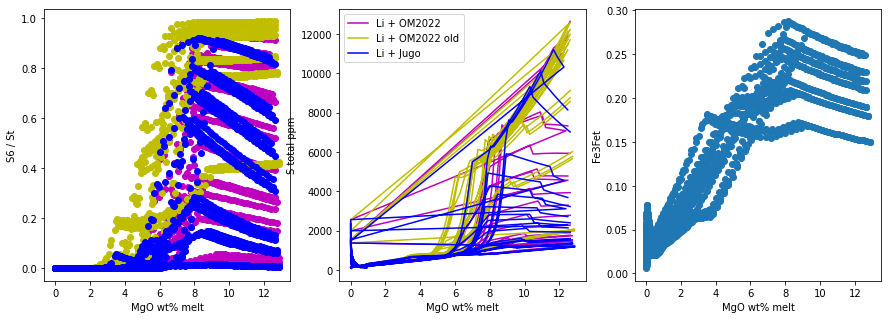

In [47]:
# Comparing S total results and S6+/St from different models

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

x = empty_index['MgO_Liq']
# smythe and oneill
#Stot_1 = df_ST_S2017_OM2022['Total_S']
#S6St_1 = df_ST_S2017_OM2022['S6_St']
#ax1.scatter(x,S6St_1)
#ax2.plot(x,Stot_1,label='S2017 + OM2022')
#smythe and nash
#Stot_2 = S2017_ST_Nash['Total_S']
#S6St_2 = S2017_ST_Nash['S6_St']
#ax1.scatter(x,S6St_2,c='c')
#ax2.plot(x,Stot_2,c='c',label='S2017 + Nash')

#lizhang and oneill
Stot_3 = df_ST_OM2022['Total_S_ppm']
S6St_3 = df_ST_OM2022['S6St_Liq']
ax1.scatter(x,S6St_3,c='m')
ax2.plot(x,Stot_3,c='m',label='Li + OM2022')
# lizhang and oneill old paramters
Stot_4 = df_ST_OM2022_fromFe3['Total_S_ppm']
S6St_4 = df_ST_OM2022_fromFe3['S6St_Liq']
ax1.scatter(x,S6St_4,c='y')
ax2.plot(x,Stot_4,c='y', label='Li + OM2022 old')

#li zhang and Jugo
Stot_5 = LiZha_ST_Jugo['Total_S_ppm']
S6St_5 = LiZha_ST_Jugo['S6St_Liq']
ax1.scatter(x,S6St_5,c='b')
ax2.plot(x,Stot_5,c='b', label='Li + Jugo')

ax3.scatter(x,empty_index['Fe3Fet_Liq'])

ax2.set_ylabel('S total ppm')
ax1.set_ylabel('S6 / St')
ax3.set_ylabel('Fe3Fet')
ax1.set_xlabel('MgO wt% melt')
ax2.set_xlabel('MgO wt% melt')
ax3.set_xlabel('MgO wt% melt')
ax2.legend()


KeyError: 'Calc SCAS (ppm)'

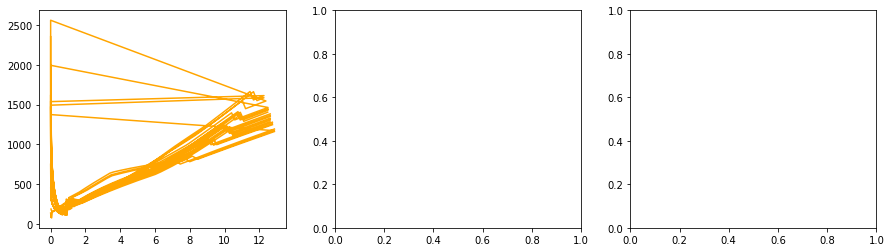

In [50]:
# Plotting for Li and Zhang:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

ax1.plot(empty_index['MgO_Liq'], LiZhang22['SCSS_Tot'],color='orange')
ax1.plot(empty_index['MgO_Liq'], ZT22_SCAS['Calc SCAS (ppm)'])
ax1.plot(empty_index['MgO_Liq'], LiZha_ST_Nash['SCSS_Tot'],color='magenta')
ax1.plot(empty_index['MgO_Liq'], LiZha_ST_Nash['Total_S'],color='k')

ax2.plot(empty_index['MgO_Liq'], LiZha_ST_Nash['SCSS_2'],color='orange')
ax2.plot(empty_index['MgO_Liq'], LiZha_ST_Nash['SCAS_6'])
ax2.plot(empty_index['MgO_Liq'], LiZha_ST_Nash['SCSS_Tot'],color='magenta')
ax2.plot(empty_index['MgO_Liq'], LiZha_ST_Nash['Total_S'],color='k')

ax3.plot(empty_index['MgO_Liq'], LiZha_ST_Nash['Total_S'],color='k')
ax3.plot(empty_index['MgO_Liq'], ONeill_ST_Nash['Total_S'],color='c')
ax3.plot(empty_index['MgO_Liq'], S2017_ST_Nash['Total_S'],color='m')

In [51]:
# add data to masterframe

empty_index['DeltaQFM_OM'] = calcS_OM2022_Givenfo2['deltaQFM_calc']
empty_index['DeltaQFM_OM_fromFe3'] = calcS_OM2022_GivenFe3['deltaQFM_calc']
empty_index['DeltaQFM_JUGO'] = buffers['deltaQFM_Frost1991']

empty_index['S_total_lizOM'] = df_ST_OM2022['Total_S_ppm']
empty_index['S_total_lizOM_fromFe3'] = df_ST_OM2022_fromFe3['Total_S_ppm']
empty_index['S_total_lizJUGO'] = LiZha_ST_Jugo['Total_S_ppm']

empty_index['S6St_lizOM'] = df_ST_OM2022['S6St_Liq']
empty_index['S6St_lizOM_fromFe3'] = df_ST_OM2022_fromFe3['S6St_Liq']
empty_index['S6St_lizJUGO'] = LiZha_ST_Jugo['S6St_Liq']

SCSS=LiZhang22['SCSS_Tot']
SCAS=ZT22_SCAS['Calc SCAS (ppm)']

KeyError: 'Calc SCAS (ppm)'

Text(0.5, 0, 'ΔQFM')

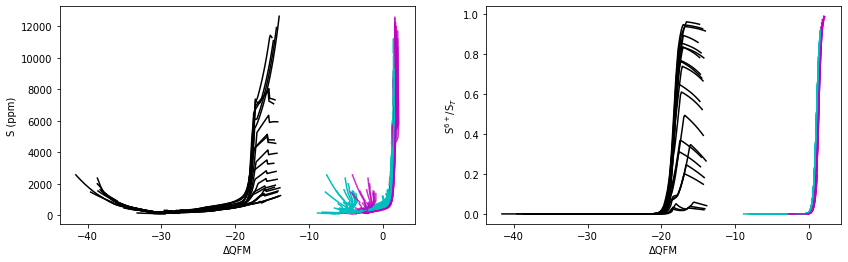

In [52]:
#plt.scatter(df_ST_OM2022['Total_S'],empty_index['Fe3Fet_Liq'],color='k')
#plt.scatter(calc_fo2['DeltaQFM'],df_ST_OM2022['Total_S'],color='k')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
for i in empty_index.unique.unique():
    x = empty_index[empty_index.unique ==i]
    
    ax1.plot(x['DeltaQFM_OM'],x['S_total_lizOM'], c='k',label=i)
    ax1.plot(x['DeltaQFM_JUGO'],x['S_total_lizJUGO'],c='c', label=i)
    ax1.plot(x['DeltaQFM_OM_fromFe3'],x['S_total_lizOM_fromFe3'],c='m',alpha=0.8, label=i)
    
    ax2.plot(x['DeltaQFM_OM'],x['S6St_lizOM'], c='k',label='S$^{6}$/$_{T}$')
    ax2.plot(x['DeltaQFM_JUGO'],x['S6St_lizJUGO'],c='c', label='S$^{6}$/$_{T}$')
    ax2.plot(x['DeltaQFM_OM_fromFe3'],x['S6St_lizOM_fromFe3'],c='m',alpha=0.8, label='S$^{6}$/$_{T}$')
    
ax1.set_ylabel('S (ppm)')
ax2.set_ylabel('S$^{6+}$/S$_{T}$')
ax1.set_xlabel('ΔQFM')
ax2.set_xlabel('ΔQFM')
#ax2.set_xlim(-1,2)
#ax1.set_xlim(-1,2)

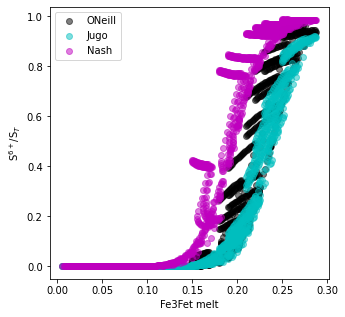

In [53]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))

ax1.scatter(empty_index['Fe3Fet_Liq'],empty_index['S6St_lizOM'], c='k',alpha=0.5,label='ONeill')
ax1.scatter(empty_index['Fe3Fet_Liq'],empty_index['S6St_lizJUGO'],c='c',alpha=0.5, label='Jugo')
ax1.scatter(empty_index['Fe3Fet_Liq'],empty_index['S6St_lizOM_fromFe3'],c='m',alpha=0.5, label='Nash')
ax1.set_ylabel('S$^{6+}$/S$_{T}$')
ax1.set_xlabel('Fe3Fet melt')
ax1.legend()

In [54]:
df_Species = LiZha_ST_Nash.copy()
df_Species['MgO_Liq'] = empty_index['MgO_Liq']

KeyError: 'SCAS_6'

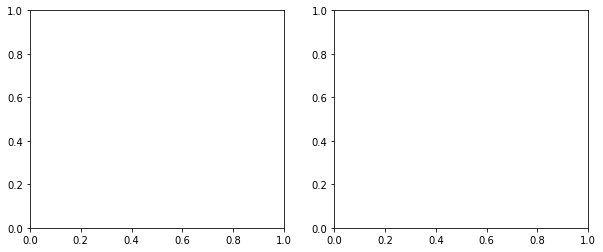

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
SCSS_Tot_excessS6=df_Species['S6 in SCSS_Tot']>df_Species['SCAS_6']

ax1.plot(df_Species['MgO_Liq'].loc[~SCSS_Tot_excessS6],
         df_Species['SCSS_Tot'].loc[~SCSS_Tot_excessS6], '-m', label='SCSS Tot')

ax1.plot(df_Species['MgO_Liq'].loc[SCSS_Tot_excessS6],
         df_Species['SCSS_Tot'].loc[SCSS_Tot_excessS6], ':m')

SCAS_Tot_excessS2=df_Species['S2 in SCAS_Tot']>df_Species['SCSS_2']

ax1.plot(df_Species['MgO_Liq'].loc[~SCAS_Tot_excessS2],
         df_Species['SCAS_Tot'].loc[~SCAS_Tot_excessS2], '-k', label='SCAS_Tot')
ax1.plot(df_Species['MgO_Liq'].loc[SCAS_Tot_excessS2],
         df_Species['SCAS_Tot'].loc[SCAS_Tot_excessS2], ':k')

#ax1.plot([-1, 3], [SCSS, SCSS], '-m', lw=0.5, label='S2- sol limit')
#ax1.plot([-1, 3], [SCAS, SCAS], '-k', lw=0.5, label='S6 sol limit')
#ax1.plot([-1, 3], [SCAS+SCSS, SCAS+SCSS], '-g', lw=0.5, label='ST sol limit')

maxS=SCSS+SCAS
maxX=df_Species['MgO_Liq'].loc[df_Species['Total_S']==maxS]
ax2.plot(df_Species['MgO_Liq'], df_Species['Total_S'], '-g', lw=2, label='Total S')

ax2.yaxis.set_tick_params(which='both', labelbottom=True)
ax2b=ax2.twinx()
ax2.plot(df_Species['MgO_Liq'], df_Species['S2_Tot'], '-r', lw=0.5, label='S$^{2}$')
ax2.plot(df_Species['MgO_Liq'], df_Species['S6_Tot'], '-', color='grey', lw=0.5, label='S$^{6}$')

ax2b.plot(df_Species['MgO_Liq'], df_Species['S6_St'], '-c', label='S$^{6}$/$_{T}$')

ax2b.plot([maxX, maxX], [0, 1], ':c')
ax1.set_ylim([0, 10000])
ax2.set_ylim([0, 10000])
ax2b.set_ylim([0, 1])
ax1.set_ylabel('S (ppm)')
ax2.set_ylabel('S (ppm)')
ax1.set_xlabel('MgO')
ax2.set_xlabel('MgO')
ax2b.set_ylabel('S$^{6+}$/S$_{T}$')
fig.tight_layout()

In [55]:
empty_index['SCAS']=ZT22_SCAS['SCAS6_ppm']
empty_index['SCSS_Tot'] = LiZhang22['SCSS_Tot']

### Part 7: Calculating Phase Proportions

In [84]:
empty_index.head()

,index,T_C,P_bar,h,s,v,dvdp,logfO2,SiO2_Liq,TiO2_Liq,...,DeltaQFM_OM_fromFe3,DeltaQFM_JUGO,S_total_lizOM,S_total_lizOM_fromFe3,S_total_lizJUGO,S6St_lizOM,S6St_lizOM_fromFe3,S6St_lizJUGO,SCAS,SCSS_Tot
0,0,1327.800000,2000,-1.193948e+06,280.458347,36.866371,-0.000184,-6.786149,48.947950,0.686465,...,0.928066,0.017381,1244.654887,2084.147309,1203.524517,0.041105,0.427347,0.008334,14338.942883,1193.493952
1,1,1322.817460,2000,-1.195006e+06,279.796338,36.839937,-0.000174,-6.825411,48.997428,0.690543,...,0.931315,0.026630,1228.779944,2048.554125,1187.503666,0.041990,0.425359,0.008691,13906.964588,1177.183116
2,2,1317.834921,2000,-1.188616e+06,277.640382,36.629273,-0.000174,-6.864994,49.046880,0.694606,...,0.934665,0.035861,1213.005998,2013.802549,1171.594350,0.042892,0.423490,0.009062,13490.915532,1160.977360
3,3,1312.852381,2000,-1.182315e+06,275.512322,36.421566,-0.000173,-6.904941,49.096118,0.698638,...,0.938104,0.045035,1197.352148,1979.874997,1155.822483,0.043803,0.421729,0.009446,13090.628678,1144.904322
4,4,1307.869841,2000,-1.176149e+06,273.420621,36.217875,-0.000173,-6.945255,49.145142,0.702639,...,0.941633,0.054152,1181.818542,1946.749862,1140.188345,0.044723,0.420077,0.009844,12705.343793,1128.964298


In [85]:
keepcols = empty_index.columns[empty_index.columns.str.contains('_Liq|pressure_bar|T_C|newcolumn')]
keep_ol_liq = empty_index.columns[empty_index.columns.str.contains('_Liq|pressure_bar|T_C|newcolumn|_Ol')]

In [86]:
slicedat = empty_index[keepcols]
Fo_Mg_MELTS = empty_index[keep_ol_liq]
#Fo_Mg_MELTS.to_excel('Fo_Mg_MELTS.xlsx') #to be worked on in MELTS versus EPMA Olivine-melt equilibria.ipynb

In [87]:
mass_cols = empty_index.columns[empty_index.columns.str.contains('index|mass|unique')]
syst_mass = empty_index[mass_cols]
syst_mass

,index,mass_Liq,mass_Ol,mass_Cpx,mass_Plag,mass_Sp,mass_whitlockite1,mass_Apa,dictindex,mass_Sp2,mass_Cpx2,mass_fluid1,mass_rutile1,mass_Kspar,mass_leucite1,mass_Rhm,mass_tridymite1,unique
0,0,100.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,index = 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P_2000.0_H2O_0.1_buff_0.15
1,1,99.409411,0.590589,0.000000,0.0,0.0,0.0,0.000000,index = 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P_2000.0_H2O_0.1_buff_0.15
2,2,98.827986,0.582905,0.000000,0.0,0.0,0.0,0.000000,index = 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P_2000.0_H2O_0.1_buff_0.15
3,3,98.257667,0.571799,0.000000,0.0,0.0,0.0,0.000000,index = 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P_2000.0_H2O_0.1_buff_0.15
4,4,97.698188,0.560960,0.000000,0.0,0.0,0.0,0.000000,index = 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P_2000.0_H2O_0.1_buff_0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086,94,11.168573,0.000000,0.035404,0.0,0.0,NaN,0.009264,index = 6,NaN,NaN,0.006166,0.001911,0.220014,NaN,NaN,0.000000,P_500.0_H2O_6.0_buff_0.25
2087,95,10.924879,0.000000,0.034547,0.0,0.0,NaN,0.008806,index = 6,NaN,NaN,0.005730,0.001814,0.203996,NaN,NaN,0.000000,P_500.0_H2O_6.0_buff_0.25
2088,96,10.695735,0.000000,0.034733,0.0,0.0,NaN,0.008389,index = 6,NaN,NaN,0.005387,0.001725,0.190116,NaN,NaN,0.000000,P_500.0_H2O_6.0_buff_0.25
2089,97,10.407267,0.000000,0.040921,0.0,0.0,NaN,0.009620,index = 6,NaN,NaN,0.006982,0.001716,0.207352,NaN,NaN,0.033088,P_500.0_H2O_6.0_buff_0.25


In [88]:
column_to_move = syst_mass.pop("mass_fluid1") #put fluid as the final phase mass column
syst_mass.insert(16, "mass_fluid1", column_to_move)
syst_mass.head()

,index,mass_Liq,mass_Ol,mass_Cpx,mass_Plag,mass_Sp,mass_whitlockite1,mass_Apa,dictindex,mass_Sp2,mass_Cpx2,mass_rutile1,mass_Kspar,mass_leucite1,mass_Rhm,mass_tridymite1,mass_fluid1,unique
0,0,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,index = 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P_2000.0_H2O_0.1_buff_0.15
1,1,99.409411,0.590589,0.0,0.0,0.0,0.0,0.0,index = 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P_2000.0_H2O_0.1_buff_0.15
2,2,98.827986,0.582905,0.0,0.0,0.0,0.0,0.0,index = 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P_2000.0_H2O_0.1_buff_0.15
3,3,98.257667,0.571799,0.0,0.0,0.0,0.0,0.0,index = 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P_2000.0_H2O_0.1_buff_0.15
4,4,97.698188,0.560960,0.0,0.0,0.0,0.0,0.0,index = 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P_2000.0_H2O_0.1_buff_0.15


In [89]:
syst_mass.iloc[:,2:17] #should be starting with mass_ol to the end including unique

,mass_Ol,mass_Cpx,mass_Plag,mass_Sp,mass_whitlockite1,mass_Apa,dictindex,mass_Sp2,mass_Cpx2,mass_rutile1,mass_Kspar,mass_leucite1,mass_Rhm,mass_tridymite1,mass_fluid1
0,0.000000,0.000000,0.0,0.0,0.0,0.000000,index = 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.590589,0.000000,0.0,0.0,0.0,0.000000,index = 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.582905,0.000000,0.0,0.0,0.0,0.000000,index = 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.571799,0.000000,0.0,0.0,0.0,0.000000,index = 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.560960,0.000000,0.0,0.0,0.0,0.000000,index = 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086,0.000000,0.035404,0.0,0.0,NaN,0.009264,index = 6,NaN,NaN,0.001911,0.220014,NaN,NaN,0.000000,0.006166
2087,0.000000,0.034547,0.0,0.0,NaN,0.008806,index = 6,NaN,NaN,0.001814,0.203996,NaN,NaN,0.000000,0.005730
2088,0.000000,0.034733,0.0,0.0,NaN,0.008389,index = 6,NaN,NaN,0.001725,0.190116,NaN,NaN,0.000000,0.005387
2089,0.000000,0.040921,0.0,0.0,NaN,0.009620,index = 6,NaN,NaN,0.001716,0.207352,NaN,NaN,0.033088,0.006982


In [90]:
# the mass crystallising at each step. 
cumulate_phase_mass = syst_mass.iloc[:,2:17].sum(axis=1)
cumulate_phase_mass

0       0.000000
1       0.590589
2       0.582905
3       0.571799
4       0.560960
          ...   
2086    0.272760
2087    0.254893
2088    0.240350
2089    0.299680
2090    0.000000
Length: 2091, dtype: float64

In [91]:
syst_mass = syst_mass.fillna(0)

In [92]:
syst_mass.columns[2:18] # we want column range starting with first phase to the end e.g. mass_Ol

Index(['mass_Ol', 'mass_Cpx', 'mass_Plag', 'mass_Sp', 'mass_whitlockite1',
       'mass_Apa', 'dictindex', 'mass_Sp2', 'mass_Cpx2', 'mass_rutile1',
       'mass_Kspar', 'mass_leucite1', 'mass_Rhm', 'mass_tridymite1',
       'mass_fluid1', 'unique'],
      dtype='object')

In [93]:
# Calculate cumulative masses of solid phases, exlcuding index column 
for i in syst_mass.columns[2:17]:
    syst_mass[i + '_cumulative'] = syst_mass.groupby('unique')[i].transform(pd.Series.cumsum)

syst_mass[syst_mass.columns[17:]]

,unique,mass_Ol_cumulative,mass_Cpx_cumulative,mass_Plag_cumulative,mass_Sp_cumulative,mass_whitlockite1_cumulative,mass_Apa_cumulative,dictindex_cumulative,mass_Sp2_cumulative,mass_Cpx2_cumulative,mass_rutile1_cumulative,mass_Kspar_cumulative,mass_leucite1_cumulative,mass_Rhm_cumulative,mass_tridymite1_cumulative,mass_fluid1_cumulative
0,P_2000.0_H2O_0.1_buff_0.15,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,index = 0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,P_2000.0_H2O_0.1_buff_0.15,0.590589,0.000000,0.000000,0.000000,0.0,0.000000,index = 0index = 0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,P_2000.0_H2O_0.1_buff_0.15,1.173494,0.000000,0.000000,0.000000,0.0,0.000000,index = 0index = 0index = 0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,P_2000.0_H2O_0.1_buff_0.15,1.745292,0.000000,0.000000,0.000000,0.0,0.000000,index = 0index = 0index = 0index = 0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,P_2000.0_H2O_0.1_buff_0.15,2.306252,0.000000,0.000000,0.000000,0.0,0.000000,index = 0index = 0index = 0index = 0index = 0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086,P_500.0_H2O_6.0_buff_0.25,20.390059,28.127961,29.013771,3.813505,0.0,0.416929,index = 6index = 6index = 6index = 6index = 6i...,0.0,0.0,0.074290,2.497829,0.0,0.0,0.000000,5.295840
2087,P_500.0_H2O_6.0_buff_0.25,20.390059,28.162508,29.013771,3.813505,0.0,0.425735,index = 6index = 6index = 6index = 6index = 6i...,0.0,0.0,0.076104,2.701825,0.0,0.0,0.000000,5.301570
2088,P_500.0_H2O_6.0_buff_0.25,20.390059,28.197241,29.013771,3.813505,0.0,0.434124,index = 6index = 6index = 6index = 6index = 6i...,0.0,0.0,0.077829,2.891940,0.0,0.0,0.000000,5.306957
2089,P_500.0_H2O_6.0_buff_0.25,20.390059,28.238162,29.013771,3.813505,0.0,0.443745,index = 6index = 6index = 6index = 6index = 6i...,0.0,0.0,0.079545,3.099292,0.0,0.0,0.033088,5.313939


In [94]:
syst_mass[syst_mass.columns[18:33]].head() #select just the columns with mass_'phase'_cumulative, no Liq or unique

,mass_Ol_cumulative,mass_Cpx_cumulative,mass_Plag_cumulative,mass_Sp_cumulative,mass_whitlockite1_cumulative,mass_Apa_cumulative,dictindex_cumulative,mass_Sp2_cumulative,mass_Cpx2_cumulative,mass_rutile1_cumulative,mass_Kspar_cumulative,mass_leucite1_cumulative,mass_Rhm_cumulative,mass_tridymite1_cumulative,mass_fluid1_cumulative
0,0.000000,0.0,0.0,0.0,0.0,0.0,index = 0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.590589,0.0,0.0,0.0,0.0,0.0,index = 0index = 0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.173494,0.0,0.0,0.0,0.0,0.0,index = 0index = 0index = 0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.745292,0.0,0.0,0.0,0.0,0.0,index = 0index = 0index = 0index = 0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.306252,0.0,0.0,0.0,0.0,0.0,index = 0index = 0index = 0index = 0index = 0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
# mass of all solid phases + fluid 
syst_mass['mass_allphase_cumulative'] = syst_mass[syst_mass.columns[18:33]].sum(axis=1)
# mass of all solid phases + fluid + liq
syst_mass['mass_syst_unormtot'] = syst_mass['mass_allphase_cumulative'] + syst_mass['mass_Liq']

In [96]:
# Alternative Calc
# mass of all solid phases +NO fluid 
syst_mass['mass_solidphase_cumulative'] = syst_mass[syst_mass.columns[18:22]].sum(axis=1)
# mass of all solid phases + liq
syst_mass['mass_nosol_syst_unormtot'] = syst_mass['mass_solidphase_cumulative'] + syst_mass['mass_Liq']

In [97]:
syst_mass[['mass_allphase_cumulative','mass_syst_unormtot', 'mass_solidphase_cumulative','mass_nosol_syst_unormtot']]

,mass_allphase_cumulative,mass_syst_unormtot,mass_solidphase_cumulative,mass_nosol_syst_unormtot
0,0.000000,100.000000,0.000000,100.000000
1,0.590589,100.000000,0.590589,100.000000
2,1.173494,100.001479,1.173494,100.001479
3,1.745292,100.002959,1.745292,100.002959
4,2.306252,100.004441,2.306252,100.004441
...,...,...,...,...
2086,89.630184,100.798758,81.345297,92.513870
2087,89.885077,100.809957,81.379844,92.304723
2088,90.125427,100.821162,81.414577,92.110312
2089,90.425107,100.832374,81.455498,91.862765


In [98]:
syst_mass[syst_mass.columns[18:]].head()

,mass_Ol_cumulative,mass_Cpx_cumulative,mass_Plag_cumulative,mass_Sp_cumulative,mass_whitlockite1_cumulative,mass_Apa_cumulative,dictindex_cumulative,mass_Sp2_cumulative,mass_Cpx2_cumulative,mass_rutile1_cumulative,mass_Kspar_cumulative,mass_leucite1_cumulative,mass_Rhm_cumulative,mass_tridymite1_cumulative,mass_fluid1_cumulative,mass_allphase_cumulative,mass_syst_unormtot,mass_solidphase_cumulative,mass_nosol_syst_unormtot
0,0.000000,0.0,0.0,0.0,0.0,0.0,index = 0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,100.000000,0.000000,100.000000
1,0.590589,0.0,0.0,0.0,0.0,0.0,index = 0index = 0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.590589,100.000000,0.590589,100.000000
2,1.173494,0.0,0.0,0.0,0.0,0.0,index = 0index = 0index = 0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.173494,100.001479,1.173494,100.001479
3,1.745292,0.0,0.0,0.0,0.0,0.0,index = 0index = 0index = 0index = 0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.745292,100.002959,1.745292,100.002959
4,2.306252,0.0,0.0,0.0,0.0,0.0,index = 0index = 0index = 0index = 0index = 0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.306252,100.004441,2.306252,100.004441


In [99]:
# move column containing strings to the first column
# col = syst_mass.pop('unique_cumulative')
# syst_mass.insert(0, 'unique_cumulative', col)

# move column mass_Liq next to the cumualtive columns - position may change based on number of phases 
col = syst_mass.pop('mass_Liq')
syst_mass.insert(17, 'mass_Liq', col)


In [101]:

# drop mass_Liq_cumulative column since it is meaningless if havent done already
#syst_mass = syst_mass.drop(['mass_Liq_cumulative'], axis=1)
#drop index and unique cumulative
syst_mass = syst_mass.drop([ 'dictindex_cumulative'], axis=1) #'unique_cumulative',


In [102]:
syst_mass.columns[17:]
syst_mass[syst_mass.columns[17:32]].tail()

,mass_Liq,mass_Ol_cumulative,mass_Cpx_cumulative,mass_Plag_cumulative,mass_Sp_cumulative,mass_whitlockite1_cumulative,mass_Apa_cumulative,mass_Sp2_cumulative,mass_Cpx2_cumulative,mass_rutile1_cumulative,mass_Kspar_cumulative,mass_leucite1_cumulative,mass_Rhm_cumulative,mass_tridymite1_cumulative,mass_fluid1_cumulative
2086,11.168573,20.390059,28.127961,29.013771,3.813505,0.0,0.416929,0.0,0.0,0.074290,2.497829,0.0,0.0,0.000000,5.295840
2087,10.924879,20.390059,28.162508,29.013771,3.813505,0.0,0.425735,0.0,0.0,0.076104,2.701825,0.0,0.0,0.000000,5.301570
2088,10.695735,20.390059,28.197241,29.013771,3.813505,0.0,0.434124,0.0,0.0,0.077829,2.891940,0.0,0.0,0.000000,5.306957
2089,10.407267,20.390059,28.238162,29.013771,3.813505,0.0,0.443745,0.0,0.0,0.079545,3.099292,0.0,0.0,0.033088,5.313939
2090,0.000000,20.390059,28.238162,29.013771,3.813505,0.0,0.443745,0.0,0.0,0.079545,3.099292,0.0,0.0,0.033088,5.313939


In [103]:
# Normalise masses to total 100
#from liq_mass to final mass_'phase'_cumulative (fluid1)
for i in syst_mass.columns[17:32]:
    syst_mass[i + '_NORM'] = (syst_mass[i] * 100) / (syst_mass['mass_syst_unormtot'])
syst_mass.columns[32:]

Index(['mass_allphase_cumulative', 'mass_syst_unormtot',
       'mass_solidphase_cumulative', 'mass_nosol_syst_unormtot',
       'mass_Liq_NORM', 'mass_Ol_cumulative_NORM', 'mass_Cpx_cumulative_NORM',
       'mass_Plag_cumulative_NORM', 'mass_Sp_cumulative_NORM',
       'mass_whitlockite1_cumulative_NORM', 'mass_Apa_cumulative_NORM',
       'mass_Sp2_cumulative_NORM', 'mass_Cpx2_cumulative_NORM',
       'mass_rutile1_cumulative_NORM', 'mass_Kspar_cumulative_NORM',
       'mass_leucite1_cumulative_NORM', 'mass_Rhm_cumulative_NORM',
       'mass_tridymite1_cumulative_NORM', 'mass_fluid1_cumulative_NORM'],
      dtype='object')

In [104]:
syst_mass[syst_mass.columns[36:]].tail()

,mass_Liq_NORM,mass_Ol_cumulative_NORM,mass_Cpx_cumulative_NORM,mass_Plag_cumulative_NORM,mass_Sp_cumulative_NORM,mass_whitlockite1_cumulative_NORM,mass_Apa_cumulative_NORM,mass_Sp2_cumulative_NORM,mass_Cpx2_cumulative_NORM,mass_rutile1_cumulative_NORM,mass_Kspar_cumulative_NORM,mass_leucite1_cumulative_NORM,mass_Rhm_cumulative_NORM,mass_tridymite1_cumulative_NORM,mass_fluid1_cumulative_NORM
2086,11.080070,20.228483,27.905067,28.783858,3.783286,0.0,0.413625,0.0,0.0,0.073701,2.478035,0.0,0.0,0.000000,5.253874
2087,10.837104,20.226236,27.936236,28.780660,3.782866,0.0,0.422314,0.0,0.0,0.075493,2.680117,0.0,0.0,0.000000,5.258974
2088,10.608621,20.223987,27.967582,28.777462,3.782445,0.0,0.430589,0.0,0.0,0.077195,2.868386,0.0,0.0,0.000000,5.263733
2089,10.321355,20.221739,28.005055,28.774262,3.782025,0.0,0.440082,0.0,0.0,0.078888,3.073707,0.0,0.0,0.032815,5.270072
2090,0.000000,22.549113,31.228232,32.085969,4.217308,0.0,0.490732,0.0,0.0,0.087968,3.427468,0.0,0.0,0.036592,5.876619


In [105]:
syst_mass[syst_mass.columns[36:]].sum(axis=1) #check all liq and phases norm sum to 100

0       100.0
1       100.0
2       100.0
3       100.0
4       100.0
        ...  
2086    100.0
2087    100.0
2088    100.0
2089    100.0
2090    100.0
Length: 2091, dtype: float64

In [106]:
syst_mass[syst_mass.columns[37:]].head()

,mass_Ol_cumulative_NORM,mass_Cpx_cumulative_NORM,mass_Plag_cumulative_NORM,mass_Sp_cumulative_NORM,mass_whitlockite1_cumulative_NORM,mass_Apa_cumulative_NORM,mass_Sp2_cumulative_NORM,mass_Cpx2_cumulative_NORM,mass_rutile1_cumulative_NORM,mass_Kspar_cumulative_NORM,mass_leucite1_cumulative_NORM,mass_Rhm_cumulative_NORM,mass_tridymite1_cumulative_NORM,mass_fluid1_cumulative_NORM
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.590589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.173476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.745241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.306150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
# written to include fluid in normalisation
# seperate calc for **mass_allphase_NORMcumulative** i.e. excluding the liq_cumunorm mass
# careful rerunning cell as will give false result
syst_mass['mass_allphase_NORMcumu'] = syst_mass[syst_mass.columns[37:]].sum(axis=1)


In [109]:
syst_mass[syst_mass.columns[37:51]].head() #range of cumulative_norm mass phases

,mass_Ol_cumulative_NORM,mass_Cpx_cumulative_NORM,mass_Plag_cumulative_NORM,mass_Sp_cumulative_NORM,mass_whitlockite1_cumulative_NORM,mass_Apa_cumulative_NORM,mass_Sp2_cumulative_NORM,mass_Cpx2_cumulative_NORM,mass_rutile1_cumulative_NORM,mass_Kspar_cumulative_NORM,mass_leucite1_cumulative_NORM,mass_Rhm_cumulative_NORM,mass_tridymite1_cumulative_NORM,mass_fluid1_cumulative_NORM
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.590589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.173476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.745241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.306150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
# solid only
syst_mass['mass_solidphase_NORMcumu'] = syst_mass[syst_mass.columns[37:50]].sum(axis=1)

In [111]:
syst_mass[syst_mass.columns[37:50]] #range of solid phases no fluid

,mass_Ol_cumulative_NORM,mass_Cpx_cumulative_NORM,mass_Plag_cumulative_NORM,mass_Sp_cumulative_NORM,mass_whitlockite1_cumulative_NORM,mass_Apa_cumulative_NORM,mass_Sp2_cumulative_NORM,mass_Cpx2_cumulative_NORM,mass_rutile1_cumulative_NORM,mass_Kspar_cumulative_NORM,mass_leucite1_cumulative_NORM,mass_Rhm_cumulative_NORM,mass_tridymite1_cumulative_NORM
0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
1,0.590589,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
2,1.173476,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
3,1.745241,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
4,2.306150,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086,20.228483,27.905067,28.783858,3.783286,0.0,0.413625,0.0,0.0,0.073701,2.478035,0.0,0.0,0.000000
2087,20.226236,27.936236,28.780660,3.782866,0.0,0.422314,0.0,0.0,0.075493,2.680117,0.0,0.0,0.000000
2088,20.223987,27.967582,28.777462,3.782445,0.0,0.430589,0.0,0.0,0.077195,2.868386,0.0,0.0,0.000000
2089,20.221739,28.005055,28.774262,3.782025,0.0,0.440082,0.0,0.0,0.078888,3.073707,0.0,0.0,0.032815


In [112]:
# where ppn 1 refers to proportion of phases (solid + NO fluid1) excluding sulfide
# need columns from first and last phase_cumulative_norm masses - test search using cell above

for i in syst_mass.columns[37:50]:
    syst_mass[i + '_ppn1'] = (syst_mass[i]) / (syst_mass['mass_solidphase_NORMcumu'])


In [115]:
syst_mass[syst_mass.columns[53:]].head()

,mass_Ol_cumulative_NORM_ppn1,mass_Cpx_cumulative_NORM_ppn1,mass_Plag_cumulative_NORM_ppn1,mass_Sp_cumulative_NORM_ppn1,mass_whitlockite1_cumulative_NORM_ppn1,mass_Apa_cumulative_NORM_ppn1,mass_Sp2_cumulative_NORM_ppn1,mass_Cpx2_cumulative_NORM_ppn1,mass_rutile1_cumulative_NORM_ppn1,mass_Kspar_cumulative_NORM_ppn1,mass_leucite1_cumulative_NORM_ppn1,mass_Rhm_cumulative_NORM_ppn1,mass_tridymite1_cumulative_NORM_ppn1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
mass_solidphase_NORMcumu_ppn1 = syst_mass[syst_mass.columns[53:]].sum(axis=1)

In [119]:
mass_solidphase_NORMcumu_ppn1.unique()

array([0., 1., 1., 1., 1., 1., 1., 1.])

In [120]:
# mass_allphase_Normcumu_ppn1 1 should all be = 1 if calc correct
syst_mass['mass_solidphase_NORMcumu_ppn1'] = syst_mass['mass_solidphase_NORMcumu'] / syst_mass['mass_solidphase_NORMcumu']
syst_mass['mass_solidphase_NORMcumu_ppn1']

0       NaN
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2086    1.0
2087    1.0
2088    1.0
2089    1.0
2090    1.0
Name: mass_solidphase_NORMcumu_ppn1, Length: 2091, dtype: float64

In [121]:
# Treating Fluid as seperate system - March 2023
# Set Fluid proportion to 0 or 1 depending on whether fluid is present or not
syst_mass['mass_fluid1_cumulative_NORM_ppn1'] = syst_mass['mass_fluid1_cumulative_NORM']/syst_mass['mass_fluid1_cumulative_NORM']
syst_mass['mass_fluid1_cumulative_NORM_ppn1'] = syst_mass['mass_fluid1_cumulative_NORM_ppn1'].fillna(0)
syst_mass[syst_mass.columns[53:]].head()

,mass_Ol_cumulative_NORM_ppn1,mass_Cpx_cumulative_NORM_ppn1,mass_Plag_cumulative_NORM_ppn1,mass_Sp_cumulative_NORM_ppn1,mass_whitlockite1_cumulative_NORM_ppn1,mass_Apa_cumulative_NORM_ppn1,mass_Sp2_cumulative_NORM_ppn1,mass_Cpx2_cumulative_NORM_ppn1,mass_rutile1_cumulative_NORM_ppn1,mass_Kspar_cumulative_NORM_ppn1,mass_leucite1_cumulative_NORM_ppn1,mass_Rhm_cumulative_NORM_ppn1,mass_tridymite1_cumulative_NORM_ppn1,mass_solidphase_NORMcumu_ppn1,mass_fluid1_cumulative_NORM_ppn1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Modeling Sulfur

In [122]:
syst_mass['DeltaQFM_OMbuff'] = calcS_OM2022_Givenfo2['deltaQFM_calc']
syst_mass['DeltaQFM_OM_fromFe3'] = calcS_OM2022_GivenFe3['deltaQFM_calc']
syst_mass['DeltaQFM_JUGO'] = buffers['deltaQFM_Frost1991']
syst_mass['DeltaQFM_frostbuff'] = buffers['deltaQFM_Frost1991']

syst_mass['S_total_lizOM'] = df_ST_OM2022['Total_S_ppm']
syst_mass['S_total_lizOM_fromFe3'] = df_ST_OM2022_fromFe3['Total_S_ppm']
syst_mass['S_total_lizJUGO'] = LiZha_ST_Jugo['Total_S_ppm']

syst_mass['S6St_lizOM'] = df_ST_OM2022['S6St_Liq']
syst_mass['S6St_lizOM_fromFe3'] = df_ST_OM2022_fromFe3['S6St_Liq']
syst_mass['S6St_lizJUGO'] = LiZha_ST_Jugo['S6St_Liq']

syst_mass['SCSS']=LiZhang22['SCSS_Tot']
syst_mass['SCAS']=ZT22_SCAS['SCAS6_ppm']

In [123]:
# calc melt fraction 
syst_mass['melt_f'] = (syst_mass.mass_Liq_NORM) / 100

# replace nan with 0
syst_mass = syst_mass.replace(np.nan, 0)

In [124]:
DS = np.empty(len(syst_mass), dtype=float)

S_initial = 1500 #(ppm) arc basalts globally lie within 0.1-0.2 wt% Muth and Wallace 2022

In [125]:
# not yet got an fo2 sensitive DS fluid-melt

DS_4000 = {1:3, 0.9:3, 0.8:3, 0.7:5, 0.6:8, 0.5:30, 0.4:50, 0.3:100, 0.2:200, 0.1:300, 0.0:300}

DS_2000 = {1:2, 0.9:2, 0.8:2, 0.7:5, 0.6:8, 0.5:30, 0.4:50, 0.3:100, 0.2:200, 0.1:300, 0.0:300}

DS_1600 = {1:1.1, 0.9:1.1, 0.8:1.1, 0.7:5, 0.6:8, 0.5:30, 0.4:50, 0.3:100, 0.2:200, 0.1:300, 0.0:300}

DS_800 = {1:8, 0.9:8, 0.8:8, 0.7:8, 0.6:8, 0.5:30, 0.4:50, 0.3:100, 0.2:200, 0.1:300, 0.0:300}

DS_dict = {'2000':DS_2000,'1000':DS_1600, '500':DS_800}

In [126]:
###### define truncate function
import math
def truncate(number, decimals=1):
    """
    Returns a value truncated to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)

    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor

In [127]:
# create extra column for melt fraction truncated to 1 dp
syst_mass['meltf_1dp1'] = 0 
meltf_1dp = []

for i in range(len(syst_mass)):
    x = syst_mass['melt_f'][i]
    syst_mass['meltf_1dp1'] = truncate(x, decimals=1)
    meltf_1dp.append(syst_mass['meltf_1dp1'].loc[i])
syst_mass['meltf_1dp1'] = meltf_1dp

In [128]:
empty = []
for key, val in DS_dict.items():
    print(key,val)
    dfnew = syst_mass[syst_mass.unique.str.contains(key)]
    
    dfnew['Dsulfur'] = dfnew['meltf_1dp1'].map(val)
    
    print(dfnew[['unique','melt_f','meltf_1dp1', 'Dsulfur']])
    
    empty.append(dfnew['Dsulfur'])
    
    flat_list = [item for sublist in empty for item in sublist]
    
    syst_mass['DS_fm'] = pd.Series(flat_list)

2000 {1: 2, 0.9: 2, 0.8: 2, 0.7: 5, 0.6: 8, 0.5: 30, 0.4: 50, 0.3: 100, 0.2: 200, 0.1: 300, 0.0: 300}
                         unique    melt_f  meltf_1dp1  Dsulfur
0    P_2000.0_H2O_0.1_buff_0.15  1.000000         1.0        2
1    P_2000.0_H2O_0.1_buff_0.15  0.994094         0.9        2
2    P_2000.0_H2O_0.1_buff_0.15  0.988265         0.9        2
3    P_2000.0_H2O_0.1_buff_0.15  0.982548         0.9        2
4    P_2000.0_H2O_0.1_buff_0.15  0.976938         0.9        2
..                          ...       ...         ...      ...
735  P_2000.0_H2O_6.0_buff_0.25  0.153349         0.1      300
736  P_2000.0_H2O_6.0_buff_0.25  0.148780         0.1      300
737  P_2000.0_H2O_6.0_buff_0.25  0.144643         0.1      300
738  P_2000.0_H2O_6.0_buff_0.25  0.140878         0.1      300
739  P_2000.0_H2O_6.0_buff_0.25  0.137436         0.1      300

[740 rows x 4 columns]
1000 {1: 1.1, 0.9: 1.1, 0.8: 1.1, 0.7: 5, 0.6: 8, 0.5: 30, 0.4: 50, 0.3: 100, 0.2: 200, 0.1: 300, 0.0: 300}
          

<ipython-input-128-968d0480f146>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfnew['Dsulfur'] = dfnew['meltf_1dp1'].map(val)
<ipython-input-128-968d0480f146>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfnew['Dsulfur'] = dfnew['meltf_1dp1'].map(val)
<ipython-input-128-968d0480f146>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [604]:
# check ordering of DS with melt frac - really important - ordered dictionary issue
#syst_mass[['DS_fm','meltf_1dp1', 'melt_f', 'unique']].to_excel('flatlist1.2.xlsx') #check htat the DS matches up, issues with dict orders
#empty[2].to_excel('clempty1.2.xlsx')

In [129]:
# Calc Bulk fluid-melt partition coeffcient of S
syst_mass['bulk_DS'] = syst_mass['DS_fm'] * syst_mass['mass_fluid1_cumulative_NORM_ppn1'] #this is 1

syst_mass['bulk_S_syst'] = S_initial / syst_mass['melt_f']

# Calc Melt S ppm concentration after fluid extracted
syst_mass['melt_S_nosulf'] = S_initial/ ((syst_mass['bulk_DS']*(1-syst_mass['melt_f'])+ syst_mass['melt_f']))

# Make new column filled with 1000 so we know if calcs have worked or not - ammend this later as not tidy
syst_mass['melt_S_sulf'] = syst_mass['melt_S_nosulf']
syst_mass['melt_S_sulf']  

0       1500.000000
1       1508.911460
2       1517.811154
3       1526.643605
4       1535.408831
           ...     
2086       5.620702
2087       5.605443
2088       5.591169
2089       5.573325
2090       5.000000
Name: melt_S_sulf, Length: 2091, dtype: float64

In [305]:
# Calc Melt S ppm for sulfide and fluid extraction
to_fill = []
u_list = syst_mass.unique.unique()

for u in u_list:
    df = syst_mass[syst_mass.unique == u]
    df = df.reset_index(drop=True)
    
    for i in range(0, len(df)):
        if syst_mass['melt_S_sulf'].loc[i] < syst_mass['S_total_lizOM_fromFe3'].loc[i]:
            syst_mass['melt_S_sulf'].loc[i] = syst_mass['melt_S_nosulf'].loc[i]
            to_fill.append(df['melt_S_sulf'].loc[i])
        
        if syst_mass['melt_S_sulf'].loc[i] >= syst_mass['S_total_lizOM_fromFe3'].loc[i]:
            syst_mass['melt_S_sulf'].loc[i] = syst_mass['S_total_lizOM_fromFe3'].loc[i]
            to_fill.append(df['melt_S_sulf'].loc[i])

print(len(to_fill)) #length of column rows

syst_mass['melt_S_sulf'] = to_fill

/Users/ollie/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


2091


##### OLD METHOD - if we wanted to force 1000 for initial step use this method. 

##### Calc Melt S ppm conc (sulfide present and fluid taken out too FC)
to_fill = []
u_list = syst_mass.unique.unique()
for u in u_list:
    df = syst_mass[syst_mass.unique == u]
    df = df.reset_index(drop=True)
    
    for i in range(0, len(df)):
        if i == 0:
            df['melt_S_sulf'] =1000.0000
            to_fill.append(df['melt_S_sulf'].loc[i])
    
    for i in range(1, len(df)):
        if df['melt_S_sulf'].loc[i-1] < df['SCSS_Oneill21'].loc[i]:
            df['melt_S_sulf'].loc[i] =  S_initial / ((df['bulk_DS'].loc[i]*(1-df['melt_f'].loc[i])+ df['melt_f'].loc[i]))
            to_fill.append(df['melt_S_sulf'].loc[i])
            
        if df.melt_S_sulf.loc[i-1] >= df['SCSS_Oneill21'].loc[i]:
            df.melt_S_sulf.loc[i] = df['SCSS_Oneill21'].loc[i] 
            to_fill.append(df['melt_S_sulf'].loc[i])
        
        #print(i,df['melt_S_sulf'].loc[i]) #prints each loop from index 1 to the end 
print(len(to_fill))

syst_mass['melt_S_sulf'] = to_fill

In [306]:
# new method - March 2023

syst_mass['fluid_S'] = syst_mass['bulk_S_syst'] - syst_mass['melt_S_nosulf']

#### OLD METHOD Calculating Fluid S ####
#syst_mass['fluid_S'] = 0            
#for i in range(0, len(syst_mass)):
#    if syst_mass['melt_S_sulf'].loc[i] < syst_mass['SCSS_Oneill21'].loc[i]:
#        syst_mass['fluid_S'].loc[i] = syst_mass['bulk_S_syst'].loc[i] - syst_mass['melt_S_sulf'].loc[i]
#    if syst_mass['melt_S_sulf'].loc[i] == syst_mass['SCSS_Oneill21'].loc[i]:
#        syst_mass['fluid_S'].loc[i] = syst_mass['bulk_S_syst'].loc[i] - syst_mass['melt_S_nosulf'].loc[i]

In [307]:
# Calculating Solid S 
# make decision on S total model used

syst_mass['solid_S'] = 0 

for i in range(0, len(syst_mass)):
        if syst_mass['melt_S_nosulf'].loc[i] < syst_mass['S_total_lizOM_fromFe3'].loc[i]:
            syst_mass['solid_S'].loc[i] = 0
        
        if syst_mass['melt_S_nosulf'].loc[i] >= syst_mass['S_total_lizOM_fromFe3'].loc[i]:
            syst_mass['solid_S'].loc[i] = syst_mass['melt_S_nosulf'].loc[i] - syst_mass['S_total_lizOM_fromFe3'].loc[i]


In [308]:
# Xsulf = proportion of sulfide
Xsulf = syst_mass.solid_S / (36 * 10000)
syst_mass['Xsulf'] = Xsulf

In [309]:
syst_mass[syst_mass.columns[53:67]].tail() #columns containing mass_'phase_norm_ppn1

,mass_Ol_cumulative_NORM_ppn1,mass_Cpx_cumulative_NORM_ppn1,mass_Plag_cumulative_NORM_ppn1,mass_Sp_cumulative_NORM_ppn1,mass_whitlockite1_cumulative_NORM_ppn1,mass_Apa_cumulative_NORM_ppn1,mass_Sp2_cumulative_NORM_ppn1,mass_Cpx2_cumulative_NORM_ppn1,mass_rutile1_cumulative_NORM_ppn1,mass_Kspar_cumulative_NORM_ppn1,mass_leucite1_cumulative_NORM_ppn1,mass_Rhm_cumulative_NORM_ppn1,mass_tridymite1_cumulative_NORM_ppn1,mass_solidphase_NORMcumu_ppn1
2086,0.241776,0.333529,0.344033,0.045219,0.0,0.004944,0.0,0.0,0.000881,0.029618,0.0,0.0,0.000000,1.0
2087,0.241064,0.332955,0.343019,0.045086,0.0,0.005033,0.0,0.0,0.000900,0.031943,0.0,0.0,0.000000,1.0
2088,0.240396,0.332442,0.342069,0.044961,0.0,0.005118,0.0,0.0,0.000918,0.034096,0.0,0.0,0.000000,1.0
2089,0.239570,0.331780,0.340893,0.044806,0.0,0.005214,0.0,0.0,0.000935,0.036415,0.0,0.0,0.000389,1.0
2090,0.239570,0.331780,0.340893,0.044806,0.0,0.005214,0.0,0.0,0.000935,0.036415,0.0,0.0,0.000389,1.0


In [310]:
syst_mass[['mass_solidphase_NORMcumu_ppn1','Xsulf','mass_Ol_cumulative_NORM_ppn1']]

,mass_solidphase_NORMcumu_ppn1,Xsulf,mass_Ol_cumulative_NORM_ppn1
0,0.0,0.000000,0.000000
1,1.0,0.000000,1.000000
2,1.0,0.000000,1.000000
3,1.0,0.000000,1.000000
4,1.0,0.000000,1.000000
...,...,...,...
2086,1.0,0.000000,0.241776
2087,1.0,0.000000,0.241064
2088,1.0,0.000000,0.240396
2089,1.0,0.000000,0.239570


In [311]:
# Calcualte proportions including the sulfide and still no fluid!
for i in syst_mass.columns[53:66]:
    syst_mass[i + '_ppn2'] = (syst_mass[i] / (syst_mass['mass_solidphase_NORMcumu_ppn1'] + syst_mass['Xsulf']))#solidphase replaced allphase

syst_mass['Xsulf_NORM_ppn2'] = syst_mass['Xsulf']/ (syst_mass['mass_solidphase_NORMcumu_ppn1'] + syst_mass['Xsulf'])
syst_mass[['mass_Ol_cumulative_NORM_ppn1','mass_Ol_cumulative_NORM_ppn1_ppn2', 'Xsulf','Xsulf_NORM_ppn2']]


,mass_Ol_cumulative_NORM_ppn1,mass_Ol_cumulative_NORM_ppn1_ppn2,Xsulf,Xsulf_NORM_ppn2
0,0.000000,NaN,0.000000,NaN
1,1.000000,1.000000,0.000000,0.000000
2,1.000000,1.000000,0.000000,0.000000
3,1.000000,1.000000,0.000000,0.000000
4,1.000000,1.000000,0.000000,0.000000
...,...,...,...,...
2086,0.241776,0.241776,0.000000,0.000000
2087,0.241064,0.241064,0.000000,0.000000
2088,0.240396,0.240396,0.000000,0.000000
2089,0.239570,0.239570,0.000000,0.000000


In [312]:
syst_mass[syst_mass.columns[90:]]

,mass_Ol_cumulative_NORM_ppn1_ppn2,mass_Cpx_cumulative_NORM_ppn1_ppn2,mass_Plag_cumulative_NORM_ppn1_ppn2,mass_Sp_cumulative_NORM_ppn1_ppn2,mass_whitlockite1_cumulative_NORM_ppn1_ppn2,mass_Apa_cumulative_NORM_ppn1_ppn2,mass_Sp2_cumulative_NORM_ppn1_ppn2,mass_Cpx2_cumulative_NORM_ppn1_ppn2,mass_rutile1_cumulative_NORM_ppn1_ppn2,mass_Kspar_cumulative_NORM_ppn1_ppn2,mass_leucite1_cumulative_NORM_ppn1_ppn2,mass_Rhm_cumulative_NORM_ppn1_ppn2,mass_tridymite1_cumulative_NORM_ppn1_ppn2,Xsulf_NORM_ppn2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086,0.241776,0.333529,0.344033,0.045219,0.0,0.004944,0.0,0.0,0.000881,0.029618,0.0,0.0,0.000000,0.000000
2087,0.241064,0.332955,0.343019,0.045086,0.0,0.005033,0.0,0.0,0.000900,0.031943,0.0,0.0,0.000000,0.000000
2088,0.240396,0.332442,0.342069,0.044961,0.0,0.005118,0.0,0.0,0.000918,0.034096,0.0,0.0,0.000000,0.000000
2089,0.239570,0.331780,0.340893,0.044806,0.0,0.005214,0.0,0.0,0.000935,0.036415,0.0,0.0,0.000389,0.000000


In [313]:
propn = syst_mass[syst_mass.columns[90:]]
propn.columns = propn.columns.str.replace('ppn1_', '')


# Drop all columns names with ppn1_ppn2 and replace with propn dataframe - need a quicker method but is ok for now
syst_mass.drop(syst_mass.iloc[:, 90:], inplace=True, axis=1)

metal_model = pd.concat([syst_mass, propn], axis=1)
metal_model.columns[87:] 

Index(['fluid_S', 'solid_S', 'Xsulf', 'mass_Ol_cumulative_NORM_ppn2',
       'mass_Cpx_cumulative_NORM_ppn2', 'mass_Plag_cumulative_NORM_ppn2',
       'mass_Sp_cumulative_NORM_ppn2',
       'mass_whitlockite1_cumulative_NORM_ppn2',
       'mass_Apa_cumulative_NORM_ppn2', 'mass_Sp2_cumulative_NORM_ppn2',
       'mass_Cpx2_cumulative_NORM_ppn2', 'mass_rutile1_cumulative_NORM_ppn2',
       'mass_Kspar_cumulative_NORM_ppn2', 'mass_leucite1_cumulative_NORM_ppn2',
       'mass_Rhm_cumulative_NORM_ppn2', 'mass_tridymite1_cumulative_NORM_ppn2',
       'Xsulf_NORM_ppn2'],
      dtype='object')

In [314]:
metal_model['solidphase_NORM_ppn2'] = metal_model[metal_model.columns[90:]].sum(axis=1)

In [315]:
metal_model.head()

,index,mass_Ol,mass_Cpx,mass_Plag,mass_Sp,mass_whitlockite1,mass_Apa,dictindex,mass_Sp2,mass_Cpx2,...,mass_Apa_cumulative_NORM_ppn2,mass_Sp2_cumulative_NORM_ppn2,mass_Cpx2_cumulative_NORM_ppn2,mass_rutile1_cumulative_NORM_ppn2,mass_Kspar_cumulative_NORM_ppn2,mass_leucite1_cumulative_NORM_ppn2,mass_Rhm_cumulative_NORM_ppn2,mass_tridymite1_cumulative_NORM_ppn2,Xsulf_NORM_ppn2,solidphase_NORM_ppn2
0,0,0.000000,0.0,0.0,0.0,0.0,0.0,index = 0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1,0.590589,0.0,0.0,0.0,0.0,0.0,index = 0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,0.582905,0.0,0.0,0.0,0.0,0.0,index = 0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,0.571799,0.0,0.0,0.0,0.0,0.0,index = 0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,0.560960,0.0,0.0,0.0,0.0,0.0,index = 0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Modeling Chlorine

In [316]:
# Iterables for this section of the model

DCl = np.empty(len(metal_model), dtype=float)

Cl_initial = 0.1 #wt%, can be list of floats or single input


In [317]:
# creating DCl dictionaries, keys = melt fraction and values are the raw DCl fluid/melt values
# wrong because 1-0.9 ... 0.1-0 rounding issues. think agagin with categorising
#trucncating is fine for now
DCl_2000 = {1:5, 0.9:6, 0.8:8, 0.7:10, 0.6:13, 0.5:16, 0.4:23, 0.3:30, 0.2:40, 0.1:55, 0.0:55}

DCl_1600 = {1:3, 0.9:4, 0.8:5, 0.7:7, 0.6:9, 0.5:11, 0.4:14, 0.3:20, 0.2:25, 0.1:31,0.0:31}

DCl_800 = {1:2, 0.9:2.5, 0.8:3, 0.7:3.5, 0.6:4, 0.5:5, 0.4:6, 0.3:7, 0.2:8, 0.1:10, 0.0:10}

DCl_dict = {'2000':DCl_2000,'1000':DCl_1600, '500':DCl_800 }

In [318]:
###### define truncate function
import math
def truncate(number, decimals=1):
    """
    Returns a value truncated to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)

    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor

In [319]:
# create extra column for melt fraction truncated to 1 dp
metal_model['meltf_1dp'] = 0 
meltf_1dp = []

for i in range(len(metal_model)):
    x = metal_model['melt_f'][i]
    metal_model['meltf_1dp'] = truncate(x, decimals=1)
    meltf_1dp.append(metal_model['meltf_1dp'].loc[i])
metal_model['meltf_1dp'] = meltf_1dp

In [320]:
empty = []
for key, val in DCl_dict.items():
    dfnew = metal_model[metal_model.unique.str.contains(key)]
    dfnew['DCl'] = dfnew['meltf_1dp'].map(val)
    empty.append(dfnew['DCl'])
# creates a nested list     
empty[0]

<ipython-input-320-e69f7946b751>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfnew['DCl'] = dfnew['meltf_1dp'].map(val)


0       5
1       6
2       6
3       6
4       6
       ..
735    55
736    55
737    55
738    55
739    55
Name: DCl, Length: 740, dtype: int64

In [321]:
# flatten the multi-dimensional list
from collections import Iterable
def flatten(lis):
     for item in lis:
         if isinstance(item, Iterable) and not isinstance(item, str):
             for x in flatten(item):
                 yield x
         else:        
             yield item
empty_flat = list(flatten(empty))

In [322]:
metal_model['DCl_fm'] = empty_flat
metal_model

,index,mass_Ol,mass_Cpx,mass_Plag,mass_Sp,mass_whitlockite1,mass_Apa,dictindex,mass_Sp2,mass_Cpx2,...,mass_Cpx2_cumulative_NORM_ppn2,mass_rutile1_cumulative_NORM_ppn2,mass_Kspar_cumulative_NORM_ppn2,mass_leucite1_cumulative_NORM_ppn2,mass_Rhm_cumulative_NORM_ppn2,mass_tridymite1_cumulative_NORM_ppn2,Xsulf_NORM_ppn2,solidphase_NORM_ppn2,meltf_1dp,DCl_fm
0,0,0.000000,0.000000,0.0,0.0,0.0,0.000000,index = 0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,5.0
1,1,0.590589,0.000000,0.0,0.0,0.0,0.000000,index = 0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.0,0.9,6.0
2,2,0.582905,0.000000,0.0,0.0,0.0,0.000000,index = 0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.0,0.9,6.0
3,3,0.571799,0.000000,0.0,0.0,0.0,0.000000,index = 0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.0,0.9,6.0
4,4,0.560960,0.000000,0.0,0.0,0.0,0.000000,index = 0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.0,0.9,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086,94,0.000000,0.035404,0.0,0.0,0.0,0.009264,index = 6,0.0,0.0,...,0.0,0.000881,0.029618,0.0,0.0,0.000000,0.000000,1.0,0.1,10.0
2087,95,0.000000,0.034547,0.0,0.0,0.0,0.008806,index = 6,0.0,0.0,...,0.0,0.000900,0.031943,0.0,0.0,0.000000,0.000000,1.0,0.1,10.0
2088,96,0.000000,0.034733,0.0,0.0,0.0,0.008389,index = 6,0.0,0.0,...,0.0,0.000918,0.034096,0.0,0.0,0.000000,0.000000,1.0,0.1,10.0
2089,97,0.000000,0.040921,0.0,0.0,0.0,0.009620,index = 6,0.0,0.0,...,0.0,0.000935,0.036415,0.0,0.0,0.000389,0.000000,1.0,0.1,10.0


In [323]:
# Calc Bulk fluid-melt partition coeffcient of Cl
metal_model['bulk_DCl'] = metal_model['DCl_fm'] * metal_model['mass_fluid1_cumulative_NORM_ppn1']

# Calculate conc in bulk system i.e. completely incompatible behaviour of Cl
metal_model['bulk_Cl_syst'] = Cl_initial / metal_model['melt_f']
metal_model[['mass_fluid1_cumulative_NORM_ppn1','bulk_DCl','bulk_Cl_syst']]

,mass_fluid1_cumulative_NORM_ppn1,bulk_DCl,bulk_Cl_syst
0,0.0,0.0,0.100000
1,0.0,0.0,0.100594
2,0.0,0.0,0.101187
3,0.0,0.0,0.101776
4,0.0,0.0,0.102361
...,...,...,...
2086,1.0,10.0,0.902521
2087,1.0,10.0,0.922756
2088,1.0,10.0,0.942630
2089,1.0,10.0,0.968865


In [324]:
# Calc Melt S ppm concentration (sulfide absent FC)
metal_model['melt_Cl_raw'] = 0
metal_model['melt_Cl'] = 0
metal_model['solid_Cl'] = 0
metal_model['fluid_Cl'] = 0
metal_model['mass_bal_check'] = 0
metal_model['fluid_sal'] = 0
metal_model['mCl'] = 0
DCl_xxm = 0

for i in range(len(metal_model)):
    metal_model['melt_Cl_raw'].loc[i] = metal_model['bulk_Cl_syst'][i]/ ((metal_model['bulk_DCl'][i]*(1-metal_model['melt_f'][i])+ metal_model['melt_f'][i]))
    metal_model['melt_Cl'].loc[i] = metal_model['melt_f'][i] * metal_model['melt_Cl_raw'][i]
    metal_model['solid_Cl'].loc[i] = (metal_model['melt_Cl_raw'][i] * DCl_xxm) *(1- metal_model['melt_f'][i])
    metal_model['fluid_Cl'].loc[i] = (metal_model['melt_Cl_raw'][i] * metal_model['bulk_DCl'][i]) *(1- metal_model['melt_f'][i])
    metal_model['fluid_sal'].loc[i] = (metal_model['fluid_Cl'][i]*(58.44/35.453))
    metal_model['mCl'].loc[i] = ((metal_model['fluid_Cl'][i]*10000)/35.453/1000)
    metal_model['mass_bal_check'].loc[i] = (metal_model['fluid_Cl'][i] + metal_model['solid_Cl'][i] +metal_model['melt_Cl'][i])/metal_model['bulk_Cl_syst'][i]
    

/Users/ollie/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [325]:
metal_model[['melt_Cl', 'melt_Cl_raw', 'melt_f', 'fluid_Cl','solid_Cl','mass_bal_check','bulk_Cl_syst']].head()

,melt_Cl,melt_Cl_raw,melt_f,fluid_Cl,solid_Cl,mass_bal_check,bulk_Cl_syst
0,0.100000,0.100000,1.000000,0.0,0.0,1.0,0.100000
1,0.100594,0.101192,0.994094,0.0,0.0,1.0,0.100594
2,0.101187,0.102389,0.988265,0.0,0.0,1.0,0.101187
3,0.101776,0.103584,0.982548,0.0,0.0,1.0,0.101776
4,0.102361,0.104777,0.976938,0.0,0.0,1.0,0.102361


### Calculating DX sulfide-liquid / melt 
#### • Li and Audetat 2015 experimental parameterisations


In [326]:
metal_model = pd.concat([slicedat, metal_model],axis=1)

In [327]:
metal_list = ['logDMo_s/m', 'logDZn_s/m', 'logDPb_s/m', 'logDCu_s/m','logDAg_s/m','logDAu_s/m']

for i in metal_list:
    metal_model[i] = 1 
#need to norm the wt% initially? do at earlier step
metal_model['logDMo_s/m'] = 8.66+(-0.94*(10000/(metal_model['T_C']+273.15)))+(-0.27)+(-2.34*np.log10(metal_model['FeOt_Liq'])) 
                                                                                   
metal_model['logDZn_s/m'] = 3.07+(-0.27*(10000/(metal_model['T_C']+273.15)))+(0)+(-1.24*np.log10(metal_model['FeOt_Liq']))                                                                                  

metal_model['logDPb_s/m'] = 2.61+(-0.05*(10000/(metal_model['T_C']+273.15)))+(-0.05)+(-0.86*np.log10(metal_model['FeOt_Liq']))

metal_model['logDCu_s/m'] = 1.13+(0.39*(10000/(metal_model['T_C']+273.15)))+(0.02)+(-0.86*np.log10(metal_model['FeOt_Liq']))

metal_model['logDAg_s/m'] = 2.01+(0.16*(10000/(metal_model['T_C']+273.15)))+(0)+(-0.16*np.log10(metal_model['FeOt_Liq']))

metal_model['logDAu_s/m'] = 3.18+(0.21*(10000/(metal_model['T_C']+273.15)))+(0.08)+(-0.82*np.log10(metal_model['FeOt_Liq']))
metal_model.head()                                                                            

,T_C,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Cr2O3_Liq,Fe2O3_Liq,FeO_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,...,fluid_Cl,mass_bal_check,fluid_sal,mCl,logDMo_s/m,logDZn_s/m,logDPb_s/m,logDCu_s/m,logDAg_s/m,logDAu_s/m
0,1327.800000,48.947950,0.686465,12.833914,0.0,1.650774,8.422291,9.917007,0.198975,12.863760,...,0.0,1.0,0.0,0.0,0.186956,0.147989,1.390798,2.729166,2.849986,3.754689
1,1322.817460,48.997428,0.690543,12.910160,0.0,1.660582,8.409581,9.913177,0.198491,12.654510,...,0.0,1.0,0.0,0.0,0.169018,0.142932,1.389967,2.736916,2.853133,3.758922
2,1317.834921,49.046880,0.694606,12.986113,0.0,1.670351,8.396086,9.908528,0.197989,12.446781,...,0.0,1.0,0.0,0.0,0.151049,0.137887,1.389161,2.744744,2.856305,3.763210
3,1312.852381,49.096118,0.698638,13.061488,0.0,1.680046,8.381863,9.903084,0.197471,12.241348,...,0.0,1.0,0.0,0.0,0.133046,0.132851,1.388379,2.752650,2.859502,3.767552
4,1307.869841,49.145142,0.702639,13.136286,0.0,1.689667,8.366919,9.896851,0.196939,12.038203,...,0.0,1.0,0.0,0.0,0.115008,0.127825,1.387621,2.760635,2.862725,3.771949


In [328]:
## This will change dep on number of minerals crystalising
Kd_sulfmelt = metal_model[metal_model.columns[139:145]].copy()

In [329]:
for i in Kd_sulfmelt:
    Kd_sulfmelt['exp'+i] = 10 ** Kd_sulfmelt[i]
Kd_sulfmelt    

,logDMo_s/m,logDZn_s/m,logDPb_s/m,logDCu_s/m,logDAg_s/m,logDAu_s/m,explogDMo_s/m,explogDZn_s/m,explogDPb_s/m,explogDCu_s/m,explogDAg_s/m,explogDAu_s/m
0,0.186956,0.147989,1.390798,2.729166,2.849986,3.754689,1.537997,1.406013,24.592242,536.001831,707.922483,5684.458098
1,0.169018,0.142932,1.389967,2.736916,2.853133,3.758922,1.475766,1.389736,24.545244,545.652048,713.070794,5740.130425
2,0.151049,0.137887,1.389161,2.744744,2.856305,3.763210,1.415953,1.373684,24.499735,555.576490,718.298380,5797.083834
3,0.133046,0.132851,1.388379,2.752650,2.859502,3.767552,1.358457,1.357848,24.455658,565.783269,723.606483,5855.338136
4,0.115008,0.127825,1.387621,2.760635,2.862725,3.771949,1.303189,1.342225,24.412991,576.281611,728.996569,5914.921791
...,...,...,...,...,...,...,...,...,...,...,...,...
2086,-0.852240,0.327645,1.954838,4.701896,3.496956,5.117457,0.140527,2.126398,90.123592,50337.997876,3140.191362,131055.971397
2087,-0.853610,0.337184,1.967631,4.734487,3.506954,5.141249,0.140085,2.173621,92.817651,54260.868038,3213.321267,138435.830904
2088,-0.849007,0.349986,1.982745,4.769589,3.517457,5.167365,0.141577,2.238647,96.104710,58828.672200,3291.979317,147016.201576
2089,-0.830761,0.370117,2.003002,4.810027,3.528991,5.198499,0.147652,2.344862,100.693685,64569.444359,3380.577807,157942.385391


In [330]:
# remove the prefixes
Kd_sulfmelt.columns = Kd_sulfmelt.columns.str.replace(r'explog', '')
raw_Kd_sm = Kd_sulfmelt[['DMo_s/m','DZn_s/m','DPb_s/m','DCu_s/m','DAg_s/m','DAu_s/m']]

### Calculating DX MSS/melt

o from Li and Audetat 2015, Table 4

In [331]:
for i in metal_list:
    metal_model[i] = 1 
#need to norm the wt% initially? do at earlier step? for the really wet cases it will matter. 
metal_model['logDMo_mss/m'] = 1.87+(-0.06*(10000/(metal_model['T_C']+273.15)))+(-0.31)+(-1.12*np.log10(metal_model['FeOt_Liq'])) 
                                                                                   
metal_model['logDZn_mss/m'] = -0.73+(0.21*(10000/(metal_model['T_C']+273.15)))+(-0.06)+(-1.25*np.log10(metal_model['FeOt_Liq']))                                                                                  

metal_model['logDPb_mss/m'] = 0.37+(-0.08*(10000/(metal_model['T_C']+273.15)))+(0.04)+(-0.83*np.log10(metal_model['FeOt_Liq']))

metal_model['logDCu_mss/m'] = 1.18+(0.28*(10000/(metal_model['T_C']+273.15)))+(-0.05)+(-0.66*np.log10(metal_model['FeOt_Liq']))

metal_model['logDAg_mss/m'] = 0.73+(0.16*(10000/(metal_model['T_C']+273.15)))+(-0.06)+(-0.34*np.log10(metal_model['FeOt_Liq']))

metal_model['logDAu_mss/m'] = 0.77+(0.21*(10000/(metal_model['T_C']+273.15)))+(-0.17)+(-0.19*np.log10(metal_model['FeOt_Liq']))
metal_model.head()  

,T_C,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Cr2O3_Liq,Fe2O3_Liq,FeO_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,...,logDPb_s/m,logDCu_s/m,logDAg_s/m,logDAu_s/m,logDMo_mss/m,logDZn_mss/m,logDPb_mss/m,logDCu_mss/m,logDAg_mss/m,logDAu_mss/m
0,1327.800000,48.947950,0.686465,12.833914,0.0,1.650774,8.422291,9.917007,0.198975,12.863760,...,1,1,1,1,0.069276,-0.723755,-0.916699,2.221350,1.330637,1.722409
1,1322.817460,48.997428,0.690543,12.910160,0.0,1.660582,8.409581,9.913177,0.198491,12.654510,...,1,1,1,1,0.068294,-0.719450,-0.918120,2.226921,1.333814,1.726536
2,1317.834921,49.046880,0.694606,12.986113,0.0,1.670351,8.396086,9.908528,0.197989,12.446781,...,1,1,1,1,0.067345,-0.715074,-0.919521,2.232550,1.337023,1.730695
3,1312.852381,49.096118,0.698638,13.061488,0.0,1.680046,8.381863,9.903084,0.197471,12.241348,...,1,1,1,1,0.066427,-0.710629,-0.920902,2.238237,1.340264,1.734887
4,1307.869841,49.145142,0.702639,13.136286,0.0,1.689667,8.366919,9.896851,0.196939,12.038203,...,1,1,1,1,0.065541,-0.706115,-0.922265,2.243981,1.343536,1.739112


In [332]:
## This will change dep on number of minerals crystalising
Kd_MSSmelt = metal_model[metal_model.columns[145:151]].copy()

In [333]:
for i in Kd_MSSmelt:
    Kd_MSSmelt['exp'+i] = 10 ** Kd_MSSmelt[i]
Kd_MSSmelt    

,logDMo_mss/m,logDZn_mss/m,logDPb_mss/m,logDCu_mss/m,logDAg_mss/m,logDAu_mss/m,explogDMo_mss/m,explogDZn_mss/m,explogDPb_mss/m,explogDCu_mss/m,explogDAg_mss/m,explogDAu_mss/m
0,0.069276,-0.723755,-0.916699,2.221350,1.330637,1.722409,1.172941,0.188906,0.121144,166.475510,21.411012,52.772644
1,0.068294,-0.719450,-0.918120,2.226921,1.333814,1.726536,1.170292,0.190788,0.120748,168.624724,21.568222,53.276521
2,0.067345,-0.715074,-0.919521,2.232550,1.337023,1.730695,1.167737,0.192719,0.120359,170.824467,21.728174,53.789232
3,0.066427,-0.710629,-0.920902,2.238237,1.340264,1.734887,1.165272,0.194702,0.119977,173.075864,21.890907,54.310947
4,0.065541,-0.706115,-0.922265,2.243981,1.343536,1.739112,1.162898,0.196737,0.119601,175.380266,22.056471,54.841855
...,...,...,...,...,...,...,...,...,...,...,...,...
2086,0.820221,1.001073,-0.473966,3.673508,2.129167,2.554718,6.610291,10.024726,0.335764,4715.285562,134.637902,358.688574
2087,0.837110,1.032385,-0.463048,3.697651,2.142314,2.567490,6.872429,10.774203,0.344312,4984.837370,138.775781,369.394266
2088,0.857026,1.067195,-0.449904,3.723713,2.156455,2.580871,7.194923,11.673326,0.354892,5293.136748,143.369065,380.952613
2089,0.883643,1.109603,-0.431809,3.753862,2.172709,2.595485,7.649671,12.870739,0.369991,5673.638178,148.836423,393.989532


In [334]:
# remove the prefixes
Kd_MSSmelt.columns = Kd_MSSmelt.columns.str.replace(r'explog', '')
raw_Kd_MSSm = Kd_MSSmelt[['DMo_mss/m','DZn_mss/m','DPb_mss/m','DCu_mss/m','DAg_mss/m','DAu_mss/m']]

### Append both sets of Kds to the model

In [335]:
# append to metal_model
metal_model = pd.concat([metal_model, raw_Kd_sm,raw_Kd_MSSm], axis=1)
metal_model.head()

,T_C,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Cr2O3_Liq,Fe2O3_Liq,FeO_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,...,DPb_s/m,DCu_s/m,DAg_s/m,DAu_s/m,DMo_mss/m,DZn_mss/m,DPb_mss/m,DCu_mss/m,DAg_mss/m,DAu_mss/m
0,1327.800000,48.947950,0.686465,12.833914,0.0,1.650774,8.422291,9.917007,0.198975,12.863760,...,24.592242,536.001831,707.922483,5684.458098,1.172941,0.188906,0.121144,166.475510,21.411012,52.772644
1,1322.817460,48.997428,0.690543,12.910160,0.0,1.660582,8.409581,9.913177,0.198491,12.654510,...,24.545244,545.652048,713.070794,5740.130425,1.170292,0.190788,0.120748,168.624724,21.568222,53.276521
2,1317.834921,49.046880,0.694606,12.986113,0.0,1.670351,8.396086,9.908528,0.197989,12.446781,...,24.499735,555.576490,718.298380,5797.083834,1.167737,0.192719,0.120359,170.824467,21.728174,53.789232
3,1312.852381,49.096118,0.698638,13.061488,0.0,1.680046,8.381863,9.903084,0.197471,12.241348,...,24.455658,565.783269,723.606483,5855.338136,1.165272,0.194702,0.119977,173.075864,21.890907,54.310947
4,1307.869841,49.145142,0.702639,13.136286,0.0,1.689667,8.366919,9.896851,0.196939,12.038203,...,24.412991,576.281611,728.996569,5914.921791,1.162898,0.196737,0.119601,175.380266,22.056471,54.841855


### Modeling Cu

In [336]:
# Define iterables for this section of the model
Cu_initial = 100 # ppm cant be iterated in loop 

DCu_cpx = 0.4
DCu_ol = 0.113
DCu_plag = 0.115
DCu_sp = 0.19
#DCu_sulf = 1000 replaced uniform value for the Li and Aduetat 2015 value

In [337]:
# Calculating DCu fluid/melt from Tattitch and Blundy 2017
metal_model['mass_fluid1_cumulative_NORM']
metal_model['h2o_mass_fluid1'] = metal_model['mass_fluid1_cumulative_NORM'] - (metal_model['fluid_Cl']*metal_model['mass_fluid1_cumulative_NORM']/100)- (((metal_model['fluid_S']/10000)*metal_model['mass_fluid1_cumulative_NORM']/100))
metal_model['Cl_mass_fluid1'] = (metal_model['fluid_Cl']*metal_model['mass_fluid1_cumulative_NORM']/100)
metal_model['S_mass_fluid1'] = ((metal_model['fluid_S']/10000)*metal_model['mass_fluid1_cumulative_NORM']/100)

# Calc mol fractions of each speices in the fluid
metal_model['XH2O_fluid1'] = (metal_model['h2o_mass_fluid1']/18)/((metal_model['h2o_mass_fluid1']/18)+(metal_model['Cl_mass_fluid1']/58.44)+(metal_model['S_mass_fluid1']/34.065))
metal_model['XNaCl_fluid1'] = (metal_model['Cl_mass_fluid1']/58.44)/((metal_model['h2o_mass_fluid1']/18)+(metal_model['Cl_mass_fluid1']/58.44)+(metal_model['S_mass_fluid1']/34.065))
metal_model['XH2S_fluid1'] = (metal_model['S_mass_fluid1']/34.065)/((metal_model['h2o_mass_fluid1']/18)+(metal_model['Cl_mass_fluid1']/58.44)+(metal_model['S_mass_fluid1']/34.065))

In [338]:
# Calc raw DCu fluid-melt
metal_model['DCu_fm'] = 80000*((metal_model['XNaCl_fluid1']**2)*(metal_model['XH2O_fluid1']**14)*(1+(180*(metal_model['XH2S_fluid1']))))+(380*metal_model['XNaCl_fluid1'])+0.8

metal_model['bulk_DCu_fm'] = (metal_model['mass_fluid1_cumulative_NORM_ppn1'].values) * (metal_model['DCu_fm'].values)
metal_model['bulk_DCu_fm'] = metal_model['bulk_DCu_fm'].fillna(0)
#replace nan with 0


In [339]:
# To calc trace metal distribution across liq-solid-fluid system we have devised a bulk 
# phase-melt Kd. Treating solid, fluid and melt as 3 proportions of the reservoir. 
# ** Maths needs checking ••

# divide by 1 because represents total system (liq+solid+fluid)
# do we have to change the mass to consider xsulf? or does xsulf jsut affect the proportions across that given weight?

metal_model['X_fluid1_system'] = metal_model['mass_fluid1_cumulative_NORM']/(100)
metal_model['X_solid_system'] = metal_model['mass_solidphase_NORMcumu']/(100)

metal_model['X_fluid1_system'], metal_model['X_solid_system'],metal_model['mass_Liq_NORM'] #should be 100

(0       0.000000
 1       0.000000
 2       0.000000
 3       0.000000
 4       0.000000
           ...   
 2086    0.052539
 2087    0.052590
 2088    0.052637
 2089    0.052701
 2090    0.058766
 Name: X_fluid1_system, Length: 2091, dtype: float64,
 0       0.000000
 1       0.005906
 2       0.011735
 3       0.017452
 4       0.023062
           ...   
 2086    0.836661
 2087    0.839039
 2088    0.841276
 2089    0.844086
 2090    0.941234
 Name: X_solid_system, Length: 2091, dtype: float64,
 0       100.000000
 1        99.409411
 2        98.826524
 3        98.254759
 4        97.693850
            ...    
 2086     11.080070
 2087     10.837104
 2088     10.608621
 2089     10.321355
 2090      0.000000
 Name: mass_Liq_NORM, Length: 2091, dtype: float64)

In [340]:
metal_model.columns[200:]

Index([], dtype='object')

In [341]:
# Calc raw DCu xx-melt (sulfide liquid) and then again for mss version
bulk_DCu_xxm = []
bulk_DCu_xxm_mss = []
bulk_DCu_phasem = []
bulk_DCu_phasem_mss = []
for i in range(0, len(metal_model)):
    x = metal_model.loc[i]
    y = Kd_sulfmelt.loc[i]
    z = Kd_MSSmelt.loc[i]
    DCu_xxm = (x['mass_Ol_cumulative_NORM_ppn2']*DCu_ol)+(x['mass_Cpx_cumulative_NORM_ppn2']*DCu_cpx)+(x['mass_Cpx2_cumulative_NORM_ppn2']*DCu_cpx)+ (x['mass_Plag_cumulative_NORM_ppn2']*DCu_plag)+(x['mass_Sp_cumulative_NORM_ppn2']*DCu_sp)+(x['mass_Sp2_cumulative_NORM_ppn2']*DCu_sp)+ (x['Xsulf_NORM_ppn2']*y['DCu_s/m'])
    DCu_xxm_mss = (x['mass_Ol_cumulative_NORM_ppn2']*DCu_ol)+(x['mass_Cpx_cumulative_NORM_ppn2']*DCu_cpx)+(x['mass_Cpx2_cumulative_NORM_ppn2']*DCu_cpx)+ (x['mass_Plag_cumulative_NORM_ppn2']*DCu_plag)+(x['mass_Sp_cumulative_NORM_ppn2']*DCu_sp)+(x['mass_Sp2_cumulative_NORM_ppn2']*DCu_sp)+ (x['Xsulf_NORM_ppn2']*z['DCu_mss/m'])
    bulk_DCu_xxm.append(DCu_xxm)
    bulk_DCu_xxm_mss.append(DCu_xxm_mss)
    # new calc
    DCu_phasem =(x['bulk_DCu_fm']*x['X_fluid1_system']) + (x['X_solid_system']*DCu_xxm)
    bulk_DCu_phasem.append(DCu_phasem)
    
    DCu_phasem_mss =(x['bulk_DCu_fm']*x['X_fluid1_system']) + (x['X_solid_system']*DCu_xxm_mss)
    bulk_DCu_phasem_mss.append(DCu_phasem_mss)


In [342]:
metal_model['bulk_DCu_xxm'] = bulk_DCu_xxm
metal_model['bulk_DCu_phasem'] = bulk_DCu_phasem

# and for solid sulfide fractionating
metal_model['bulk_DCu_xxm_mss'] = bulk_DCu_xxm_mss
metal_model['bulk_DCu_phasem_mss'] = bulk_DCu_phasem_mss

In [343]:
metal_model[['bulk_DCu_phasem','bulk_DCu_xxm']] = metal_model[['bulk_DCu_phasem','bulk_DCu_xxm']].replace(np.nan, 0)

metal_model[['bulk_DCu_phasem_mss','bulk_DCu_xxm_mss']] = metal_model[['bulk_DCu_phasem_mss','bulk_DCu_xxm_mss']].replace(np.nan, 0)

In [344]:
metal_model[['mass_Ol_cumulative_NORM_ppn2', 'mass_Cpx_cumulative_NORM_ppn2',
       'mass_Plag_cumulative_NORM_ppn2', 'mass_Cpx2_cumulative_NORM_ppn2',
       'mass_Sp_cumulative_NORM_ppn2','Xsulf_NORM_ppn2','bulk_DCu_xxm','bulk_DCu_fm','X_fluid1_system','X_solid_system','bulk_DCu_phasem']].head()

,mass_Ol_cumulative_NORM_ppn2,mass_Cpx_cumulative_NORM_ppn2,mass_Plag_cumulative_NORM_ppn2,mass_Cpx2_cumulative_NORM_ppn2,mass_Sp_cumulative_NORM_ppn2,Xsulf_NORM_ppn2,bulk_DCu_xxm,bulk_DCu_fm,X_fluid1_system,X_solid_system,bulk_DCu_phasem
0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.0,0.0,0.000000,0.000000
1,1.0,0.0,0.0,0.0,0.0,0.0,0.113,0.0,0.0,0.005906,0.000667
2,1.0,0.0,0.0,0.0,0.0,0.0,0.113,0.0,0.0,0.011735,0.001326
3,1.0,0.0,0.0,0.0,0.0,0.0,0.113,0.0,0.0,0.017452,0.001972
4,1.0,0.0,0.0,0.0,0.0,0.0,0.113,0.0,0.0,0.023062,0.002606


In [345]:
metal_model['bulk_Cu_syst'] = Cu_initial / metal_model['melt_f']

# Calculate Cu systematics for sulfide liquid present
metal_model['melt_Cu_raw'] = metal_model['bulk_Cu_syst']/ ((metal_model['bulk_DCu_phasem']*(1-metal_model['melt_f']))+ metal_model['melt_f'])
metal_model['melt_Cu'] = metal_model['melt_f'] * metal_model['melt_Cu_raw']
metal_model['solid_Cu'] = metal_model['melt_Cu_raw']* (metal_model['X_solid_system']*metal_model['bulk_DCu_xxm']) *(1- metal_model['melt_f'])
metal_model['fluid_Cu'] = metal_model['melt_Cu_raw']* (metal_model['X_fluid1_system']*metal_model['bulk_DCu_fm'])*(1- metal_model['melt_f'])
   

In [346]:
# calculate Cu systematics for sulfide MSS present
metal_model['melt_Cu_raw_mss'] = metal_model['bulk_Cu_syst']/ ((metal_model['bulk_DCu_phasem_mss']*(1-metal_model['melt_f']))+ metal_model['melt_f'])
metal_model['melt_Cu_mss'] = metal_model['melt_f'] * metal_model['melt_Cu_raw_mss']
metal_model['solid_Cu_mss'] = metal_model['melt_Cu_raw_mss']* (metal_model['X_solid_system']*metal_model['bulk_DCu_xxm_mss']) *(1- metal_model['melt_f'])
metal_model['fluid_Cu_mss'] = metal_model['melt_Cu_raw_mss']* (metal_model['X_fluid1_system']*metal_model['bulk_DCu_fm'])*(1- metal_model['melt_f'])


In [347]:
# check mass balance for each case - do not add to df
massbal_cu = []
for i in range(0, len(metal_model)):
    x = (metal_model['fluid_Cu_mss'][i] + metal_model['solid_Cu_mss'][i] + metal_model['melt_Cu_mss'][i]) / (metal_model['bulk_Cu_syst'][i])
    print(x)
    if x == 1:
        result = 'pass'
    else:
        result = 'fail' 
        
        
    print(x, result)

1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999997
0.9999999999999997 fail

1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999

1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.000000000

1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 

1.0
1.0 pass
nan
nan fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass

1.0000000000000002
1.0000000000000002 fail
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
nan
nan fail
1.0011870602520998
1.0011870602520998 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass

In [348]:
#metal_model['massbal_cu'] = massbal_cu

In [349]:
metal_model['fluid_Cu']

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
2086    317.594261
2087    333.375271
2088    349.212604
2089    370.651789
2090           NaN
Name: fluid_Cu, Length: 2091, dtype: float64

### Modeling Pb

In [350]:
# Define iterables for this section of the model
Pb_initial = 10 # ppm cant be iterated in loop 

DPb_cpx = 0.0
DPb_ol = 0.0
DPb_plag = 0.4
metal_model['mass_fluid1_cumulative_NORM_ppn1']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2086    1.0
2087    1.0
2088    1.0
2089    1.0
2090    1.0
Name: mass_fluid1_cumulative_NORM_ppn1, Length: 2091, dtype: float64

In [351]:
# Calc raw and bulk DPb fluid-melt
metal_model['DPb_fm'] = 6.18 * metal_model['mCl']
# metal_model['mass_fluid1_cumulative_NORM_ppn1'] = 1 in this model because we treat fluid as seperate system
# caution - calculates for all - even if no fluid present. 
metal_model['bulk_DPb_fm'] = (metal_model['mass_fluid1_cumulative_NORM_ppn1'].values) * (metal_model['DPb_fm'].values)

In [352]:
metal_model[['DPb_fm','mCl']] #if mCl 0 i.e. no fluid yet then Df/m should be 0

,DPb_fm,mCl
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
...,...,...
2086,1.553870,0.251435
2087,1.589189,0.257150
2088,1.623876,0.262763
2089,1.669663,0.270172


In [353]:
# Calc raw DPb xx-melt
bulk_DPb_xxm = []
bulk_DPb_xxm_mss = []
bulk_DPb_phasem = []
bulk_DPb_phasem_mss = []
for i in range(0, len(metal_model)):
    x = metal_model.loc[i]
    y = Kd_sulfmelt.loc[i]
    z = Kd_MSSmelt.loc[i]
    DPb_xxm = (x['mass_Ol_cumulative_NORM_ppn2']*DPb_ol)+(x['mass_Cpx_cumulative_NORM_ppn2']*DPb_cpx)+(x['mass_Plag_cumulative_NORM_ppn2']*DPb_plag)+(x['mass_Cpx2_cumulative_NORM_ppn2']*DPb_cpx)+ (x['Xsulf_NORM_ppn2']*y['DPb_s/m'])
    bulk_DPb_xxm.append(DPb_xxm)
    DPb_phasem = (x['bulk_DPb_fm']*x['X_fluid1_system']) + (x['X_solid_system']*DPb_xxm) 
    bulk_DPb_phasem.append(DPb_phasem)
    
    DPb_xxm_mss = (x['mass_Ol_cumulative_NORM_ppn2']*DPb_ol)+(x['mass_Cpx_cumulative_NORM_ppn2']*DPb_cpx)+(x['mass_Plag_cumulative_NORM_ppn2']*DPb_plag)+(x['mass_Cpx2_cumulative_NORM_ppn2']*DPb_cpx)+ (x['Xsulf_NORM_ppn2']*z['DPb_mss/m'])
    bulk_DPb_xxm_mss.append(DPb_xxm_mss)
    DPb_phasem_mss = (x['bulk_DPb_fm']*x['X_fluid1_system']) + (x['X_solid_system']*DPb_xxm_mss) 
    bulk_DPb_phasem_mss.append(DPb_phasem_mss)
    
metal_model['bulk_DPb_xxm'] = bulk_DPb_xxm
metal_model['bulk_DPb_phasem'] = bulk_DPb_phasem

metal_model['bulk_DPb_xxm_mss'] = bulk_DPb_xxm_mss
metal_model['bulk_DPb_phasem_mss'] = bulk_DPb_phasem_mss

In [354]:
# Calculate conc in bulk system i.e. completely incompatible behaviour of Pb
metal_model['bulk_Pb_syst'] = Pb_initial / metal_model['melt_f']

# Pb systematics for sulfide liquid fractionation 
metal_model['melt_Pb_raw'] = metal_model['bulk_Pb_syst']/ ((metal_model['bulk_DPb_phasem']*(1-metal_model['melt_f']))+ metal_model['melt_f'])
metal_model['melt_Pb'] = metal_model['melt_f'] * metal_model['melt_Pb_raw']
metal_model['solid_Pb'] = metal_model['melt_Pb_raw']* (metal_model['X_solid_system']*metal_model['bulk_DPb_xxm']) *(1- metal_model['melt_f'])
metal_model['fluid_Pb'] = metal_model['melt_Pb_raw']* (metal_model['X_fluid1_system']*metal_model['bulk_DPb_fm'])*(1- metal_model['melt_f'])

# Pb systematics for sulfide MSS fractionation 
metal_model['melt_Pb_raw_mss'] = metal_model['bulk_Pb_syst']/ ((metal_model['bulk_DPb_phasem_mss']*(1-metal_model['melt_f']))+ metal_model['melt_f'])
metal_model['melt_Pb_mss'] = metal_model['melt_f'] * metal_model['melt_Pb_raw_mss']
metal_model['solid_Pb_mss'] = metal_model['melt_Pb_raw_mss']* (metal_model['X_solid_system']*metal_model['bulk_DPb_xxm_mss']) *(1- metal_model['melt_f'])
metal_model['fluid_Pb_mss'] = metal_model['melt_Pb_raw_mss']* (metal_model['X_fluid1_system']*metal_model['bulk_DPb_fm'])*(1- metal_model['melt_f'])


In [355]:
massbal_pb = []
for i in range(0, len(metal_model)):
    x = (metal_model['fluid_Pb_mss'][i] + metal_model['solid_Pb_mss'][i] + metal_model['melt_Pb_mss'][i]) / (metal_model['bulk_Pb_syst'][i])
    print(x)
    if x == 1:
        result = 'pass'
    else:
        result = 'fail' 
        
        
    print(x, result)
    massbal_pb.append(result)
#metal_model['massbal_pb'] = massbal_pb

nan
nan fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0000000000000

1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
nan
nan fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
0.9999999999999998
0.9999999999999998 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0

1.0
1.0 pass
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
nan
nan fail
nan
nan fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0

1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
0.9999999999999999
0.9999999999999999 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 

1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
0.9999999999999998
0.999999999

1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
0.9999999999999999
0.9999999999999999 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
nan
nan fail


In [356]:
metal_model[['unique','melt_f','mass_fluid1','mass_Plag','melt_Pb_raw','melt_Pb', 'X_fluid1_system','bulk_DPb_fm','fluid_Pb','solid_Pb']]

,unique,melt_f,mass_fluid1,mass_Plag,melt_Pb_raw,melt_Pb,X_fluid1_system,bulk_DPb_fm,fluid_Pb,solid_Pb
0,P_2000.0_H2O_0.1_buff_0.15,1.000000,0.000000,0.0,NaN,NaN,0.000000,0.000000,NaN,NaN
1,P_2000.0_H2O_0.1_buff_0.15,0.994094,0.000000,0.0,10.119172,10.059410,0.000000,0.000000,0.000000,0.000000
2,P_2000.0_H2O_0.1_buff_0.15,0.988265,0.000000,0.0,10.238892,10.118741,0.000000,0.000000,0.000000,0.000000
3,P_2000.0_H2O_0.1_buff_0.15,0.982548,0.000000,0.0,10.358403,10.177624,0.000000,0.000000,0.000000,0.000000
4,P_2000.0_H2O_0.1_buff_0.15,0.976938,0.000000,0.0,10.477690,10.236059,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2086,P_500.0_H2O_6.0_buff_0.25,0.110801,0.006166,0.0,315.818834,34.992949,0.052539,1.553870,22.926175,32.333010
2087,P_500.0_H2O_6.0_buff_0.25,0.108371,0.005730,0.0,323.166581,35.021897,0.052590,1.589189,24.081704,33.171977
2088,P_500.0_H2O_6.0_buff_0.25,0.106086,0.005387,0.0,330.291637,35.039389,0.052637,1.623876,25.237127,33.986441
2089,P_500.0_H2O_6.0_buff_0.25,0.103214,0.006982,0.0,339.545837,35.045730,0.052701,1.669663,26.793715,35.047063


## Modelling Zn

## Modelling Mo

## Modelling Ag

In [357]:
# Define iterables for this section of the model
Ag_initial = 0.01 # ppm cant be iterated in loop 
DAg_cpx = 0.0
DAg_ol = 0.0
DAg_plag = 0.0

In [358]:
# fluid - melt Kd of Ag
metal_model['DAg_fm'] = 2.7 + (4 * metal_model['mCl'])
# metal_model['mass_fluid1_cumulative_NORM_ppn1'] = 1 in this model because we treat fluid as seperate system
# caution - calculates for all - even if no fluid present. 
metal_model['bulk_DAg_fm'] = (metal_model['mass_fluid1_cumulative_NORM_ppn1'].values) * (metal_model['DAg_fm'].values)

In [359]:
metal_model[['DAg_fm','mCl']]

,DAg_fm,mCl
0,2.700000,0.000000
1,2.700000,0.000000
2,2.700000,0.000000
3,2.700000,0.000000
4,2.700000,0.000000
...,...,...
2086,3.705741,0.251435
2087,3.728601,0.257150
2088,3.751052,0.262763
2089,3.780688,0.270172


In [360]:
# Calc raw DAg xx-melt
bulk_DAg_xxm = []
bulk_DAg_xxm_mss = []
bulk_DAg_phasem = []
bulk_DAg_phasem_mss = []
for i in range(0, len(metal_model)):
    x = metal_model.loc[i]
    y = Kd_sulfmelt.loc[i]
    z = Kd_MSSmelt.loc[i]
    DAg_xxm = (x['mass_Ol_cumulative_NORM_ppn2']*DAg_ol)+(x['mass_Cpx_cumulative_NORM_ppn2']*DAg_cpx)+(x['mass_Plag_cumulative_NORM_ppn2']*DAg_plag)+(x['mass_Cpx2_cumulative_NORM_ppn2']*DAg_cpx)+ (x['Xsulf_NORM_ppn2']*y['DAg_s/m'])
    bulk_DAg_xxm.append(DAg_xxm)
    DAg_phasem = (x['bulk_DAg_fm']*x['X_fluid1_system']) + (x['X_solid_system']*DAg_xxm) 
    bulk_DAg_phasem.append(DAg_phasem)
    
    DAg_xxm_mss = (x['mass_Ol_cumulative_NORM_ppn2']*DAg_ol)+(x['mass_Cpx_cumulative_NORM_ppn2']*DAg_cpx)+(x['mass_Plag_cumulative_NORM_ppn2']*DAg_plag)+(x['mass_Cpx2_cumulative_NORM_ppn2']*DAg_cpx)+ (x['Xsulf_NORM_ppn2']*z['DAg_mss/m'])
    bulk_DAg_xxm_mss.append(DAg_xxm_mss)
    DAg_phasem_mss = (x['bulk_DAg_fm']*x['X_fluid1_system']) + (x['X_solid_system']*DAg_xxm_mss) 
    bulk_DAg_phasem_mss.append(DAg_phasem_mss)
    
metal_model['bulk_DAg_xxm'] = bulk_DAg_xxm
metal_model['bulk_DAg_phasem'] = bulk_DAg_phasem

metal_model['bulk_DAg_xxm_mss'] = bulk_DAg_xxm_mss
metal_model['bulk_DAg_phasem_mss'] = bulk_DAg_phasem_mss

In [361]:
# Calculate Ag distribution in melt-solid-fluid system: 
# sulfide liquid first
metal_model['bulk_Ag_syst'] = Ag_initial / metal_model['melt_f']
metal_model['melt_Ag_raw'] = metal_model['bulk_Ag_syst']/ ((metal_model['bulk_DAg_phasem']*(1-metal_model['melt_f']))+ metal_model['melt_f'])
metal_model['melt_Ag'] = metal_model['melt_f'] * metal_model['melt_Ag_raw']
metal_model['solid_Ag'] = metal_model['melt_Ag_raw']* (metal_model['X_solid_system']*metal_model['bulk_DAg_xxm']) *(1- metal_model['melt_f'])
metal_model['fluid_Ag'] = metal_model['melt_Ag_raw']* (metal_model['X_fluid1_system']*metal_model['bulk_DAg_fm'])*(1- metal_model['melt_f'])

# Ag systematics for sulfide MSS fractionation 
metal_model['melt_Ag_raw_mss'] = metal_model['bulk_Ag_syst']/ ((metal_model['bulk_DAg_phasem_mss']*(1-metal_model['melt_f']))+ metal_model['melt_f'])
metal_model['melt_Ag_mss'] = metal_model['melt_f'] * metal_model['melt_Ag_raw_mss']
metal_model['solid_Ag_mss'] = metal_model['melt_Ag_raw_mss']* (metal_model['X_solid_system']*metal_model['bulk_DAg_xxm_mss']) *(1- metal_model['melt_f'])
metal_model['fluid_Ag_mss'] = metal_model['melt_Ag_raw_mss']* (metal_model['X_fluid1_system']*metal_model['bulk_DAg_fm'])*(1- metal_model['melt_f'])


massbal_ag = []
for i in range(0, len(metal_model)):
    x = (metal_model['fluid_Ag_mss'][i] + metal_model['solid_Ag_mss'][i] + metal_model['melt_Ag_mss'][i]) / (metal_model['bulk_Ag_syst'][i])
    print(x)
    if x == 1:
        result = 'pass'
    else:
        result = 'fail' 
        
        
    print(x, result)
    massbal_ag.append(result)
#metal_model['massbal_ag'] = massbal_ag

nan
nan fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
0.9999999999999999
0

1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass


1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999998
0.9999999999999998 fail
1.0000000000000002
1.0000000000000002 fail
nan
nan fail
nan
nan fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0

0.9999999999999998 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.

0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
0.9999999999999999
0.9999999999999999 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 

In [362]:
metal_model.tail()

,T_C,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Cr2O3_Liq,Fe2O3_Liq,FeO_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,...,bulk_DAg_phasem_mss,bulk_Ag_syst,melt_Ag_raw,melt_Ag,solid_Ag,fluid_Ag,melt_Ag_raw_mss,melt_Ag_mss,solid_Ag_mss,fluid_Ag_mss
2086,785.290991,73.235375,0.148683,7.014109,0.0,0.055513,1.376598,1.426862,0.372440,0.001554,...,0.194695,0.090252,0.317875,0.035221,0.0,0.055031,0.317875,0.035221,0.0,0.055031
2087,780.273874,73.517895,0.140491,6.818679,0.0,0.050059,1.325213,1.370539,0.380748,0.000508,...,0.196086,0.092276,0.325824,0.035310,0.0,0.056966,0.325824,0.035310,0.0,0.056966
2088,775.256757,73.797632,0.132689,6.630334,0.0,0.044633,1.267791,1.308205,0.388905,0.000085,...,0.197445,0.094263,0.333573,0.035388,0.0,0.058875,0.333573,0.035388,0.0,0.058875
2089,770.239640,74.057025,0.125052,6.439050,0.0,0.038507,1.196689,1.231555,0.399685,0.000003,...,0.199245,0.096887,0.343699,0.035474,0.0,0.061412,0.343699,0.035474,0.0,0.061412
2090,765.222523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Modelling Au

In [363]:
# Define iterables for this section of the model
Au_initial = 0.001 # ppm cant be iterated in loop 
DAu_cpx = 0.0
DAu_ol = 0.0
DAu_plag = 0.0

In [364]:
# fluid - melt Kd of Ag
# needs more research, still havent defined this. 
metal_model['DAu_fm'] = 2 * (2.7 + (4 * metal_model['mCl']))
# metal_model['mass_fluid1_cumulative_NORM_ppn1'] = 1 in this model because we treat fluid as seperate system
# caution - calculates for all - even if no fluid present. 
metal_model['bulk_DAu_fm'] = (metal_model['mass_fluid1_cumulative_NORM_ppn1'].values) * (metal_model['DAu_fm'].values)
metal_model[['DAu_fm', 'mCl']]

,DAu_fm,mCl
0,5.400000,0.000000
1,5.400000,0.000000
2,5.400000,0.000000
3,5.400000,0.000000
4,5.400000,0.000000
...,...,...
2086,7.411483,0.251435
2087,7.457203,0.257150
2088,7.502105,0.262763
2089,7.561377,0.270172


In [365]:
# Calc raw DAu xx-melt
bulk_DAu_xxm = []
bulk_DAu_xxm_mss = []
bulk_DAu_phasem = []
bulk_DAu_phasem_mss = []
for i in range(0, len(metal_model)):
    x = metal_model.loc[i]
    y = Kd_sulfmelt.loc[i]
    z = Kd_MSSmelt.loc[i]
    DAu_xxm = (x['mass_Ol_cumulative_NORM_ppn2']*DAu_ol)+(x['mass_Cpx_cumulative_NORM_ppn2']*DAu_cpx)+(x['mass_Plag_cumulative_NORM_ppn2']*DAu_plag)+(x['mass_Cpx2_cumulative_NORM_ppn2']*DAu_cpx)+ (x['Xsulf_NORM_ppn2']*y['DAu_s/m'])
    bulk_DAu_xxm.append(DAu_xxm)
    DAu_phasem = (x['bulk_DAu_fm']*x['X_fluid1_system']) + (x['X_solid_system']*DAu_xxm) 
    bulk_DAu_phasem.append(DAu_phasem)
    
    DAu_xxm_mss = (x['mass_Ol_cumulative_NORM_ppn2']*DAu_ol)+(x['mass_Cpx_cumulative_NORM_ppn2']*DAu_cpx)+(x['mass_Plag_cumulative_NORM_ppn2']*DAu_plag)+(x['mass_Cpx2_cumulative_NORM_ppn2']*DAu_cpx)+ (x['Xsulf_NORM_ppn2']*z['DAu_mss/m'])
    bulk_DAu_xxm_mss.append(DAu_xxm_mss)
    DAu_phasem_mss = (x['bulk_DAu_fm']*x['X_fluid1_system']) + (x['X_solid_system']*DAu_xxm_mss) 
    bulk_DAu_phasem_mss.append(DAu_phasem_mss)
    
metal_model['bulk_DAu_xxm'] = bulk_DAu_xxm
metal_model['bulk_DAu_phasem'] = bulk_DAu_phasem

metal_model['bulk_DAu_xxm_mss'] = bulk_DAu_xxm_mss
metal_model['bulk_DAu_phasem_mss'] = bulk_DAu_phasem_mss

In [366]:
# Calculate conc in bulk system i.e. completely incompatible behaviour of Au
metal_model['bulk_Au_syst'] = Au_initial / metal_model['melt_f']
metal_model['melt_Au_raw'] = metal_model['bulk_Au_syst']/ ((metal_model['bulk_DAu_phasem']*(1-metal_model['melt_f']))+ metal_model['melt_f'])
metal_model['melt_Au'] = metal_model['melt_f'] * metal_model['melt_Au_raw']
metal_model['solid_Au'] = metal_model['melt_Au_raw']* (metal_model['X_solid_system']*metal_model['bulk_DAu_xxm']) *(1- metal_model['melt_f'])
metal_model['fluid_Au'] = metal_model['melt_Au_raw']* (metal_model['X_fluid1_system']*metal_model['bulk_DAu_fm'])*(1- metal_model['melt_f'])

# Au systematics for sulfide MSS fractionation 
metal_model['melt_Au_raw_mss'] = metal_model['bulk_Au_syst']/ ((metal_model['bulk_DAu_phasem_mss']*(1-metal_model['melt_f']))+ metal_model['melt_f'])
metal_model['melt_Au_mss'] = metal_model['melt_f'] * metal_model['melt_Au_raw_mss']
metal_model['solid_Au_mss'] = metal_model['melt_Au_raw_mss']* (metal_model['X_solid_system']*metal_model['bulk_DAu_xxm_mss']) *(1- metal_model['melt_f'])
metal_model['fluid_Au_mss'] = metal_model['melt_Au_raw_mss']* (metal_model['X_fluid1_system']*metal_model['bulk_DAu_fm'])*(1- metal_model['melt_f'])

massbal_au = []
for i in range(0, len(metal_model)):
    x = (metal_model['fluid_Au_mss'][i] + metal_model['solid_Au_mss'][i] + metal_model['melt_Au_mss'][i]) / (metal_model['bulk_Au_syst'][i])
    print(x)
    if x == 1:
        result = 'pass'
    else:
        result = 'fail' 
        
        
    print(x, result)
    massbal_au.append(result)
#metal_model['massbal_au'] = massbal_au  

nan
nan fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0
1.0

1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.00000000

1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999998
0.999

1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
0.9999999999999998
0.9999999999999998 fail
0.9999999999999998
0.9999999999999998 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
0.9999999

1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail


# Modelling Se

In [367]:
# Define iterables for this section of the model
Se_initial = 0.1 # ppm cant be iterated in loop 
DSe_cpx = 0.0
DSe_ol = 0.0
DSe_plag = 0.0

DSe_sulfPat = 345
DSe_sulfPeach = 1770

In [368]:
# fluid - melt Kd of Ag
# needs more research, still havent defined this. 
metal_model['DSe_fm'] = 50
# metal_model['mass_fluid1_cumulative_NORM_ppn1'] = 1 in this model because we treat fluid as seperate system
# caution - calculates for all - even if no fluid present. 
metal_model['bulk_DSe_fm'] = (metal_model['mass_fluid1_cumulative_NORM_ppn1'].values) * (metal_model['DSe_fm'].values)

In [369]:
# solid - melt and allphase - melt Kd of Ag
bulk_DSe_xxm_Pat = []
bulk_DSe_xxm_Peach = []
bulk_DSe_phasem_Pat = []
bulk_DSe_phasem_Peach = []
for i in range(0, len(metal_model)):
    x = metal_model.loc[i]
    DSe_xxm_Pat = (x['Xsulf_NORM_ppn2']*DSe_sulfPat)
    DSe_xxm_Peach = (x['Xsulf_NORM_ppn2']*DSe_sulfPeach)
    bulk_DSe_xxm_Pat.append(DSe_xxm_Pat)
    bulk_DSe_xxm_Peach.append(DSe_xxm_Peach)
    
    DSe_phasem_Pat = (x['bulk_DSe_fm']*x['X_fluid1_system']) + (x['X_solid_system']*DSe_xxm_Pat) 
    DSe_phasem_Peach = (x['bulk_DSe_fm']*x['X_fluid1_system']) + (x['X_solid_system']*DSe_xxm_Peach)
    bulk_DSe_phasem_Pat.append(DSe_phasem_Pat)
    bulk_DSe_phasem_Peach.append(DSe_phasem_Peach)
    
# Patten Kds
metal_model['bulk_DSe_xxm'] = bulk_DSe_xxm_Pat
metal_model['bulk_DSe_phasem'] = bulk_DSe_phasem_Pat

# Peach Kds
metal_model['bulk_DSe_xxm_Peach'] = bulk_DSe_xxm_Peach
metal_model['bulk_DSe_phasem_Peach'] = bulk_DSe_phasem_Peach

# Calculate Ag distribution in melt-solid-fluid system: 
metal_model['bulk_Se_syst'] = Se_initial / metal_model['melt_f']

In [370]:
# Running the following for Paten value of 345
# Calculate conc in bulk system i.e. completely incompatible behaviour of Au
metal_model['bulk_Se_syst'] = Se_initial / metal_model['melt_f']
metal_model['melt_Se_raw'] = metal_model['bulk_Se_syst']/ ((metal_model['bulk_DSe_phasem']*(1-metal_model['melt_f']))+ metal_model['melt_f'])
metal_model['melt_Se'] = metal_model['melt_f'] * metal_model['melt_Se_raw']
metal_model['solid_Se'] = metal_model['melt_Se_raw']* (metal_model['X_solid_system']*metal_model['bulk_DSe_xxm']) *(1- metal_model['melt_f'])
metal_model['fluid_Se'] = metal_model['melt_Se_raw']* (metal_model['X_fluid1_system']*metal_model['bulk_DSe_fm'])*(1- metal_model['melt_f'])

massbal_se = []
for i in range(0, len(metal_model)):
    x = (metal_model['fluid_Se'][i] + metal_model['solid_Se'][i] + metal_model['melt_Se'][i]) / (metal_model['bulk_Se_syst'][i])
    print(x)
    if x == 1:
        result = 'pass'
    else:
        result = 'fail' 
        
        
    print(x, result)
    massbal_se.append(result)
#metal_model['massbal_se'] = massbal_se  

nan
nan fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
0.9999999999999999
0.9999

1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
nan
nan fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
0.9999999999999998
0.9999999999999998 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0

1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999998
0.9999999999999998 fail
0.9999999999999998
0.9999999999999998 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0


1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999998
0.9999999999999998 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
0.9999999999999998
0.9999999999999998 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000004
1.0000000000000004 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999998
0.9999999999999998 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 p

1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass
1.0000000000000002
1.0000000000000002 fail
0.9999999999999999
0.9999999999999999 fail
1.0
1.0 pass
1.0
1.0 pass
0.9999999999999999
0.9999999999999999 fail
0.9999999999999999
0.9999999999999999 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
0.9999999999999998
0.9999999999999998 fail
1.0000000000000002
1.0000000000000002 fail
1.0
1.0 pass
1.0
1.0 pass


### Calculating mass flux of metals in fluids

In [379]:
metal_model['Tot_fluid_mass_kg'] = metal_model['melt_f'] * (metal_model['mass_fluid1_cumulative_NORM']/100)

metal_model['Cl_fluid_mass_kg'] = metal_model['Tot_fluid_mass_kg'] *(metal_model['fluid_Cl']/100)
metal_model['Pb_fluid_mass_kg'] = metal_model['Tot_fluid_mass_kg'] *((metal_model['fluid_Pb']/10000)/100)
metal_model['Cu_fluid_mass_kg'] = metal_model['Tot_fluid_mass_kg'] *((metal_model['fluid_Cu']/10000)/100)
metal_model['Au_fluid_mass_kg'] = metal_model['Tot_fluid_mass_kg'] *((metal_model['fluid_Au']/10000)/100)
metal_model['Ag_fluid_mass_kg'] = metal_model['Tot_fluid_mass_kg'] *((metal_model['fluid_Ag']/10000)/100)
metal_model['Se_fluid_mass_kg'] = metal_model['Tot_fluid_mass_kg'] *((metal_model['fluid_Se']/10000)/100)

# and for solid sulfide MSS:
metal_model['Cl_fluid_mass_kg'] = metal_model['Tot_fluid_mass_kg'] *(metal_model['fluid_Cl']/100)
metal_model['Pb_fluid_mass_kg_mss'] = metal_model['Tot_fluid_mass_kg'] *((metal_model['fluid_Pb_mss']/10000)/100)
metal_model['Cu_fluid_mass_kg_mss'] = metal_model['Tot_fluid_mass_kg'] *((metal_model['fluid_Cu_mss']/10000)/100)
metal_model['Au_fluid_mass_kg_mss'] = metal_model['Tot_fluid_mass_kg'] *((metal_model['fluid_Au_mss']/10000)/100)
metal_model['Ag_fluid_mass_kg_mss'] = metal_model['Tot_fluid_mass_kg'] *((metal_model['fluid_Ag_mss']/10000)/100)
metal_model['Se_fluid_mass_kg'] = metal_model['Tot_fluid_mass_kg'] *((metal_model['fluid_Se']/10000)/100)


In [380]:
metal_model[['Cl_fluid_mass_kg','Pb_fluid_mass_kg','Cu_fluid_mass_kg','Au_fluid_mass_kg','Ag_fluid_mass_kg','Se_fluid_mass_kg']]

,Cl_fluid_mass_kg,Pb_fluid_mass_kg,Cu_fluid_mass_kg,Au_fluid_mass_kg,Ag_fluid_mass_kg,Se_fluid_mass_kg
0,0.000000,NaN,0.000000,NaN,NaN,NaN
1,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
3,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
4,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...
2086,0.000052,1.334608e-07,0.000002,3.980189e-11,3.203557e-10,5.015946e-09
2087,0.000052,1.372466e-07,0.000002,4.014724e-11,3.246594e-10,5.026629e-09
2088,0.000052,1.409265e-07,0.000002,4.047379e-11,3.287659e-10,5.036622e-09
2089,0.000052,1.457425e-07,0.000002,4.089061e-11,3.340470e-10,5.049520e-09


In [372]:
# Merge metal model df with liq columns from empty_index
#mast_df = pd.concat([slicedat, metal_model], axis=1)
#mast_df.pressure_bar.head(), mast_df.pressure_bar.unique()

In [373]:
# using ONeill S total (correct S6St)
#metal_model.to_excel('Apriledit_MetalModel_noCO2_ONEILL.xlsx')
#metal_model.to_excel('Apriledit_MetalModel_noCO2_ONEILL_changed_Metali_concs.xlsx')
#metal_model.to_excel('Apriledit_MetalModel_noCO2_ONEILL_changed_Metali_newest.xlsx') #larger h2o range, Kd MSS-sulf

# Using Jugo S total 
#metal_model.to_excel('Apriledit_MetalModel_noCO2_JUGO.xlsx')
#metal_model.to_excel('Apriledit_MetalModel_noCO2_JUGO_changed_Metali_concs.xlsx')
#metal_model.to_excel('Apriledit_MetalModel_noCO2_JUGO_changed_Metali_newest.xlsx')#larger h2o range, Kd MSS-sulf

# using ONeill S total (OLD S6St)
#metal_model.to_excel('Apriledit_MetalModel_noCO2_ONEILL.xlsx')
metal_model.to_excel('Apriledit_MetalModel_noCO2_ONEILL_old_Metali_newest.xlsx')#larger h2o range, Kd MSS-sulf

#mast_df.to_excel('Paper2Model_complete_1.2_Jan_with_CO2.xlsx') #for yasur model with my data
#############mast_df.to_excel('Paper2Model_complete_1.2_148_Jan_with_CO2.xlsx') #for theoretical metal model
#############mast_df.to_excel('Paper2Model_complete_1.2_0.5_Feb_with_CO2.xlsx') #for theoretical metal model

In [366]:
#mast_df = pd.read_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/MELTs/pyMELTScalc-0.0.12/Marchedit_MetalModel_noCO2_ONEILL.xlsx')


### Part 8: Import natural published datasets

In [367]:
# importing natural data vanuatu:
full_df = pd.read_excel('~/Documents/Cambridge_2020/Earth_Sciences/Databases/Vanuatu_WR_MI_mgcorr.xlsx', sheet_name='van_geochem')

# convert all to floats
full_df.iloc[:,14:29]= full_df.iloc[:,14:29].astype(float)
# normlaise anhydrous total
tot = full_df.Total
dfnorm = 100* full_df.iloc[:,14:26].div(tot, axis=0)

# Replace original oxide data with the normalised data
full_df.iloc[:,14:26] = dfnorm.values
vandat = full_df
vandat['Mg num'] = 100 * ((vandat['MgO']/40.31) / ((vandat['MgO']/40.31)+(vandat['FeOt']/71.844)))

#add total alkalis column: 
vandat['SiO2_LI'] = vandat['SiO2']/3
vandat['totalk'] = vandat['Na2O']+vandat['K2O']
vandat['LI'] = (vandat['SiO2_LI']+vandat['K2O'])-(vandat['CaO']+vandat['MgO']+vandat['FeO'])

# can calc Fe3/Fet if want - calc is in "MELTSsimulations_yasur_ambae_complete data.pynb"

# screen for yasur
yas_dat = (vandat[vandat.Island == 'Yasur'])


### Part 9: Import and screen probe data


In [134]:
# Import Screened data
# EPMA_SIMS_alldata has rim ,core, matrix glass and MI data - complete set for sims+probe. No host info in this df
yas_only = pd.read_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/EPMA/EPMA_HOGG_nov22/EPMA_SIMS_alldata.xlsx')
yas_mi = yas_only[yas_only.Data_Type2 == 'MI']
yas_mxgls = yas_only[yas_only.Data_Type2 == 'matrix glass']

### Part 10: Visualisation

In [314]:
play = mast_df[mast_df.pressure_bar.isin([500,1000,2000])]#& mast_df.pressure_bar.isin([1000])]
play.newcolumn.unique()

array(['H2O_0.1_buff_0.15', 'H2O_4.0_buff_0.21', 'H2O_6.0_buff_0.25',
       'H2O_1.0_buff_0.18'], dtype=object)

In [315]:
example = distinctipy.get_colors(32)
colors = example
volbudg = play['newcolumn'].unique()
scalarMap2 = dict(zip(volbudg, colors))
# Major element plots

# dict for linestyle
pressure = play['pressure_bar'].unique()
lines = ['solid', 'dashdot', 'dashed']
pdict = dict(zip(pressure, lines))

probe_cdict = {'ol': (0.0, 1.0, 0.0), 'plag': (1.0, 0.0, 1.0), 'cpx': (0.0, 0.5, 1.0)}#dict(zip(data, colors))
probe_symdict = {'ol':'^','cpx':'o','plag':'s', 'glass':'X'}
pdict

{2000: 'solid', 1000: 'dashdot', 500: 'dashed'}

NameError: name 'yas_dat' is not defined

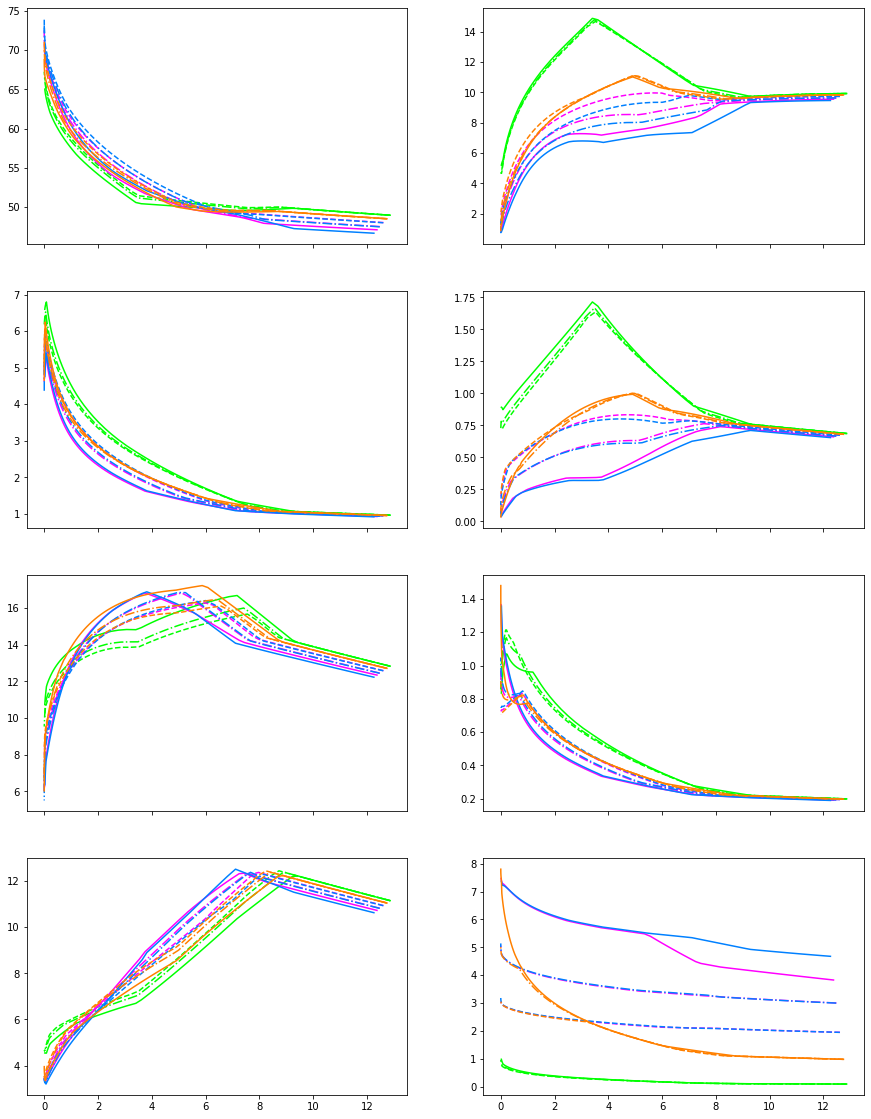

In [316]:


fig, ax = plt.subplots(4,2, sharex = True)
fig.set_figheight(20)
fig.set_figwidth(15)
plt.rcParams["font.family"] ="sans-serif" 
plt.rcParams["font.size"] = 12


for v in volbudg:
    df_v = play[play.newcolumn == v]
    for p in pressure:
        df_vp = df_v[df_v.pressure_bar == p]
        
        x = df_vp['MgO_Liq']
        ax[0,0].plot(x, df_vp['SiO2_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[0,1].plot(x, df_vp['FeOt_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,0].plot(x, df_vp['K2O_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,1].plot(x, df_vp['TiO2_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,0].plot(x, df_vp['Al2O3_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,1].plot(x, df_vp['P2O5_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[3,0].plot(x, df_vp['CaO_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[3,1].plot(x, df_vp['H2O_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])

        
# Natural data           
# Construct symbol dictionary for MI hosts
host = ['ol', 'cpx', 'plag']
symb = ['^', 'o', 's']
symbmap = dict(zip(host, symb))

df_wr = (yas_dat[yas_dat.Data_Type == 'WR'])

x = df_wr['MgO']
ax[0,0].scatter(x, df_wr['SiO2'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[0,1].scatter(x, df_wr['FeOt'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[1,0].scatter(x, df_wr['K2O'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[1,1].scatter(x, df_wr['TiO2'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[2,0].scatter(x, df_wr['Al2O3'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[2,1].scatter(x, df_wr['P2O5'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')         
ax[3,0].scatter(x, df_wr['CaO'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[3,1].scatter(x, df_wr['H2O+'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')   



#plotting MI data
for i in host: 
    df0 = vandat[vandat['Island']=='Yasur']
    dfhost = df0[df0['Host'] == i]
    x = dfhost['MgO']
    ax[0,0].scatter(x, dfhost['SiO2'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[0,1].scatter(x, dfhost['FeOt'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[1,0].scatter(x, dfhost['K2O'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[1,1].scatter(x, dfhost['TiO2'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[2,0].scatter(x, dfhost['Al2O3'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[2,1].scatter(x, dfhost['P2O5'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[3,0].scatter(x, dfhost['CaO'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[3,1].scatter(x, dfhost['H2O+'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    #ax[3,1].legend()
    
# Plotting EPMA Data
for b in yas_mi['Min_Host'].unique():
    our_data = yas_mi[yas_mi.Min_Host == b]
        
    x = our_data['MgO']
    
    ax[0,0].scatter(x, our_data['SiO2'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[0,1].scatter(x, our_data['FeO'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[1,0].scatter(x, our_data['K2O'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[1,1].scatter(x, our_data['TiO2'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[2,0].scatter(x, our_data['Al2O3'],color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[2,1].scatter(x, our_data['P2O5'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[3,0].scatter(x, our_data['CaO'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
# Matrix Glass Data

        
ax = ax.flatten()
for i in range(8):
    ax[i].tick_params(axis='both', which='both', labelsize=15, direction='in')
    ax[i].set_xlim(0,8)
    ax[i].set_xlabel('MgO wt%', fontsize=15,weight='bold')
    if i == 0:
        ax[i].set_ylabel('SiO2 wt%', fontsize=15, weight='bold')
    if i == 1:
        ax[i].set_ylabel('FeOt wt%', fontsize=15, weight='bold')
    if i == 2:
        ax[i].set_ylabel('K2O wt%', fontsize=15, weight='bold')
    if i == 3:
        ax[i].set_ylabel('TiO2 wt%', fontsize=15, weight='bold')
    if i == 4:
        ax[i].set_ylabel('Al2O3 wt%', fontsize=15, weight='bold')
    if i == 5:
        ax[i].set_ylabel('P2O5 wt%', fontsize=15, weight='bold')
    if i == 6:
        ax[i].set_ylabel('CaO wt%', fontsize=15, weight='bold')
    if i == 7:
        ax[i].set_ylabel('H2O wt%', fontsize=15, weight='bold')




In [ ]:
play2 = mast_df[mast_df.melt_f > 0.05] 

In [ ]:
# Metal concentration plots
fig, ax = plt.subplots(4,4, sharex = True)
ax[0,0].invert_xaxis()
fig.set_figheight(15)
fig.set_figwidth(15)
plt.rcParams["font.family"] ="sans-serif" 
plt.rcParams["font.size"] = 12

print(scalarMap2)
print(pdict)
for v in volbudg:
    df_v = play2[play2.newcolumn == v]
    for p in pressure:
        df_vp = df_v[df_v.pressure_bar == p]
        
        x = df_vp['melt_f']
        ax[0,0].plot(x, df_vp['melt_S_sulf'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[0,1].plot(x, df_vp['fluid_S'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[0,2].plot(x, df_vp['solid_S'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,0].plot(x, df_vp['melt_Cu'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,1].plot(x, df_vp['fluid_Cu'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,2].plot(x, df_vp['solid_Cu'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,0].plot(x, df_vp['melt_Cl'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,1].plot(x, df_vp['fluid_Cl'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,2].plot(x, df_vp['solid_Cl'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[3,0].plot(x, df_vp['melt_Pb'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[3,1].plot(x, df_vp['fluid_Pb'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[3,2].plot(x, df_vp['solid_Pb'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        
        #Fluid-Melt Partitioning behaviour
        ax[0,3].plot(x, df_vp['bulk_DS'], color=scalarMap2[v], label='DS', linestyle=pdict[p])
        ax[2,3].plot(x, df_vp['bulk_DCl'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,3].plot(x, df_vp['bulk_DCu_fm'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[3,3].plot(x, df_vp['bulk_DPb_fm'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        

        ax[3,2].legend()

    
        
ax = ax.flatten()
for i in range(16):
    ax[i].tick_params(axis='both', which='both', labelsize=10, direction='in')
    ax[i].set_xlim(1,0.1)
    ax[i].set_xlabel('Melt Fraction', fontsize=12,weight='normal')
    if i == 0:
        ax[i].set_ylabel('S ppm', fontsize=15, weight='bold')
        ax[i].set_title('MELT', fontsize=15, weight='bold')
    if i == 4:
        ax[i].set_ylabel('Cu ppm', fontsize=15, weight='bold')
    if i == 8:
        ax[i].set_ylabel('Cl wt%', fontsize=15, weight='bold')
    if i == 1:
        ax[i].set_title('FLUID', fontsize=15, weight='bold')
    if i == 2:
        ax[i].set_title('SOLID', fontsize=15, weight='bold')
    if i == 3:
        ax[i].set_title('Fluid-Melt Kd', fontsize=15, weight='bold')
    if i == 12:
        ax[i].set_ylabel('Pb ppm', fontsize=15, weight='bold')


In [ ]:
water_2 = play#[play.unique.str.contains('H2O_8.0_')]

#example = distinctipy.get_colors(32)
#colors = example
volbudg = water_2['newcolumn'].unique()
scalarMap2 = dict(zip(volbudg, colors))

pressure = [2000]#,1000,500]

fig, ax = plt.subplots(4,2, sharex = True)
fig.set_figheight(20)
fig.set_figwidth(15)
plt.rcParams["font.family"] ="sans-serif" 
plt.rcParams["font.size"] = 12


for v in water_2['newcolumn'].unique():
    df_v = water_2[water_2.newcolumn == v]
    for p in pressure:
        df_vp = df_v[df_v.pressure_bar == p]
        
        x = df_vp['MgO_Liq']
        ax[0,0].plot(x, df_vp['SiO2_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[0,1].plot(x, df_vp['FeOt_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,0].plot(x, df_vp['K2O_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,1].plot(x, df_vp['TiO2_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,0].plot(x, df_vp['Al2O3_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,1].plot(x, df_vp['P2O5_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[3,0].plot(x, df_vp['CaO_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[3,1].plot(x, df_vp['H2O_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])

        
# Natural data           
# Construct symbol dictionary for MI hosts
host = ['ol', 'cpx', 'plag']
symb = ['^', 'o', 's']
symbmap = dict(zip(host, symb))

df_wr = (yas_dat[yas_dat.Data_Type == 'WR'])

x = df_wr['MgO']
ax[0,0].scatter(x, df_wr['SiO2'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[0,1].scatter(x, df_wr['FeOt'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[1,0].scatter(x, df_wr['K2O'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[1,1].scatter(x, df_wr['TiO2'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[2,0].scatter(x, df_wr['Al2O3'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[2,1].scatter(x, df_wr['P2O5'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')         
ax[3,0].scatter(x, df_wr['CaO'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[3,1].scatter(x, df_wr['H2O+'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')   
ax[3,1].legend()


#plotting MI data
for i in host: 
    df0 = vandat[vandat['Island']=='Yasur']
    dfhost = df0[df0['Host'] == i]
    x = dfhost['MgO']
    ax[0,0].scatter(x, dfhost['SiO2'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[0,1].scatter(x, dfhost['FeOt'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[1,0].scatter(x, dfhost['K2O'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[1,1].scatter(x, dfhost['TiO2'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[2,0].scatter(x, dfhost['Al2O3'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[2,1].scatter(x, dfhost['P2O5'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[3,0].scatter(x, dfhost['CaO'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[3,1].scatter(x, dfhost['H2O+'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[3,1].legend()
# Plotting EPMA Data
for b in yas_mi['Min_Host'].unique():
    our_data = yas_mi[yas_mi.Min_Host == b]
        
    x = our_data['MgO']
    
    ax[0,0].scatter(x, our_data['SiO2'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[0,1].scatter(x, our_data['FeO'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[1,0].scatter(x, our_data['K2O'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[1,1].scatter(x, our_data['TiO2'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[2,0].scatter(x, our_data['Al2O3'],color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[2,1].scatter(x, our_data['P2O5'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[3,0].scatter(x, our_data['CaO'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
      
        
ax = ax.flatten()
for i in range(8):
    ax[i].tick_params(axis='both', which='both', labelsize=15, direction='in')
    ax[i].set_xlim(0,8)
    ax[i].set_xlabel('MgO wt%', fontsize=15,weight='bold')
    if i == 0:
        ax[i].set_ylabel('SiO2 wt%', fontsize=15, weight='bold')
    if i == 1:
        ax[i].set_ylabel('FeOt wt%', fontsize=15, weight='bold')
    if i == 2:
        ax[i].set_ylabel('K2O wt%', fontsize=15, weight='bold')
    if i == 3:
        ax[i].set_ylabel('TiO2 wt%', fontsize=15, weight='bold')
    if i == 4:
        ax[i].set_ylabel('Al2O3 wt%', fontsize=15, weight='bold')
    if i == 5:
        ax[i].set_ylabel('P2O5 wt%', fontsize=15, weight='bold')
    if i == 6:
        ax[i].set_ylabel('CaO wt%', fontsize=15, weight='bold')
    if i == 7:
        ax[i].set_ylabel('H2O wt%', fontsize=15, weight='bold')

## Part 12: Plots for estimating the initial FeOt of MIs for Petrolog3

### Our Fo# of host olivines ranges from 66.8 to 68.4 - very narrow range but very evolved. We run a MELTS FC simulation to see if we can recreate these MI and matrix glasses. 

In [ ]:
# Step 1 - screen for ol hosted only
yas_mi_ol = yas_mi[yas_mi.Min_Host == 'ol']
yas_mxgls_ol = yas_mxgls[yas_mxgls.Min_Host == 'ol']

# for ol host Fo data we need Petrolog3 df that was compiled in EPMA Feb 2023 notebook:
# this only contains olivines for now until i know how to do PEC for cpx...9/feb/23
petrolog3_dat = pd.read_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/EPMA/EPMA_HOGG_nov22/Petrolog3_dat.xlsx')
petrolog3_dat.Min_Host.unique()                             

In [ ]:
yas_mxgls_ol['FeO'].mean(), yas_mxgls_ol['FeO'].std()

In [ ]:
precision = 100*(yas_mxgls_ol['FeO'].std() / yas_mxgls_ol['FeO'].mean())
SE = yas_mxgls_ol['FeO'].std() / np.sqrt(len(yas_mxgls_ol))
precision, SE

In [ ]:
water_2 = play#[play.unique.str.contains('H2O_8.0_')]

#example = distinctipy.get_colors(32)
#colors = example
volbudg = water_2['newcolumn'].unique()
scalarMap2 = dict(zip(volbudg, colors))

pressure = [2000]#,1000,500]

fig, ax = plt.subplots(4,2, sharex = True)
fig.set_figheight(20)
fig.set_figwidth(15)
plt.rcParams["font.family"] ="sans-serif" 
plt.rcParams["font.size"] = 12


for v in water_2['newcolumn'].unique():
    df_v = water_2[water_2.newcolumn == v]
    for p in pressure:
        df_vp = df_v[df_v.pressure_bar == p]
        
        x = df_vp['MgO_Liq']
        ax[0,0].plot(x, df_vp['SiO2_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[0,1].plot(x, df_vp['FeOt_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,0].plot(x, df_vp['K2O_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,1].plot(x, df_vp['TiO2_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,0].plot(x, df_vp['Al2O3_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,1].plot(x, df_vp['P2O5_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[3,0].plot(x, df_vp['CaO_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[3,1].plot(x, df_vp['H2O_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])

        
# Natural data           
# Construct symbol dictionary for MI hosts
host = ['ol', 'cpx', 'plag']
symb = ['^', 'o', 's']
symbmap = dict(zip(host, symb))

df_wr = (yas_dat[yas_dat.Data_Type == 'WR'])

x = df_wr['MgO']
ax[0,0].scatter(x, df_wr['SiO2'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[0,1].scatter(x, df_wr['FeOt'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[1,0].scatter(x, df_wr['K2O'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[1,1].scatter(x, df_wr['TiO2'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[2,0].scatter(x, df_wr['Al2O3'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[2,1].scatter(x, df_wr['P2O5'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')         
ax[3,0].scatter(x, df_wr['CaO'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[3,1].scatter(x, df_wr['H2O+'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')   
ax[3,1].legend()


#plotting MI data
for i in host: 
    df0 = vandat[vandat['Island']=='Yasur']
    dfhost = df0[df0['Host'] == 'ol']
    x = dfhost['MgO']
    ax[0,0].scatter(x, dfhost['SiO2'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[0,1].scatter(x, dfhost['FeOt'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[1,0].scatter(x, dfhost['K2O'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[1,1].scatter(x, dfhost['TiO2'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[2,0].scatter(x, dfhost['Al2O3'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[2,1].scatter(x, dfhost['P2O5'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[3,0].scatter(x, dfhost['CaO'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[3,1].scatter(x, dfhost['H2O+'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[3,1].legend()
    
# Plotting EPMA Data
for b in yas_mi_ol['Min_Host'].unique():
    our_data = yas_mi_ol[yas_mi_ol.Min_Host == b]
        
    x = our_data['MgO']
    
    ax[0,0].scatter(x, our_data['SiO2'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[0,1].scatter(x, our_data['FeO'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[1,0].scatter(x, our_data['K2O'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[1,1].scatter(x, our_data['TiO2'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[2,0].scatter(x, our_data['Al2O3'],color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[2,1].scatter(x, our_data['P2O5'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[3,0].scatter(x, our_data['CaO'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)

#plot matrix glasses 
    ax[0,1].scatter(yas_mxgls_ol['MgO'], yas_mxgls_ol['FeO'], color='r', marker='o',alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
        
ax = ax.flatten()
for i in range(8):
    ax[i].tick_params(axis='both', which='both', labelsize=15, direction='in')
    ax[i].set_xlim(0,8)
    ax[i].set_xlabel('MgO wt%', fontsize=15,weight='bold')
    if i == 0:
        ax[i].set_ylabel('SiO2 wt%', fontsize=15, weight='bold')
    if i == 1:
        ax[i].set_ylabel('FeOt wt%', fontsize=15, weight='bold')
        ax[i].set_ylim(5,12.5)
    if i == 2:
        ax[i].set_ylabel('K2O wt%', fontsize=15, weight='bold')
    if i == 3:
        ax[i].set_ylabel('TiO2 wt%', fontsize=15, weight='bold')
    if i == 4:
        ax[i].set_ylabel('Al2O3 wt%', fontsize=15, weight='bold')
    if i == 5:
        ax[i].set_ylabel('P2O5 wt%', fontsize=15, weight='bold')
    if i == 6:
        ax[i].set_ylabel('CaO wt%', fontsize=15, weight='bold')
    if i == 7:
        ax[i].set_ylabel('H2O wt%', fontsize=15, weight='bold')

In [ ]:
# Now lets comapre fo content and FeOt predicted by melts compared to our data 
MELTS_Fo_Mg = pd.read_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/MELTs/pyMELTScalc-0.0.12/Fo_Mg_MELTS.xlsx')

In [ ]:
MELTS_Fo_Mg['Fo_Ol'] = 100* (MELTS_Fo_Mg['MgO_Ol']/40.3044)/((MELTS_Fo_Mg['FeO_Ol']/71.844)+(MELTS_Fo_Mg['MgO_Ol']/40.3044))
MELTS_Fo_Mg[['newcolumn','FeOt_Liq','FeO_Liq','Fe2O3_Liq', 'MgO_Ol','FeO_Ol','Fo_Ol', 'pressure_bar']]


In [ ]:
volbudg = MELTS_Fo_Mg['newcolumn'].unique()
scalarMap2 = dict(zip(volbudg, colors))

pressure = [2000]#1000,500]

fig, ax = plt.subplots(1,2, sharex = False)
fig.set_figheight(5)
fig.set_figwidth(15)
plt.rcParams["font.family"] ="sans-serif" 
plt.rcParams["font.size"] = 12


for v in MELTS_Fo_Mg['newcolumn'].unique():
    df_v = MELTS_Fo_Mg[MELTS_Fo_Mg.newcolumn == v]
    for p in pressure:
        df_vp = df_v[df_v.pressure_bar == p]
        
        x = df_vp['Fo_Ol']
        ax[0].plot(df_vp['MgO_Liq'], df_vp['FeOt_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1].plot(x, df_vp['FeOt_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[0].legend()
        
# Plotting EPMA Data
for b in petrolog3_dat['Min_Host'].unique():
    our_data = petrolog3_dat[petrolog3_dat.Min_Host == b]
        
    x = our_data['Fo_h']
    ax[0].scatter(our_data['MgO'],our_data['FeO'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[1].scatter(x, our_data['FeO'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
   
#plot matrix glasses 
    ax[0].scatter(yas_mxgls_ol['MgO'], yas_mxgls_ol['FeO'], color='r', marker='o',alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[1].scatter(yas_mxgls_ol['Mg_Fo_Num'], yas_mxgls_ol['FeO'], color='r', marker='o',alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    
ax = ax.flatten()
for i in range(2):
    ax[i].tick_params(axis='both', which='both', labelsize=15, direction='in')
    ax[i].set_ylabel('FeOt wt%', fontsize=15,weight='bold')
    if i == 0:
        ax[i].set_xlabel('MgO wt%', fontsize=15, weight='bold')
    if i == 1:
        ax[i].set_xlabel('Fo content', fontsize=15, weight='bold')
        


# Import PEC corrected compositions and plot against raw data

In [ ]:
#import PEC olivine hosted MI data
pec_m2 = pd.read_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/EPMA/EPMA_HOGG_nov22/petrolog_pec_D2001/petrolog_pec_m2.xlsx', sheet_name='Sheet1')
pec_m3 = pd.read_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/EPMA/EPMA_HOGG_nov22/petrolog_pec_D2001/petrolog_pec_m3.xlsx', sheet_name='Sheet1')
pec_m4 = pd.read_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/EPMA/EPMA_HOGG_nov22/petrolog_pec_D2001/petrolog_pec_m4.xlsx', sheet_name='Sheet1')

In [ ]:
PEC_D2000 = pd.concat([pec_m2,pec_m3,pec_m4])
PEC_D2000.columns

In [ ]:
volbudg = MELTS_Fo_Mg['newcolumn'].unique()
scalarMap2 = dict(zip(volbudg, colors))

pressure = [2000,500]

fig, ax = plt.subplots(1,2, sharex = False)
fig.set_figheight(5)
fig.set_figwidth(15)
plt.rcParams["font.family"] ="sans-serif" 
plt.rcParams["font.size"] = 12


for v in MELTS_Fo_Mg['newcolumn'].unique():
    df_v = MELTS_Fo_Mg[MELTS_Fo_Mg.newcolumn == v]
    for p in pressure:
        df_vp = df_v[df_v.pressure_bar == p]
        
        x = df_vp['Fo_Ol']
        ax[0].plot(df_vp['MgO_Liq'], df_vp['FeOt_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1].plot(x, df_vp['FeOt_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[0].legend()
        
# Plotting EPMA Data
for b in petrolog3_dat['Min_Host'].unique():
    our_data = petrolog3_dat[petrolog3_dat.Min_Host == b]
        
    x = our_data['Fo_h']
    ax[0].scatter(our_data['MgO'],our_data['FeO'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[1].scatter(x, our_data['FeO'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
   
#plot matrix glasses 
    ax[0].scatter(yas_mxgls_ol['MgO'], yas_mxgls_ol['FeO'], color='r', marker='o',alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[1].scatter(yas_mxgls_ol['Mg_Fo_Num'], yas_mxgls_ol['FeO'], color='r', marker='o',alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    
# Plotting PEC-corrected data
ax[0].scatter(PEC_D2000['  MgO'], PEC_D2000['FEO*'], color='grey', marker='o',alpha=0.5, edgecolor='k',s=60,  zorder=4)
ax[1].scatter(PEC_D2000['FO_Host'], PEC_D2000['FEO*'], color='grey', marker='o',alpha=0.5, edgecolor='k',s=60,  zorder=4)    
    
    
ax = ax.flatten()
for i in range(2):
    ax[i].tick_params(axis='both', which='both', labelsize=15, direction='in')
    ax[i].set_ylabel('FeOt wt%', fontsize=15,weight='bold')
    ax[i].set_ylim(6,11)
    if i == 0:
        ax[i].set_xlim(0,4)
        ax[i].set_xlabel('MgO wt%', fontsize=15, weight='bold')
    if i == 1:
        ax[i].set_xlim(20,70)
        ax[i].set_xlabel('Fo content', fontsize=15, weight='bold')

## Now plot against the natural data too

In [ ]:
PEC_D2000.columns

In [ ]:
water_2 = play#[play.unique.str.contains('H2O_8.0_')]

#example = distinctipy.get_colors(32)
#colors = example
volbudg = water_2['newcolumn'].unique()
scalarMap2 = dict(zip(volbudg, colors))

pressure = [2000,1000,500]

fig, ax = plt.subplots(4,2, sharex = True)
fig.set_figheight(20)
fig.set_figwidth(15)
plt.rcParams["font.family"] ="sans-serif" 
plt.rcParams["font.size"] = 12


for v in water_2['newcolumn'].unique():
    df_v = water_2[water_2.newcolumn == v]
    for p in pressure:
        df_vp = df_v[df_v.pressure_bar == p]
        
        x = df_vp['MgO_Liq']
        ax[0,0].plot(x, df_vp['SiO2_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[0,1].plot(x, df_vp['FeOt_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,0].plot(x, df_vp['K2O_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,1].plot(x, df_vp['TiO2_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,0].plot(x, df_vp['Al2O3_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,1].plot(x, df_vp['P2O5_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[3,0].plot(x, df_vp['CaO_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[3,1].plot(x, df_vp['H2O_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])

        
# Natural data           
# Construct symbol dictionary for MI hosts
host = ['ol', 'cpx', 'plag']
symb = ['^', 'o', 's']
symbmap = dict(zip(host, symb))

df_wr = (yas_dat[yas_dat.Data_Type == 'WR'])

x = df_wr['MgO']
ax[0,0].scatter(x, df_wr['SiO2'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[0,1].scatter(x, df_wr['FeOt'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[1,0].scatter(x, df_wr['K2O'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[1,1].scatter(x, df_wr['TiO2'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[2,0].scatter(x, df_wr['Al2O3'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[2,1].scatter(x, df_wr['P2O5'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')         
ax[3,0].scatter(x, df_wr['CaO'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[3,1].scatter(x, df_wr['H2O+'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')   
ax[3,1].legend()


#plotting MI data
for i in host: 
    df0 = vandat[vandat['Island']=='Yasur']
    dfhost = df0[df0['Host'] == 'ol']
    x = dfhost['MgO']
    ax[0,0].scatter(x, dfhost['SiO2'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[0,1].scatter(x, dfhost['FeOt'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[1,0].scatter(x, dfhost['K2O'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[1,1].scatter(x, dfhost['TiO2'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[2,0].scatter(x, dfhost['Al2O3'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[2,1].scatter(x, dfhost['P2O5'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[3,0].scatter(x, dfhost['CaO'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[3,1].scatter(x, dfhost['H2O+'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[3,1].legend()
    
# Plotting EPMA Data
for b in yas_mi_ol['Min_Host'].unique():
    our_data = yas_mi_ol[yas_mi_ol.Min_Host == b]
        
    x = our_data['MgO']
    
    ax[0,0].scatter(x, our_data['SiO2'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[0,1].scatter(x, our_data['FeO'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[1,0].scatter(x, our_data['K2O'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[1,1].scatter(x, our_data['TiO2'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[2,0].scatter(x, our_data['Al2O3'],color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[2,1].scatter(x, our_data['P2O5'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[3,0].scatter(x, our_data['CaO'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)

#plot matrix glasses 
    ax[0,1].scatter(yas_mxgls_ol['MgO'], yas_mxgls_ol['FeO'], color='r', marker='o',alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    
# Plotting PEC-corrected data
x =PEC_D2000['  MgO'] 
ax[0,0].scatter(x, PEC_D2000[' SiO2'], color='grey', marker='o',alpha=0.5, edgecolor='k',s=60,label='PEC_corr_MI',  zorder=4)
ax[0,1].scatter(x, PEC_D2000['FEO*'], color='cyan', marker='o',alpha=0.5, edgecolor='k',s=60,  zorder=4)
ax[1,0].scatter(x, PEC_D2000['  K2O'], color='grey', marker='o',alpha=0.5, edgecolor='k',s=60,  zorder=4)
ax[1,1].scatter(x, PEC_D2000[' TiO2'], color='grey', marker='o',alpha=0.5, edgecolor='k',s=60,  zorder=4)
ax[2,0].scatter(x, PEC_D2000['Al2O3'],color='grey', marker='o',alpha=0.5, edgecolor='k',s=60,  zorder=4)
ax[2,1].scatter(x, PEC_D2000[' P2O5'], color='grey', marker='o',alpha=0.5, edgecolor='k',s=60,  zorder=4)
ax[3,0].scatter(x, PEC_D2000['  CaO'], color='grey', marker='o',alpha=0.5, edgecolor='k',s=60,  zorder=4)
 
ax = ax.flatten()
for i in range(8):
    ax[i].tick_params(axis='both', which='both', labelsize=15, direction='in')
    ax[i].set_xlim(0,4)
    ax[i].set_xlabel('MgO wt%', fontsize=15,weight='bold')
    if i == 0:
        ax[i].set_ylabel('SiO2 wt%', fontsize=15, weight='bold')
    if i == 1:
        ax[i].set_ylabel('FeOt wt%', fontsize=15, weight='bold')
        ax[i].set_ylim(6,10)
    if i == 2:
        ax[i].set_ylabel('K2O wt%', fontsize=15, weight='bold')
    if i == 3:
        ax[i].set_ylabel('TiO2 wt%', fontsize=15, weight='bold')
    if i == 4:
        ax[i].set_ylabel('Al2O3 wt%', fontsize=15, weight='bold')
    if i == 5:
        ax[i].set_ylabel('P2O5 wt%', fontsize=15, weight='bold')
    if i == 6:
        ax[i].set_ylabel('CaO wt%', fontsize=15, weight='bold')
    if i == 7:
        ax[i].set_ylabel('H2O wt%', fontsize=15, weight='bold')

### Sensitivity Analysis - v1.2.0 - CO2 0.1 wt% - H2O 1, 4, and 8 wt% - 3 diff fo2 buffers

In [ ]:
# split mast_df in to three df according to H2O content in unique colunmn

water_2 = mast_df[mast_df.unique.str.contains('H2O_8.0')] #8 wt%
mixedvol_2 = mast_df[mast_df.unique.str.contains('H2O_4.0')] # 4wt%
water_1 = mast_df[mast_df.unique.str.contains('H2O_1.0')] # 1 wt%

In [ ]:
#example = distinctipy.get_colors(32)
#colors = example
volbudg = water_2['newcolumn'].unique()
scalarMap3 = dict(zip(volbudg, colors))
scalarMap4 = dict(zip(mixedvol_2['newcolumn'].unique(), colors))
scalarMap5 = dict(zip(water_1['newcolumn'].unique(), colors))
print(scalarMap3)

pressure = [2000]

fig, ax = plt.subplots(4,2, sharex = True)
fig.set_figheight(20)
fig.set_figwidth(17)
plt.rcParams["font.family"] ="sans-serif" 
plt.rcParams["font.size"] = 12


for v in water_2['newcolumn'].unique():
    df_v = water_2[water_2.newcolumn == v]
    for p in pressure:
        df_vp = df_v[df_v.pressure_bar == p]
        
        x = df_vp['MgO_Liq']
        ax[0,0].plot(x, df_vp['SiO2_Liq'], color=scalarMap3[v], label=v, linestyle='dashed')
        ax[0,1].plot(x, df_vp['FeOt_Liq'], color=scalarMap3[v], label=v, linestyle='dashed')
        ax[1,0].plot(x, df_vp['K2O_Liq'], color=scalarMap3[v], label=v, linestyle='dashed')
        ax[1,1].plot(x, df_vp['TiO2_Liq'], color=scalarMap3[v], label=v, linestyle='dashed')
        ax[2,0].plot(x, df_vp['Al2O3_Liq'], color=scalarMap3[v], label=v, linestyle='dashed')
        ax[2,1].plot(x, df_vp['P2O5_Liq'], color=scalarMap3[v], label=v, linestyle='dashed')
        ax[3,0].plot(x, df_vp['CaO_Liq'], color=scalarMap3[v], label=v, linestyle='dashed')
        ax[3,1].plot(x, df_vp['H2O_Liq'], color=scalarMap3[v], label='H2O 8 wt%', linestyle='dashed')
        

for v in mixedvol_2['newcolumn'].unique():
    df_v = mixedvol_2[mixedvol_2.newcolumn == v]
    for p in pressure:
        df_vp = df_v[df_v.pressure_bar == p]
        
        x = df_vp['MgO_Liq']
        ax[0,0].plot(x, df_vp['SiO2_Liq'], color=scalarMap4[v], label='1.2.0', linestyle='-')
        ax[0,1].plot(x, df_vp['FeOt_Liq'], color=scalarMap4[v], label=v, linestyle='-')
        ax[1,0].plot(x, df_vp['K2O_Liq'], color=scalarMap4[v], label=v, linestyle='-')
        ax[1,1].plot(x, df_vp['TiO2_Liq'], color=scalarMap4[v], label=v, linestyle='-')
        ax[2,0].plot(x, df_vp['Al2O3_Liq'], color=scalarMap4[v], label=v, linestyle='-')
        ax[2,1].plot(x, df_vp['P2O5_Liq'], color=scalarMap4[v], label=v, linestyle='-')
        ax[3,0].plot(x, df_vp['CaO_Liq'], color=scalarMap4[v], label=v, linestyle='-')
        ax[3,1].plot(x, df_vp['H2O_Liq'], color=scalarMap4[v], label='H2O 4 wt%', linestyle='-')


for v in water_1['newcolumn'].unique():
    df_v = water_1[water_1.newcolumn == v]
    for p in pressure:
        df_vp = df_v[df_v.pressure_bar == p]
        
        x = df_vp['MgO_Liq']
        ax[0,0].plot(x, df_vp['SiO2_Liq'], color=scalarMap5[v], label=v, linestyle=':')
        ax[0,1].plot(x, df_vp['FeOt_Liq'], color=scalarMap5[v], label=v, linestyle=':')
        ax[1,0].plot(x, df_vp['K2O_Liq'], color=scalarMap5[v], label=v, linestyle=':')
        ax[1,1].plot(x, df_vp['TiO2_Liq'], color=scalarMap5[v], label=v, linestyle=':')
        ax[2,0].plot(x, df_vp['Al2O3_Liq'], color=scalarMap5[v], label=v, linestyle=':')
        ax[2,1].plot(x, df_vp['P2O5_Liq'], color=scalarMap5[v], label=v, linestyle=':')
        ax[3,0].plot(x, df_vp['CaO_Liq'], color=scalarMap5[v], label=v, linestyle=':')
        ax[3,1].plot(x, df_vp['H2O_Liq'], color=scalarMap5[v], label='H2O 1 wt%', linestyle=':')
        ax[3,1].legend()

        
        #### natural data input #####        
# Natural data           
# Construct symbol dictionary for MI hosts
host = ['ol', 'cpx', 'plag']
symb = ['^', 'o', 's']
symbmap = dict(zip(host, symb))

df_wr = (yas_dat[yas_dat.Data_Type == 'WR'])

x = df_wr['MgO']
ax[0,0].scatter(x, df_wr['SiO2'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[0,1].scatter(x, df_wr['FeOt'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[1,0].scatter(x, df_wr['K2O'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[1,1].scatter(x, df_wr['TiO2'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[2,0].scatter(x, df_wr['Al2O3'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[2,1].scatter(x, df_wr['P2O5'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')         
ax[3,0].scatter(x, df_wr['CaO'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[3,1].scatter(x, df_wr['H2O+'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')   
ax[3,0].legend()


#plotting MI data
for i in host: 
    df0 = vandat[vandat['Island']=='Yasur']
    dfhost = df0[df0['Host'] == i]
    x = dfhost['MgO']
    ax[0,0].scatter(x, dfhost['SiO2'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[0,1].scatter(x, dfhost['FeOt'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[1,0].scatter(x, dfhost['K2O'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[1,1].scatter(x, dfhost['TiO2'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[2,0].scatter(x, dfhost['Al2O3'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[2,1].scatter(x, dfhost['P2O5'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[3,0].scatter(x, dfhost['CaO'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[3,1].scatter(x, dfhost['H2O+'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    
# Plotting EPMA Data
for b in yas_mi['Min_Host'].unique():
    our_data = yas_mi[yas_mi.Min_Host == b]
        
    x = our_data['MgO']
    
    ax[0,0].scatter(x, our_data['SiO2'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[0,1].scatter(x, our_data['FeO'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[1,0].scatter(x, our_data['K2O'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[1,1].scatter(x, our_data['TiO2'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[2,0].scatter(x, our_data['Al2O3'],color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[2,1].scatter(x, our_data['P2O5'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[3,0].scatter(x, our_data['CaO'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    
ax = ax.flatten()
for i in range(8):
    ax[i].tick_params(axis='both', which='both', labelsize=15, direction='in')
    ax[i].set_xlim(0,8)
    ax[i].set_xlabel('MgO wt%', fontsize=15,weight='bold')
    if i == 0:
        ax[i].set_ylabel('SiO2 wt%', fontsize=15, weight='bold')
    if i == 1:
        ax[i].set_ylabel('FeOt wt%', fontsize=15, weight='bold')
    if i == 2:
        ax[i].set_ylabel('K2O wt%', fontsize=15, weight='bold')
    if i == 3:
        ax[i].set_ylabel('TiO2 wt%', fontsize=15, weight='bold')
    if i == 4:
        ax[i].set_ylabel('Al2O3 wt%', fontsize=15, weight='bold')
    if i == 5:
        ax[i].set_ylabel('P2O5 wt%', fontsize=15, weight='bold')
    if i == 6:
        ax[i].set_ylabel('CaO wt%', fontsize=15, weight='bold')
    if i == 7:
        ax[i].set_ylabel('H2O wt%', fontsize=15, weight='bold')

In [ ]:

fig, ax = plt.subplots(4,4, sharex = False)
ax[0,0].invert_xaxis()
fig.set_figheight(15)
fig.set_figwidth(15)
plt.rcParams["font.family"] ="sans-serif" 
plt.rcParams["font.size"] = 12

volbudg = water_2['newcolumn'].unique()
scalarMap3 = dict(zip(volbudg, colors))
scalarMap4 = dict(zip(mixedvol_2['newcolumn'].unique(), colors))
scalarMap5 = dict(zip(water_1['newcolumn'].unique(), colors))

pressure = [2000]
print(scalarMap3)
print(pdict)

for v in volbudg:
    df_v = water_2[water_2.newcolumn == v]
    for p in pressure:
        df_vp = df_v[df_v.pressure_bar == p]
        
        x = df_vp['melt_f']
        ax[0,0].plot(x, df_vp['melt_S_sulf'], color=scalarMap3[v], label=v, linestyle='dashed')
        ax[0,1].plot(x, df_vp['fluid_S'], color=scalarMap3[v], label=v, linestyle='dashed')
        ax[0,2].plot(x, df_vp['solid_S'], color=scalarMap3[v], label=v, linestyle='dashed')
        ax[1,0].plot(x, df_vp['melt_Cu'], color=scalarMap3[v], label=v, linestyle='dashed')
        ax[1,1].plot(x, df_vp['fluid_Cu'], color=scalarMap3[v], label=v, linestyle='dashed')
        ax[1,2].plot(x, df_vp['solid_Cu'], color=scalarMap3[v], label=v, linestyle='dashed')
        ax[2,0].plot(x, df_vp['melt_Cl'], color=scalarMap3[v], label=v, linestyle='dashed')
        ax[2,1].plot(x, df_vp['fluid_Cl'], color=scalarMap3[v], label='8 wt%', linestyle='dashed')
        ax[2,2].plot(x, df_vp['solid_Cl'], color=scalarMap3[v], label='8 wt%', linestyle='dashed')
        ax[3,0].plot(x, df_vp['melt_Pb'], color=scalarMap3[v], label='8 wt%', linestyle='dashed')
        ax[3,1].plot(x, df_vp['fluid_Pb'], color=scalarMap3[v], label='8 wt%', linestyle='dashed')
        ax[3,2].plot(x, df_vp['solid_Pb'], color=scalarMap3[v], label='8 wt%', linestyle='dashed')
        ax[2,2].legend()
        #Fluid-Melt Partitioning behaviour
        ax[0,3].plot(x, df_vp['bulk_DS'], color=scalarMap3[v], label='DS', linestyle='dashed')
        ax[2,3].plot(x, df_vp['bulk_DCl'], color=scalarMap3[v], label='8 wt%', linestyle='dashed')
        ax[1,3].plot(x, df_vp['bulk_DCu_fm'], color=scalarMap3[v], label='8 wt%', linestyle='dashed')
        ax[3,3].plot(x, df_vp['bulk_DPb_fm'], color=scalarMap3[v], label='8 wt%', linestyle='dashed')
        
for v in mixedvol_2['newcolumn'].unique():
    df_v = mixedvol_2[mixedvol_2.newcolumn == v]
    for p in pressure:
        df_vp = df_v[df_v.pressure_bar == p]
        
        x = df_vp['melt_f']
        ax[0,0].plot(x, df_vp['melt_S_sulf'], color=scalarMap4[v], label=v, linestyle='-')
        ax[0,1].plot(x, df_vp['fluid_S'], color=scalarMap4[v], label=v, linestyle='-')
        ax[0,2].plot(x, df_vp['solid_S'], color=scalarMap4[v], label=v, linestyle='-')
        ax[1,0].plot(x, df_vp['melt_Cu'], color=scalarMap4[v], label=v, linestyle='-')
        ax[1,1].plot(x, df_vp['fluid_Cu'], color=scalarMap4[v], label=v, linestyle='-')
        ax[1,2].plot(x, df_vp['solid_Cu'], color=scalarMap4[v], label=v, linestyle='-')
        ax[2,0].plot(x, df_vp['melt_Cl'], color=scalarMap4[v], label=v, linestyle='-')
        ax[2,1].plot(x, df_vp['fluid_Cl'], color=scalarMap4[v], label=v, linestyle='-')
        ax[2,2].plot(x, df_vp['solid_Cl'], color=scalarMap4[v], label='4 wt%', linestyle='-')
        ax[3,0].plot(x, df_vp['melt_Pb'], color=scalarMap4[v], label='4 wt%', linestyle='-')
        ax[3,1].plot(x, df_vp['fluid_Pb'], color=scalarMap4[v], label='4 wt%', linestyle='-')
        ax[3,2].plot(x, df_vp['solid_Pb'], color=scalarMap4[v], label='4 wt%', linestyle='-')
        ax[2,2].legend()
        #Fluid-Melt Partitioning behaviour
        ax[0,3].plot(x, df_vp['bulk_DS'], color=scalarMap4[v], label='DS', linestyle=pdict[p])
        ax[2,3].plot(x, df_vp['bulk_DCl'], color=scalarMap4[v], label='4 wt%', linestyle='-')
        ax[1,3].plot(x, df_vp['bulk_DCu_fm'], color=scalarMap4[v],label='4 wt%', linestyle='-')
        ax[3,3].plot(x, df_vp['bulk_DPb_fm'], color=scalarMap4[v],label='4 wt%', linestyle='-')

for v in water_1['newcolumn'].unique():
    df_v = water_1[water_1.newcolumn == v]
    for p in pressure:
        df_vp = df_v[df_v.pressure_bar == p]
        
        x = df_vp['melt_f']
        ax[0,0].plot(x, df_vp['melt_S_sulf'], color=scalarMap5[v], label=v, linestyle=':')
        ax[0,1].plot(x, df_vp['fluid_S'], color=scalarMap5[v], label=v, linestyle=':')
        ax[0,2].plot(x, df_vp['solid_S'], color=scalarMap5[v], label=v, linestyle=':')
        ax[1,0].plot(x, df_vp['melt_Cu'], color=scalarMap5[v], label=v, linestyle=':')
        ax[1,1].plot(x, df_vp['fluid_Cu'], color=scalarMap5[v], label=v, linestyle=':')
        ax[1,2].plot(x, df_vp['solid_Cu'], color=scalarMap5[v], label=v, linestyle=':')
        ax[2,0].plot(x, df_vp['melt_Cl'], color=scalarMap5[v], label=v, linestyle=':')
        ax[2,1].plot(x, df_vp['fluid_Cl'], color=scalarMap5[v], label=v, linestyle=':')
        ax[2,2].plot(x, df_vp['solid_Cl'], color=scalarMap5[v], label='1 wt%', linestyle=':')
        ax[3,0].plot(x, df_vp['melt_Pb'], color=scalarMap5[v], label='1 wt%', linestyle=':')
        ax[3,1].plot(x, df_vp['fluid_Pb'], color=scalarMap5[v], label='1 wt%', linestyle=':')
        ax[3,2].plot(x, df_vp['solid_Pb'], color=scalarMap5[v], label='1 wt%', linestyle=':')
        ax[2,2].legend()
        #Fluid-Melt Partitioning behaviour
        ax[0,3].plot(x, df_vp['bulk_DS'], color=scalarMap5[v], label='DS', linestyle=':')
        ax[2,3].plot(x, df_vp['bulk_DCl'], color=scalarMap5[v], label='1 wt%', linestyle=':')
        ax[1,3].plot(x, df_vp['bulk_DCu_fm'], color=scalarMap5[v], label='1 wt%', linestyle=':')
        ax[3,3].plot(x, df_vp['bulk_DPb_fm'], color=scalarMap5[v], label='1 wt%', linestyle=':')
        
        
    
        
ax = ax.flatten()
for i in range(16):
    ax[i].tick_params(axis='both', which='both', labelsize=10, direction='in')
    ax[i].set_xlim(1,0.1)
    ax[i].set_xlabel('Melt Fraction', fontsize=12,weight='normal')
    if i == 0:
        ax[i].set_ylabel('S ppm', fontsize=15, weight='bold')
        #ax[i].set_xlim(1, 0.2)
        #ax[i].set_ylim(0,1500)
        ax[i].set_title('MELT', fontsize=15, weight='bold')
    if i == 4:
        ax[i].set_ylabel('Cu ppm', fontsize=15, weight='bold')
        #ax[i].set_xlim(1, 0.2)
        #ax[i].set_ylim(0,150)
    if i == 8:
        ax[i].set_ylabel('Cl wt%', fontsize=15, weight='bold')
    if i == 1:
        ax[i].set_title('FLUID', fontsize=15, weight='bold')
    if i == 2:
        ax[i].set_title('SOLID', fontsize=15, weight='bold')
    if i == 3:
        ax[i].set_title('Fluid-Melt Kd', fontsize=15, weight='bold')
    if i == 12:
        ax[i].set_ylabel('Pb ppm', fontsize=15, weight='bold')